# Calibrate a LISFLOOD reservoir
***

**Autor:** Chus Casado<br>
**Date:** 02-11-2023<br>

**To do:**<br>
* [ ] Clean observed time series

**Questions:**<br>
* [ ] Why only some of the iterations are saved in the CSV file?
* [ ] What's the relation between likelihood and KGE?
* [ ] Fit the $Q_{min}$ based on the inflow data. Hot to fit a GEV to minima.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import spotpy
from spotpy.objectivefunctions import kge
import yaml
from pathlib import Path
from tqdm.notebook import tqdm
import glob
# import cartopy.crs as ccrs
# import cartopy.feature as cf

In [2]:
from calibration.sceua_lisflood import SCEUA_6pars
from reservoirs import Lisflood

## Configuration

In [3]:
with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

path_res = Path(cfg['path_res'])
path_ts = Path(cfg['path_ts'])
# path_out = Path(cfg['path_out'])
# if path_out.exists() is False:
#     path_out.mkdir()
# var = cfg['var']

path_datasets = Path('Z:/nahaUsers/casadje/datasets/')

# study period
start = cfg['period']['start']
end = cfg['period']['end']

# # config plots
# proj = ccrs.PlateCarree()
# extent = [-125, -67.5, 24, 51]

In [4]:
# plots will be saved in this path
path_out = Path('../results/reservoirs/LISFLOOD/calibration/')
if path_out.exists() is False:
    path_out.mkdir()

In [5]:
# # config plots
# proj = ccrs.PlateCarree()
# extent = [-125, -67.5, 24, 51]

In [6]:
# # sequential mode
# parallel = "seq"  

# # input file
# input_file = f'reservoirs/input_{ResID:03}.csv'

# # output file
# output_file = 'reservoirs/SCEUA_burek'

## Data

### Base layers

In [7]:
# catchment_pol = gpd.read_file('../GIS/catchments_US.shp')
# catchment_pol = catchment_pol.to_crs(proj)#'epsg:4326')

### GloFAS

#### Reservoirs

In [144]:
# load shapefile of GloFAS reservoirs
reservoirs = gpd.read_file('../data/reservoirs/GloFAS/GloFAS_reservoirs.shp') 
reservoirs.set_index('ResID', drop=True, inplace=True)
reservoirs.rename(columns={'stor': 'CAP_GLWD'}, inplace=True)

# select only those reservoirs included in ResOpsUS
resopsus = gpd.read_file('../GIS/reservoirs_GloFAS_ResOpsUS.shp')
resopsus.set_index('ResID', drop=True, inplace=True)
mask = reservoirs.index.intersection(resopsus.index)
reservoirs = reservoirs.loc[mask]
reservoirs.GRAND_ID = reservoirs.GRAND_ID.astype(int)

print(f'{reservoirs.shape[0]} reservoirs')

112 reservoirs


#### Time series

In [145]:
# read GloFAS time series
path = Path('../data/reservoirs/GloFAS/long_run')
glofas_ts = {}
for file in tqdm(glob.glob(f'{path}/*.csv')):
    id = int(file.split('\\')[-1].split('.')[0].lstrip('0'))
    if id not in reservoirs.index:
        continue
    glofas_ts[id] = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col='date')
    
print(f'{len(glofas_ts)} reservoirs')

  0%|          | 0/143 [00:00<?, ?it/s]

106 reservoirs


In [146]:
# check if reservoirs are missing
missing_reservoirs = reservoirs.index.difference(glofas_ts)
if len(missing_reservoirs) > 0:
    print(f'{len(missing_reservoirs)} reservoirs were not simulated in GloFAS')
    print(*missing_reservoirs)
reservoirs.drop(missing_reservoirs, axis=0, inplace=True)

6 reservoirs were not simulated in GloFAS
68 179 185 197 296 323


In [147]:
# # normalize inflow/outflow by the non-damaging outflow
# for id, df in glofas_ts.items():
#     df[['inflow', 'outflow']] /= reservoirs.loc[id, 'ndq']

#### Model parameters

In [148]:
# load static map of reservoirs
glofas_raster = xr.open_dataset(path_res)['res']

# extract an array of reservoir ID
ids = reservoirs.index.to_list()

# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for id in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    lon.loc[dict(ResID=id)] = cell.lon.data[0]
    lat.loc[dict(ResID=id)] = cell.lat.data[0]
coords = xr.Dataset({'lon': lon, 'lat': lat})

# extract parameter values
for par in ['adjustNormalFlood', 'ReservoirRnormqMult']:
    # load parameter map
    da = xr.open_dataset(f'Z:/nahaUsers/casadje/GloFASv4/parameters/{par}_GloFASv40.nc')[par]
    # extract values for each reservoir
    reservoirs[par] = da.sel(lon=lon, lat=lat, method='nearest').drop(['lon', 'lat']).to_pandas()
# rename parameter names
reservoirs.rename(columns={'adjustNormalFlood': 'alpha', 'ReservoirRnormqMult': 'beta'}, inplace=True)

  0%|          | 0/106 [00:00<?, ?it/s]

In [151]:
# adjust normal limit and outflow with the calibrated parameters
reservoirs['nlim_adj'] = reservoirs.nlim + reservoirs.alpha * (reservoirs.flim - reservoirs.nlim)
reservoirs['normq_adj'] = pd.concat((reservoirs.normq * reservoirs.beta, reservoirs.minq + .01), axis=1).max(axis=1)

### GRanD
#### Reservoirs

The shapefile of reservoirs in the GRanD data set is loaded to extract only the reservoir capacity reported in it.

In [152]:
# load GRanD data set
path_GRanD = path_datasets / 'reservoirs/GRanD/v1_3/'
grand = gpd.read_file(path_GRanD / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# add GRanD capacity to the reservoirs
reservoirs['CAP_GRAND'] = grand.loc[reservoirs.GRAND_ID, 'CAP_MCM'].values

### ResOpsUS
#### Time series

In [153]:
path_ResOps = Path(path_datasets / 'reservoirs' / 'ResOpsUS')

resops_ts = {}
for glofas_id in tqdm(reservoirs.index):
    # load timeseries
    grand_id = reservoirs.loc[glofas_id, 'GRAND_ID']
    series_id = pd.read_csv(path_ResOps / 'time_series_all' / f'ResOpsUS_{grand_id}.csv', parse_dates=True, index_col='date')
    # remove empty time series
    series_id = series_id.loc[start:end]#.dropna(axis=1, how='all')
    # remove duplicated index
    series_id = series_id[~series_id.index.duplicated(keep='first')]
    # save in dictionary
    resops_ts[glofas_id] = series_id

  0%|          | 0/106 [00:00<?, ?it/s]

In [154]:
# approximate the ResOpsUS reservoir capacity as the maximum value in the records
reservoirs['CAP_RESOPS'] = pd.Series({id: df.storage.max() for id, df in resops_ts.items()})

In [155]:
# convert storage from hm3 to m3
for id, df in resops_ts.items():
    df.storage *= 1e6

### Correct reservoir capacity

In [156]:
try:
    # import DataFrame with the fraction fill and the selected data source
    ff = pd.read_excel('fraction_fill.xlsx', index_col='ResID')
except:
    # create DataFrame with the fraction fill according to each data source
    ff = pd.DataFrame(columns=['GLOFAS', 'GRAND'], dtype=float)
    ff.index.name = 'ResID'
    for id in reservoirs.index:
        cap_resops, cap_glofas, cap_grand = reservoirs.loc[id, ['CAP_RESOPS', 'CAP_GLWD', 'CAP_GRAND']]
        if np.isnan(cap_resops):
            continue
        ff.loc[id, :] = cap_resops / cap_glofas, cap_resops / cap_grand
    # export
    ff.to_excel('fraction_fill.xlsx', index=True)

In [157]:
# define de capacity  ('CAP') as that of the most reliable source
reservoirs['CAP'] = np.nan
for id in reservoirs.index:
    if ff.loc[id, 'selection'] == 'GLOFAS':
        reservoirs.loc[id, 'CAP'] = reservoirs.loc[id, 'CAP_GLWD']
    elif ff.loc[id, 'selection']:
        reservoirs.loc[id, 'CAP'] = reservoirs.loc[id, 'CAP_GRAND']

In [158]:
# convert storage time series into volume
for id, df in glofas_ts.items():
    df.storage *= reservoirs.loc[id, 'CAP'] * 1e6

### Select reservoirs

The analysis will focus only on reservoirs for which records of outflow and storage are available. Without these two time series we could not compare appropriately the simulation and real behaviour of the reservoir. The inflow time series is optional, since the calibration process will use as inflow data that simulated by GloFAS.

Only reservoirs with at least 8 years of data will be included in the analysis.

In [160]:
selection_reservoirs = {}
min_days = 8 * timedelta(days = 365)
for ResID, df in tqdm(resops_ts.items()):
    df_ = df.copy()
    df_.dropna(axis=1, how='all', inplace=True)
    if ('outflow' in df_.columns) & ('storage' in df_.columns):
        start_V, end_V = df.storage.first_valid_index(), df.storage.last_valid_index()
        start_Q, end_Q = df.outflow.first_valid_index(), df.outflow.last_valid_index()
        start, end = max(start_V, start_Q), min(end_V, end_Q)
        if (end - start > min_days):
            selection_reservoirs[ResID] = {'start': start, 'end': end}
reservoirs = reservoirs.loc[list(selection_reservoirs)]
print('Storage and outflow records are available for {0} reservoirs'.format(reservoirs.shape[0]))

  0%|          | 0/106 [00:00<?, ?it/s]

Storage and outflow records are available for 94 reservoirs


In [161]:
# export shapefile
reservoirs.to_file('../GIS/reservoirs_analysis_US.shp')

***

In [163]:
reservoirs.loc[[16, 17]]

,GLWD_ID,GRAND_ID,Source,LAKE_NAME,DAM_NAME,LONG_DEG,LAT_DEG,LONG_OUTLE,LAT_OUTLET,VOLUME_Gra,...,normq,CAP_GLWD,geometry,alpha,beta,CAP,nlim_adj,normq_adj,CAP_GRAND,CAP_RESOPS
ResID,,,,,,,,,,,,,,,,,,,,,
16,3661.0,1763,GLWD,Powell River,South Holston,-82.02,36.57,NaN,NaN,NaN,...,26.2,550.0,POINT (-82.07500 36.52500),0.223297,0.987671,550.0,0.736989,25.876981,942.4,447.970
17,3664.0,1070,GLWD,Conchas Lake,Conchas Dam,-104.20,35.45,NaN,NaN,NaN,...,7.5,550.0,POINT (-104.17500 35.42500),0.506230,1.999710,550.0,0.821869,14.997825,874.7,399.659


***

## Reservoir

In [110]:
# GloFAS reservoir
ResID = 227 #146 #302 #273 #236 #227

In [111]:
# observed time series
obs = resops_ts[ResID][['storage', 'inflow', 'outflow']].copy()
obs[obs < 0] = np.nan
# obs.dropna(axis=1, how='all', inplace=True)

In [112]:
if obs.outflow.isnull().all():
    print(f'Reservoir {ResID} is missing outflow records.')
elif obs.storage.isnull().all():
    print(f'Reservoir {ResID} is missing storage records.')
else:
    start = max([obs[var].first_valid_index() for var in ['storage', 'outflow']])
    end = min([obs[var].last_valid_index() for var in ['storage', 'outflow']])

In [113]:
# GloFAS storage limits
Vc, Vn, Vn_adj, Vf, Vtot = reservoirs.loc[ResID, ['clim', 'nlim', 'nlim_adj', 'flim', 'CAP']]
Vtot *= 1e6
Vc, Vn, Vn_adj, Vf = np.array([Vc, Vn, Vn_adj, Vf]) * Vtot

# GloFAS outflow limits
Qmin, Qn, Qn_adj, Qnd = reservoirs.loc[ResID, ['minq', 'normq', 'normq_adj', 'ndq']]

# declare the reservoir
reservoir = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn_adj, Qnd)

**Benchmark**

In [114]:
# LISFLOOD simulated time series
sim_glofas = glofas_ts[ResID][['storage', 'inflow', 'outflow']]

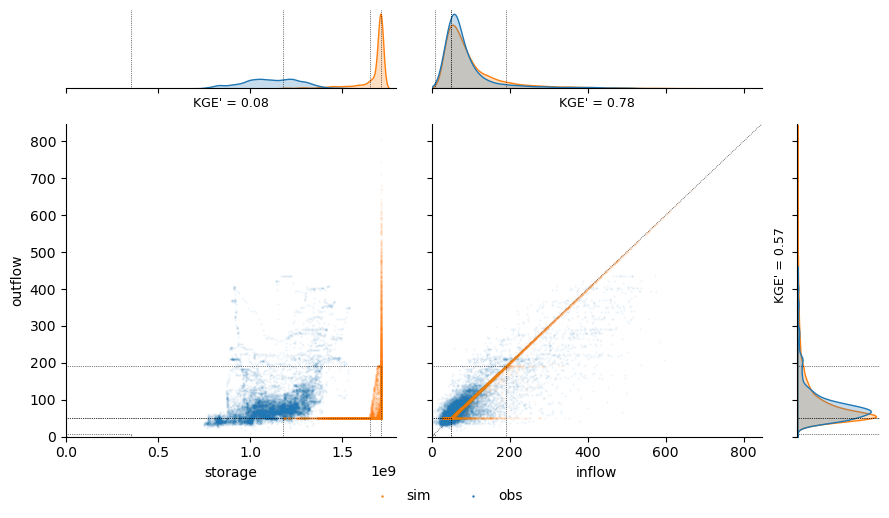

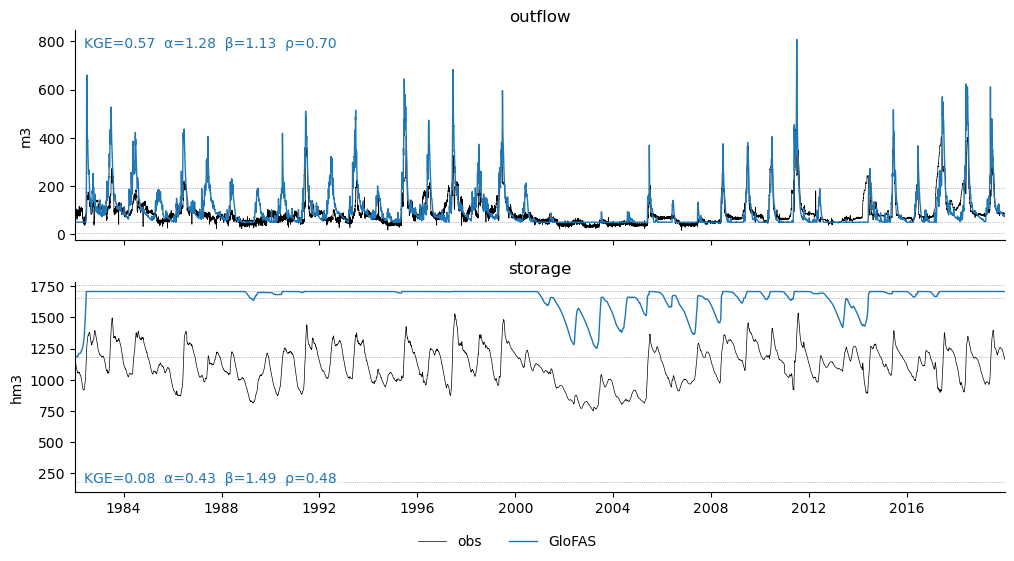

In [115]:
sim = reservoir.simulate(sim_glofas.inflow, obs.storage[0], routine=1, limit_Q=True, k=1)
reservoir.scatter(sim, obs, norm=False)
reservoir.lineplot({'GloFAS': sim}, obs)
#reservoir.lineplot({'GloFAS': sim_glofas, 'Lisflood': sim}, obs)

## Calibration
### Setup

In [116]:
# SCEUA parameters
max_iter = 2000
complexes = 4

In [117]:
cal_days = timedelta(days=np.floor((end - start).days * .7))
start_cal = end - cal_days
end_cal = end
start_val = start
end_val = start_cal

In [118]:
# define train and test time series
x_train = sim_glofas.inflow[start_cal:end_cal]
y_train = obs.loc[start_cal:end_cal, ['storage', 'outflow']]
x_test = sim_glofas.inflow[start_val:end_val]
y_test = obs.loc[start_val:end_val, ['storage', 'outflow']]

In [119]:
# initialize the calibration setup of the LISFLOOD reservoir routine
setup = SCEUA_6pars(x_train, y_train.storage.iloc[0], y_train.outflow,
                    Vc, Vtot, Qmin,
                    spotpy.objectivefunctions.kge)

In [120]:
# define the sampling method
dbname = f'{path_out}/SCEUA_{ResID:03}_6pars_{complexes}complexes'
sampler = spotpy.algorithms.sceua(setup, dbname=dbname, dbformat='csv', save_sim=True)

### Launch

In [121]:
# Start the sampler
sampler.sample(max_iter, ngs=complexes, kstop=3, pcento=0.01, peps=0.1)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  2000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file '..\results\reservoirs\LISFLOOD\calibration/SCEUA_227_6pars_4complexes.csv' created.
3 of 2000, minimal objective function=0.369204, time remaining: 00:16:44
6 of 2000, minimal objective function=0.369204, time remaining: 00:19:17
9 of 2000, minimal objective function=0.369204, time remaining: 00:20:16
12 of 2000, minimal objective function=0.369204, time remaining: 00:21:15
15 of 2000, minimal objective function=0.338845, time remaining: 00:21:43
18 of 2000, minimal objective function=0.338845, time remaining: 00:21:46
21 of 2000, minimal objective function=0.338845, time remaining: 00:21:49
24 of 2000, minimal objective function=0.338845, time remaining: 00:22:01
27 of 2000, minimal objective function=0.338845, time remaining: 00:22:01
30 o

### Analyse results 

In [122]:
# read CSV of results
results = pd.read_csv(f'{dbname}.csv')
results.index.name = 'iteration'

# extract simulation
simulation = results.filter(regex='^simulation_').transpose()
simulation.index = pd.date_range(start_cal, end_cal, freq='D')

# extract parameter values and likelihood
cols = ['like1'] + [col for col in results.columns if col.startswith('par')] + ['chain']
results = results[cols]
results.columns = [x[3:] if x.startswith('par') else x for x in results.columns]
# compute KGE of each simulation
results['KGEcal'] = [kge(y_train.outflow, simulation[i]) for i in simulation.columns]

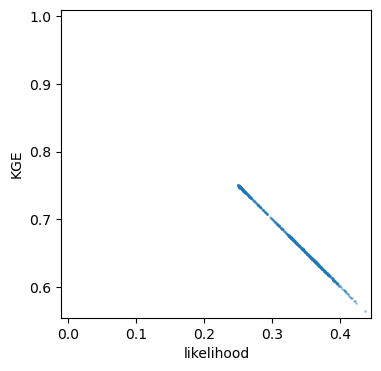

In [123]:
# compare likelihood and KGE
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(results.like1, results.KGEcal, s=1, alpha=.33)
ax.set(xlabel='likelihood',
       xlim=(-.01, None),
       ylabel='KGE',
       ylim=(None, 1.01));

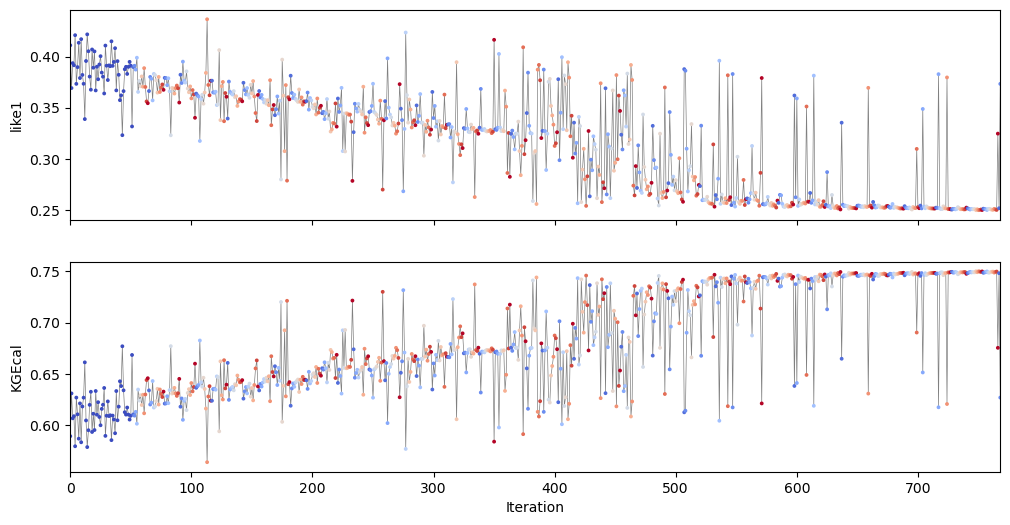

In [124]:
# Plot how the objective function was minimized during sampling
fig, axes = plt.subplots(nrows=2, figsize=(12, 6), sharex=True)
for ax, var in zip(axes, ['like1', 'KGEcal']):
    ax.plot(results[var], c='gray', lw=.5, zorder=0)
    ax.scatter(results.index, results[var], c=results.chain, cmap='coolwarm', zorder=2, s=3)
    ax.set_ylabel(var)
    if ax == axes[-1]:
        ax.set(xlabel="Iteration",
               xlim=(0, results.index.max()));
# fig.savefig("SCEUA_objectivefunctiontrace.png", dpi=150);

In [125]:
# # plot the evolution of each of the complexes in SCE-UA
# chains = results.chain.unique()
# fig, axes = plt.subplots(nrows=len(chains), figsize=(12, 2 * len(chains)), sharex=True, sharey=True)
# for ax, chain in zip(axes, chains):
#     aux = results.loc[results.chain == chain, 'like1']
#     ax.scatter(aux.index, aux, s=1)
#     ax.set_title(f'chain {chain:.0f}')
#     ax.set_ylabel('likelihood')
#     if ax == axes[-1]:
#         ax.set(xlim=(0, results.shape[0data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA+kAAAISCAYAAACwH44RAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/NK7nSAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd3hc1bU28Pec6SNp1Ht3t2Ub2zJuYNNN7yQQSEhygUBIucDNl4SQmwC5CaQBIQECIUACAUwvwQFMMRjb2Ni496beuzR95uzvj/HIkqZKGk2R3t/z+AGNzmi2NHPO2WvvtdeWhBACRERERERERBRzcqwbQEREREREREQeDNKJiIiIiIiI4gSDdCIiIiIiIqI4wSCdiIiIiIiIKE4wSCciIiIiIiKKEwzSiYiIiIiIiOIEg3QiIiIiIiKiOMEgnYiIiIiIiChOMEgnIiIiIiIiihMM0omIiIiIiIjiRMyD9EcffRTl5eXQ6/WorKzEunXrAh67du1aSJLk82///v1RbDERERERERHR2IhpkL5q1SrcdtttuOuuu7Bt2zYsX74c559/PmpqaoI+78CBA2hsbOz/N3Xq1Ci1mIiIiIiIiGjsSEIIEasXX7x4MRYsWIDHHnus/7GZM2fisssuw3333edz/Nq1a3HGGWegs7MTaWlpUWwpERERERER0dhTx+qFHQ4Htm7dip/+9KeDHl+5ciU2bNgQ9Lnz58+HzWbDrFmz8POf/xxnnHFGwGPtdjvsdnv/14qioKOjA5mZmZAkaXS/BBEREREREVEIQgj09vaioKAAshw8oT1mQXpbWxvcbjdyc3MHPZ6bm4umpia/z8nPz8cTTzyByspK2O12PPvsszjrrLOwdu1arFixwu9z7rvvPtxzzz0Rbz8RERERERHRcNTW1qKoqCjoMTEL0r2GzmYLIQLOcE+fPh3Tp0/v/3rp0qWora3FH/7wh4BB+p133ok77rij/+vu7m6UlJSgtrYWJpMpAr8BERERERERUWA9PT0oLi5GSkpKyGNjFqRnZWVBpVL5zJq3tLT4zK4Hs2TJEjz33HMBv6/T6aDT6XweN5lMDNKJiIiIiIgoasJZch2z6u5arRaVlZVYs2bNoMfXrFmDZcuWhf1ztm3bhvz8/Eg3j4iIiIiIiCjqYprufscdd+Ab3/gGFi5ciKVLl+KJJ55ATU0NbrnlFgCeVPX6+nr885//BAA89NBDKCsrQ0VFBRwOB5577jm8+uqrePXVV2P5axARERERERFFREyD9Kuvvhrt7e2499570djYiNmzZ2P16tUoLS0FADQ2Ng7aM93hcOBHP/oR6uvrYTAYUFFRgXfeeQcXXHBBrH4FIiIiIiIiooiJ6T7psdDT04PU1FR0d3dzTToRERERERGNueHEoTGv7k5ERERERBRLXWYFjZ1upBhkFGbIYRX3IhorDNKJiIiIiGjCsjsFth51wpNfrEAlq5Gfrop1s2gCi1l1dyIiIiIiolizOQUGLgC22CfUamCKQwzSiYiIiIhowkoxSEhP8qS3a1TgLDrFHIN0IiIiIiKasGRJwoJJGjTsehMnTwKMOq5Hp9hikE5ERERERBOaJElwWHsA4Y51U4gYpBMREREREbndbrhcrlg3g4hBOhERERERkcvlgtvNmXSKPQbpREREREQ04bndbgbpFBcYpBMRERER0YTHdHeKFwzSiYiIiIhowuNMOsULBulERERERDThcU06xQt1rBtARERERIMJIWA/ugOuziao0/OgmzQXksS5FaKxxJl0ihe82hMRERHFGXdnE1ytNYDLAVdrDdydTbFuEtG4xzXpFC8YpBMRERHFG0ka8gC7bERjSVEUCCE4k05xgVd8IiIiojijSsuFJn8yeu0uqPMmQZWeG+smEY1r3uCcQTrFAwbpRERERHFGkiToSivw+p4m6MtmQ/KZWSeiSHK73VCpVEx3p7jAIJ2IiIgoTtnt9lg3gWhCcLlc0Ol0nEmnuMAgnYiIiChOMUgnig632w2tVssgneICg3QiIiKiOCSEgN1uhxAi1k0hGvfcbjdn0iluMEgnIiIiikPeYEFRlBi3hGj8886kc006xQMG6URERERxiNWmiaKHa9IpnjBIJyIiIopD3hk9zuwRjT2mu1M8YZBOREREFIc4k04UPUx3p3jCIJ2IiIgoDnmDBQbpRGOP1d0pnjBIJyIiIopD3mCBM3tEY49r0imeMEgnIiIiikOcSSeKHs6kUzxhkE5EREQUh9xuN1QqFYMGoihg4TiKJwzSiYiIiOKQN/2W6e5EY4+F4yieMEgnIiIiikOc2SOKHpfLBa1WC0VRYt0UIgbpRERERPGIM+lE0eN2u6FWqyGEiHVTiGIfpD/66KMoLy+HXq9HZWUl1q1bF9bz1q9fD7VajXnz5o1tA4mIiIhigIWsiKLHWwOCKB7ENEhftWoVbrvtNtx1113Ytm0bli9fjvPPPx81NTVBn9fd3Y3rr78eZ511VpRaSkRERBRd3BKKKHoYpFM8iWmQ/sADD+CGG27AjTfeiJkzZ+Khhx5CcXExHnvssaDPu/nmm3Httddi6dKlUWopERERUXR516Qz3Z1o7LlcLqjV6lg3gwhADIN0h8OBrVu3YuXKlYMeX7lyJTZs2BDweU8//TSOHDmCX/7yl2G9jt1uR09Pz6B/RERERPGOM+lE0cOZdIonMQvS29ra4Ha7kZubO+jx3NxcNDU1+X3OoUOH8NOf/hT/+te/wh7puu+++5Camtr/r7i4eNRtJyIiIhpr3mrTDNKJxh6DdIonMS8cJ0nSoK+FED6PAZ4T59prr8U999yDadOmhf3z77zzTnR3d/f/q62tHXWbiYiIiMYa092JoodBOsWTmC28yMrKgkql8pk1b2lp8ZldB4De3l5s2bIF27Ztw/e//30AgKIoEEJArVbj/fffx5lnnunzPJ1OB51ONza/BBEREdEYcblc0Ov1DNKJooBr0imexGwmXavVorKyEmvWrBn0+Jo1a7Bs2TKf400mE3bt2oXt27f3/7vlllswffp0bN++HYsXL45W04mIiIjGnHcmnenuRGNPURTOpFPciOlw0R133IFvfOMbWLhwIZYuXYonnngCNTU1uOWWWwB4UtXr6+vxz3/+E7IsY/bs2YOen5OTA71e7/M4ERERUaLzFo7jTDrR2HO5XAzSKW7ENEi/+uqr0d7ejnvvvReNjY2YPXs2Vq9ejdLSUgBAY2NjyD3TiYiIiMYjzqQTRU+8r0mvabTjT882w2YXuOkr2Zg3wxjrJtEYinnhuFtvvRVVVVWw2+3YunUrVqxY0f+9Z555BmvXrg343Lvvvhvbt28f+0YSERERRRm3YCOKHm+QLkkShBCxbo6Pv7/Shqp6BxpbnfjTP5tj3RwaYzEP0omIiIjIF6u7E0WXJElQqVRxOTB2YvMrAT8bYdE4wyCdiELq7nHiwccP4b6HD6ChyRrr5hARTQjeIF1RlFg3hWjCiNcg/carslGQpSA9xYXbrvfdCYvGF+4zQEQh/f6Rg/j08zYAwP5DvfjHnxfGuEVEROOfy+WCVqvlTDpRFKlUqv6lJvGkKE+L71xmR2trK+ZOnxnr5tAYY5BORCE1NtvgnchpbrXFtjFERBOEEAIajSYuZ/WIxqt4nUkHPAN3HLSbGJjuTkQhfftrpVCpAAnATd8oj3VziIgmDFmW4zZgIBqP1Gp13J5zDNInDs6kE1FIpy7Owh3/ZYFOZ8B55xbGujlERBOGxApRRFHlTXePR06nE06nM9bNoCjgTDoRhcVq6YZK5o2BiIiIxq94T3eP17ZRZDFIJ6Kw9PT0xO3IMhEREVEkxHu6O2fSJwYG6UQUFkmSeGMgIiKicS2e0925Jn3iYJBORCHZbDYkJyfzxkBERETjWjynuzudTvbFJggG6UQUUldXF7KysnhjICIionEtnoN0rkmfOBikE1FIXV1dyMzM5I2BiIiIxh0hRP//x/uadJVKFetmUBQwSCeikLq6upCWlhbrZhARERFFnNvt7g9+431NukajiXUzKAoYpBNRSAzSiYiIaLxyu91Qq9UA4jvdXVEUyDLDt4mA7zIRhdTT0wOTyRTrZhARTRjsjBNFz8CZ9HhOd6eJg1d/Igpp4AgzERGNPa49JYqegedbPKe708TBIJ2IiIgozgwcHJVlGYqixLhFROPX0DXpnEmnWGOQTkRB2Ww26HS6WDeDiGhC4cweUfQkUrq7JEkctJsAGKQTUVDd3d1ITU2NdTOIiCaURAoaiBJdIs2kq9VqDtpNAAzSiSiooZXdB+4lSkREY8PlciVEtWmi8WDo+RbPQTCD9ImBQToRBTUwSGdHkYgoOhJl32ai8YAz6RRvGKQTUVADg3SNRsMbAxFRFHAmnSh6Eml5iVqthtPpjHUzaIwxSCeioHp6evrXpPPGQEQUHQMLx8V70ECU6BIhc0VRFMiyzAmTCYJBOhEFNXA2h0E6EVF0DNyCLV6DBqLxYmjmSjxWT/e2kenuEwODdCIKG0dviYiig+nuRNEzNN09Hvs6DNInFgbpRBSQ3W6HVqvt/5oz6URE0ZFIa2SJEl0iFI5zOp39QTr7YuMfg3QiCmjoHumcSSciio5E2hKKKNENDNJlWY7LIN17TWBfbGJgkE5EAQ3dI52jt0RE0ZEIM3tE48XAQTFJkmLcGv+Y7j6xMEgnooCGBukcvSUiio6hRTsZpBONnYGDYvHK5XJBo9EwSJ8gGKQTUUCcSSciio1E2BKKaLxIhCCda9InlpgH6Y8++ijKy8uh1+tRWVmJdevWBTz2s88+wymnnILMzEwYDAbMmDEDDz74YBRbSzSxcE06EVFssLo7UfQkQpDONekTizqWL75q1SrcdtttePTRR3HKKafg8ccfx/nnn4+9e/eipKTE5/ikpCR8//vfx9y5c5GUlITPPvsMN998M5KSkvCd73wnBr8B0fjmTa3y4ugtEVF0sLo7UfQMHBSLV1yTPrHEdCb9gQcewA033IAbb7wRM2fOxEMPPYTi4mI89thjfo+fP38+vva1r6GiogJlZWX4+te/jnPPPTfo7DsRRQ5Hb4mIooPV3YmiJ1Fm0rkmfeKIWZDucDiwdetWrFy5ctDjK1euxIYNG8L6Gdu2bcOGDRtw2mmnjUUTJ6R1n7fh2Zdr0NRii3VTKMYcDsegWXTAE6RzJp2IaOyxujtR9CRCkM416RNLzPI62tra4Ha7kZubO+jx3NxcNDU1BX1uUVERWltb4XK5cPfdd+PGG28MeKzdbofdbu//uqenZ3QNH8fe+7gZv3pgPyQJePmtOrz0t8XQ6+P7gkVjZ+h6dAAcvSUiihJWdyeKnkQI0rkmfWKJeeG4oXsRCiFC7k+4bt06bNmyBX/961/x0EMP4YUXXgh47H333YfU1NT+f8XFxRFp93i0e38PZBkQAujocqK51R76STRuDa3sDnAmnYgoWljdnSh6uCad4k3MgvSsrCyoVCqfWfOWlhaf2fWhysvLMWfOHNx00024/fbbcffddwc89s4770R3d3f/v9ra2kg0f1w6a3k25OMDJLOmpaCowBDjFlEs+QvSeWMgIooOt9vN6u5EUaIoSkLMpHNN+sQRsyBdq9WisrISa9asGfT4mjVrsGzZsrB/jhBiUDr7UDqdDiaTadA/8m/e7DQ8ev8UXHRaE/5y/zyoVMEzGmj8qqm34N2Pe9DSoRv0OFOsiIiiw+Vysbo7UZQMPN/i1cA16eyLjX8xzeu444478I1vfAMLFy7E0qVL8cQTT6Cmpga33HILAM8seH19Pf75z38CAB555BGUlJRgxowZADz7pv/hD3/AD37wg5j9DuNNmgnITO2BVhPzlRAUI63tdtxw21ZYbSqs+ewYHvt9Giqmewa3WKyEiCg6hs6ks1NONHaGrkmXJAmKokCW46c/7E13V6lUUBQl1s2hMRbTIP3qq69Ge3s77r33XjQ2NmL27NlYvXo1SktLAQCNjY2oqanpP15RFNx55504duwY1Go1Jk+ejPvvvx8333xzrH6FccfhcMDhcMS6GRRDh472wWpTAEhQBLBzb/egIJ0dRSKised2u/sDBKa7E40tIcSggNx7zsVjkE4TQ8zf6VtvvRW33nqr3+8988wzg77+wQ9+wFnzMcYgnWbPMCEzXYv2Tgd0OhlLF2b0fy9UUUciSmxCCNT/9c9oe+s1GMonY9Kv/wBNenqsmzVhea+5THcnii7vOTd0K9pY8q5Jp4khfoaHKC44HI6ga/xp/DOlaPDsIwtxwYp2PP/YySgrTop1k4goSmxVx9D2+suA2w3r0cNoe/v1WDeJwJl0omiLx3OOM+kTC4N0GsTpdMLhcEAIEeumUAyZUjQoL7IjN1sf66YQURTJBgMgSRAAIARUycmxbhIhPgMGovEsHutAMEifWCIapDc3N+Pee++N5I+kKHM4HNDr9XF3YSIiorGny8tH6U/+F+asHKRecAmyLr481k0ieNLeOXhOFD3xODAWb2vkaWxF9J1uamrCPffcE8kfSVHmcDiQnJzMdekTXLxVNCWi6Ek/8xzsOW0l0q6/ATLXPxLRBBSPQTpwok4FB+3Gv2HlTOzcuTPo9w8cODCqxlDseYN0u92OpCSuRZ6oHA4HtFptrJtBRDHC+iRENJGxWCPF2rCC9Hnz5gVMufI+zurPic3hcCAlJYUz6ROcw+FgBVGiCYw7fRDRRBaPa9JpYhlWkJ6ZmYnf/va3OOuss/x+f8+ePbj44osj0jCKDYfDgaSkJM6gTHCcSSea2BikE9FEFq/p7l6SJHFp4jg3rCC9srISDQ0NKC0t9fv9rq4urpFIcE6nE9nZ2eycTXDBgnRZluF2u6FSqaLcKiKKBiFE/04fREQTUbynu2s0GrhcLk6ojGPDCtJvvvlmmM3mgN8vKSnB008/PepGUew4nU4kJSWxczbBBQvS1Wo1XC4Xg3Siccqb4sn7ABFNVPGe7u7tizFIH7+GFaRffnnwrVjS09PxzW9+c1QNotjT6XSwWCyxbgbFkMPhgE6n8/s9tVoNp9MZ8PtElNi4y0fsscYPUfT4ywKO93R3b5BO49eoFjI4HA4cOHCAH5JxRqfTsXM2wQWbSfemWBHR+OR0OhmkxxizlYiix9/abgbpFGsjCtItFgtuuOEGGI1GVFRUoKamBgDwwx/+EPfff39EG0jRp9VqWThuggsVpDudzii3iIiihTPpsed2u6FWDyvZkYhGyF+dnXhbk64oyqDsGm9WI41fIwrS77zzTuzYsQNr166FXq/vf/zss8/GqlWrItY4ig2tVsvO2QQXzpp0IhqfvLt88D4QO5xJJ4oef4Ni8bYm3eVyDdoal32x8W9Ew7RvvPEGVq1ahSVLlgwa1Zk1axaOHDkSscZRbDDdnTiTTjRxeWfSgxWKpbHlb2ZPkiSuVScaA263O+7T3V0u16CBBC49HP9GNJPe2tqKnJwcn8fNZjNvHuMAZ9KJM+lEExfT3WNvaIcciL+ZPaLxwt/5Fm/p7kPbyL7Y+DeiIP3kk0/GO++80/+1NzD/29/+hqVLl0amZRR13pF7BunEmXSiicvhcMBoNPI8j6FEWCNLNF74O9/ibVDM6XT6BOm8Ro9vI0p3v++++3Deeedh7969cLlc+NOf/oQ9e/Zg48aN+OSTTyLdRooSh8MBjUYDWZahKEqsm0MxxJl0oonL4XDAZDLFuhkTWqCZdAbpRJEXKEiPp/ONM+kTz4hm0pctW4b169fDYrFg8uTJeP/995Gbm4uNGzeisrIy0m2kKHE6nQEDM5pYOJNONHEFO/8pOhJhZo9ovEiEzBWuSZ94RjSTvnPnTsydOxf/+Mc/fL73xhtv4LLLLhttuygGBnbMWFtgYvN3w/JSq9WwWCxRbhERRQsHbGOPM+lE0ZMINSD8VXdncc/xbUQz6eeeey6OHj3q8/irr76K6667btSNotjwprsDgBAixq2heMWZdKLxjTPpsZcIM3tE40UipLtzTfrEM6Ig/bvf/S7OOussNDY29j+2atUqXH/99XjmmWci1TaKMnbMKBxcB0U0vvFeEHuJMLNHNF4kQpDONekTz4jS3X/xi1+gvb0dZ599NtatW4d3330XN954I5599llceeWVkW4jRcnQjhn3YyV/OJNONL45nc5BWVW8D0RfIgQNRONFImSucE36xDOiIB0A/vSnP+Eb3/gGlixZgvr6erzwwgu49NJLI9k2irKB6xC9J//A9S9EAEdvicY774Ct91znfSD6EmHfZqLxIhFqQLhcLuh0uv6v2Rcb/8IO0t966y2fxy677DJ88skn+NrXvgZJkvqPueSSSyLXQooah8MBg8EAAP17pbNzRkNxJp1ofPPOKvE+EDtut3tQhxxgujvRWEmEzBWn04mkpKT+r7kmffwLO0gPVrH9qaeewlNPPQXAUxU8nj7UFL6Be+NqtVrY7fZBFwSaGEKlt3L0lmhi8AbpvA9EXyLM7BGNF26326cOhyzLcXW+cU36xBN2kK4oyli2g+LAwDXp3s4ZTTwD16P6w3VQRBMD7wOxkwhrZInGC3/nW7zV4uCa9IlnRNXdaXwaGKTrdDp2ziaoUJWdmWJFNDEwSI8dVncnih5/51u88bdPOq8H41vYn8iHH34Y3/nOd6DX6/Hwww8HPfaHP/zhqBtG0TewcJw33Z0mnlBBuizLEEJEsUVEFAsM0mMn0BpZvh9EkefvfIs3Q/dJj7d0fIq8sIP0Bx98ENdddx30ej0efPDBgMdJksQgPU7Y7W6o1TJUqvBSdpjuTgD3SCYiD94HYidQdXer1RqjFhGNX4kQpA+9JsRbOj5FXthB+rFjx/z+P8Wnp16owtPPV8NkUuOBe+Zi+pSUkM8Zmu5usVjGupkUh+x2+4iCdEUR+GRjGxwOBWecmg2thqtpiBLNwMKRDNJjJ9BMOtNbiSIvEYN0Gv/CfrfvuOOOsI6TJAl//OMfR9wgGj2L1Y2nn6+GANDT68Lzr9Xinh/PCvm8gRcArVaLrq6usW0oxaWRzqQ/+vRRvPhGHQBg/eZ23PuT0J85IoovAwtH6nQ6mM3mGLdoYmJ1d6LoSYQAeOiadBr/wv5Ebtu2Lazjhpt+8eijj+L3v/89GhsbUVFRgYceegjLly/3e+xrr72Gxx57DNu3b4fdbkdFRQXuvvtunHvuucN6zfFOq5GQlKSC2ewCICErI7yAa+AMCgvHTVwjDdI3buno//9NX3YEOZKI4tXAfdE5kx47gaq7cyadKPI4k07xKOx3++OPP474i69atQq33XYbHn30UZxyyil4/PHHcf7552Pv3r0oKSnxOf7TTz/FOeecg9/85jdIS0vD008/jYsvvhibNm3C/PnzI96+RKVWy3jg3rn47Z82YlJZFm64rnzYP4OF4yYuh8MBvV4/7OeduTwbT79QDQA4/ZTsSDeLiKJgaAFRBumx4Xa7OZNOFCWJEKS73W7IMpcRTiQxHZJ54IEHcMMNN+DGG28EADz00EN477338Nhjj+G+++7zOf6hhx4a9PVvfvMbvPnmm3j77bcZpA8xa5oJZy5qQmVlIYyG4V942DmbuBwOB0wm07Cf919fK4Va1KLPbMctN0wbg5YR0VhjAdH44HK5uE86UZQkQpAOsFjcRBOzIRmHw4GtW7di5cqVgx5fuXIlNmzYENbPUBQFvb29yMjIGIsmJjyLxTLi4m9Md5+4RpruLkkSCnPtKMo1h72jABHFFwbp8SHQTDrT3Ykiz9/5RhRrMftEtrW1we12Izc3d9Djubm5aGpqCutn/PGPf4TZbMZXv/rVgMfY7fZBads9PT0ja3ACstlsI96uhZ2z8WPn3m6YLS6cPD8D6jCC53CCdEmSoCiKT+qVxWLhFkFECWzomnSn0xn2c4UQADjbEwkDa8R4Md2daGwkykw6TSwxHzYaehPyd2Py54UXXsDdd9+NN998Ezk5OQGPu++++3DPPfeMup2JRggBrVY74oBJlmUoihLhVlG0vfhGLf7y96MAgLNXZOPu/xe64no4Qbq3gNHQ46xWKzuRRAls4Pmv0WjCDtJrm9147A0zLDaBq87Q49S5urFs5oTEdHeiseFveQlwoi8cr2vBJUkKO26ixBOzT11WVhZUKpXPrHlLS4vP7PpQq1atwg033ICXXnoJZ599dtBj77zzTnR3d/f/q62tHXXbE4HD4UBqaipsNltYx7Mgxfj04aet/f+/dkNbWM8JJ0jXaDR+0y7j+WZGRKENPP+9HcBwvLPBhl6LgMsNvPyRDYoS3vMofJxJJxobgfou8X7OcceH8S1mvWmtVovKykqsWbNm0ONr1qzBsmXLAj7vhRdewLe+9S08//zzuPDCC0O+jk6ng8lkGvRvuI7VmHHPH/bhgb8eQm9fYpwMFosF6enpYQfpAyv60vixaEF6//8vmJMW1nPC+Syo1ephpcESUWIYaU0Ko14ChAAgoNdK4MRO5MV7wECUyPzNRsf7OccgfXyLabr7HXfcgW984xtYuHAhli5diieeeAI1NTW45ZZbAHhmwevr6/HPf/4TgCdAv/766/GnP/0JS5Ys6Z+FNxgMSE1NHbN2/r97dqGlzbOu3Wp1467bZ4zZa0WK1WpFUlJS2GvwR9oxo/h2w7VlkJVmNDV34kc/PDWs5zidzpAFVELdGJh+RZSYRjpge/lpenR0dqGj245vXVrM838MsHAcUXTF+znnnTAxGAyxbgqNgZgG6VdffTXa29tx7733orGxEbNnz8bq1atRWloKAGhsbERNTU3/8Y8//jhcLhe+973v4Xvf+17/49/85jfxzDPPjEkbhRBo73BAUQAJQHNbYuwdbrFYYDQawz5+YLEgGj9kWcLUMgeStN3Q6cIvihKqg+1vraqiKJAkqf97HPQhSjwjHbBNMcpYMqkGx44dw6SC8jFoGcmyHPbyAyIaPc6kUyzFvHDcrbfeiltvvdXv94YG3mvXrh37Bg0hSRJu/mY5Hvn7EWi1Er51dUnU2zASIwnS/XXMOCOa+EazFV8g/m4MNpsNBoMBarUaVquVQfoY6bUCu2sBjQqYWwpoY34Vp/FkNFlVZrM54tcaIqJYiZdijd5JkKEC1Qei8YHduzBcc1kxFOsmFBcXYMHc9NBPiANWqxVZWVkAwgu0/XXMvIEYZ9gTm8ViiXgxN38z6RaLZVCQPpZLUCayj3YDPRbPbJrVIWH5zBg3iMYVf1lV4Q7Wms1mzvQS0bgRL+nugfZx50z6+MYyzGFyOsywWc2xbkbYvDPpOp0urP3O/aUnc6/08cFut0Oni+x2SP5uDN7PnMFg4F7pY6jPBghIEPDMqhNF0tB7wXBmkqxWK9dGEtG4ES/p7oFqBbGI7/jGID1MiqKgr68v1s0Imzdg0uv1YQVM/mbSww3wKf7JshzRG02gmXQG6WNvXpnnvxIE5iTG6htKIEPvBVqtFnZ7eLVYFEWJm/RQIqLRipcg3eVycSZ9AmKQHia9Xh/2dmbxwGq1Ditg8pfiOJzOGcW3cD8H4aaqciY9diqKgaSOf6NcvRnFWbFuDY03Q/cLHm5GFc//0eOSAaL4EC+DjoGCdK5JH98YpIchEYunOZ1OaDSaYQXpTHcfv4xGY1gFncKtQRBsJt1oNLKTPsbMvR2wWnpj3QyaAIZ7Hwj3WkOBKYoClSr83TiIaGzEy5r0QH0zzqSPbwzSw2Cz2aDX62PdjBEZTZCu0+k4k57gvOuYkpKSYDaHrqkQbmVnzqTHlsvlCuv9JBqtcIN0bzYWg/TRc7lcDNKJ4kC8pLtzTfrExCA9DGazGUajEbIsQ1GUWDdnWMKd1WThuPHJu+wh3I5zuEG6v5n04S6xoJFLtOU3lLjCvQ9YLBYkJSUxSI+AQJWciSi6mO5OscQgPQxms7m/85Fos1ejnUlnkJ7YBqagRzJI9zd6a7Vaodfrwy5WSCPjXTPMdasUDeEG6QPvkwzSR4cz6UTRE2gPciC+0t1ZOG7iYZAeBm+gk5ycnBAV3r3r0YHRBeksHJf4vJ/dSKe7+xu9FUJAlmWoVKqEyzhJJN73lCgaGKRHn9vtZpBOFCXBzrd4SXfnmvSJiUF6GLydj0QJ0i0WS/9eteEG6QMDey+muye+sZpJ95fuTtHR19eHpKQkAKwCTZHlb0Yp3PuA93MZ7oAgBRZo1gwAJEnieU8UQYkQpHNN+sTEID0MiTaTPnCmLdzUY39BOgvHJb6BM+mRTnfn6G1smM1mJCcncxCNIm40g7UDZ9K53GV0EiFoIBovgp1v8dLX4Zr0iYlBehgSbSbdarX2z6SHu3bV3zZzDAISn7foYbgz3yNNdw+2posiy3s94owlRdpotuL0fi65TGr0gs2kM0gniqxEGBSL9Jp0IQSau9xo7HRDUZiZE68YpIchkWfSR4NBeuIb7mdhpIXjBg4MAUyHH0tMK6axMppdPrzV3TlYN3qJEDQQjReJMCgW6TXphxpd2FXjwp5aF3bXciY+XjFID4M3cElOTk6ITnGkgnRWd0983m3RwhVukD60ONzQzxwrvI8db7p7uEsYiMI1mpl0u90e1rWDQgsVNDC9lShyQqW7x0OQHmxN+kiuB229J2bP23tZ6DdeMUgPkyRJCTM76C9IH0mhmUTcF54GG7rGNNTnINwgfaihnzmuSx07THenseJwOPzWJgl3sJaz6JHBmXSi6Al1vsXDoFik16TnpZ0I/3JTGQrGK74z4xBTj8kfvV4fcq1opIL0cHcVmMhcboHHXmzBd++pwour28MeSPOe30ajkUE6RZS/838k9w/ec0Yn2Ex6vBSyIhovEmFQLNA1QZblEbWvPEcFZ+uXsDR+gZlF/q81FHsM0kNIxK1OGDCRP+EEdQzSo2fd1l6s2dCD5nYXXnq3E/uP2sJ+riRJnEmniPN3/oez5dfQwqMGg4FLMUYhEYKGiUgIwMU//biTyGvSR5q9JEkSulur0ddewwyoOMYgPQS73Q6dTtf/dSLsSTi0oxUqYHK73ZBlfhTGm6Ed63D2SmeQHj1D7/vuYVZYZZBOkTbS839o9hbrJYxOIgQNE43FDryxGXj+M+CzfZ6AncaHRNiCLdCa9NHgrjzxj5FZCEODj0Sp8D50ViNYwOSvoi8lPofDMWiAKZwg3d8+yeFgkD58py1MwaLZOqgkGy48zYSKKYaQzxk48MLdFyjSRhqke7d69OJSjNFJhKBhojnYCPTZPNffoy1AJz/e40aozJV4qM3kdrsjGqQrigJZliFJUlz8fuQfg/QQvEWavBIlSB8oVMDkr1jQQKFSHZ97pQZnXrEO1353M+qbGJjFC4vF4jO7FarjPDRtNVxDq8gz3TU0jUbCNSvdmJv1Oq44UxPW333gjCVHwCnSRjpgO/Q+Gc6AIAXGmfT4Y9ACAsfvkQB0XMY7biRC4bhIz6R3d3fDZDIlzK5VExWD9BASdSZ9oHCC9EAds1DbT3T3OPHXfxyDw6mgrsGK516pHXV7KTL8VVwfq46z1WqFXq/v/5oz6eHp7OxEUVEROjs7wzp+aDBEFEmjmUlPTk7u/5pB+ugEmzWLly2hJpqp+UBZWjccXUdwegWQpA/9HEoMoQo1xsP5FmwgYSQ6OzuRnp4Ok8mE7u7uiP1ciiwG6SEk2ky6y+XyOZFHE6RrtdqgFcE1agkajQRAQAggJSlyFxEanaFB+lisEx2YZTF0iYXNFn4htImqs7MTkydPRkdHR1jH9/X1DboehVPUiyhcwbKqgn3OOJMeWf7u417xMrM30cgSkIpqtOxZhZyU4LukUGIJFgDHUzp4JLPnOjo6kJGRgdTUVAbpcYxBegiJNpM+tIAPMLo16aHWvRqNavz6zgpkp1uxZIEO37y6dGQNp4gb65n0YCPMTMkMT2dnJyZNmhR2kD50xpIZCxRJgQZsQ80mMUiPLKa7x6fOzk6UlpaGnflEiSFUkD4eMUhPDAzSQ0i0mfShgRkwupl0nU4Xcm/tpQszsGzObly+UkGSkQu14sXQz4Jer4/o7HYi7HQQ7xwOB/Ly8tDV1RXW8f6CIa4no0gJNGAbarCWQXpkhSocxyA9Njo7O1FeXs4gfZyJdCp5Iujq6kJaWhqD9DjHID2EaK7rjYRIB+nhVJC2WCzIycnhjSvODP0shEqNHm7atLfKMLfwGzkhxLCqNff19Q2aSec2bBRJgdLdNRpN0PvA0GsNA8nRCTWTznT32LBarSgoKGBfZ5wJdr4liuH237z7rqekpKC3t3eMWkWjxZ51CDabbVBBrHjZjiEQf0F6qDYHW4cYTpDe0dGBsrIynuhxxt9nIZjhbvGh0WjgdDr9LrGg0AYOjoW7tnzojCWDdIokIYTfAbdQ94GJOBM1lkJVm+YASGxIkoSMjIyECdLtDgV/e7kFv/xLPbbu4X0ikES/fg13W8aBfQ0OqMY3BulhSKQ1KSMJmEab7t7R0YHMzEwWsIozww3Sh1vZ2XtjCPQ6TIcPrrOzE2lpaQDCX0bjrxggg3Qaa+EM1lLksLp7/PFugZVIM49vftiFdz/rwa6DVvz2yUb0mvm58WeiBencJSZxMEgfoXgNSIcbmAGjKxwHeIKNjIwMAPH7d5mIFEXxufEEC5yDZVT4451JD/SZY4X34LxboABARkZGWMXjhs50MkinaNDpdCMK0qN5PxA2M9y1+6H0hleEMZ6xunv88a7hlWU5rrMpB+q1uOGdYnK5PTPr5GuiBekD++ze5wfqF7ocdjjt7MfFCoP0IAJ1MCJdgCuSRhKkj3Ym3RtsJCUlxXVRPQpeU2G4M+kajSboTDorjwc3kiB9qLHYVo9oqGBbcQYKKKN5nxR2K+wf/QvOre/D8dHzULpaovK6YyXYTDrT3WNj4PU6nrblCubi09OQlqIAEDhtgYKs9PAH4SeSRF+TPtysxY6Ojv7PMgCYTCb09PT4HGfubEXr0X1oO7YfvW1NEWkrDQ+D9CACzTDHc4V3q9U67NTj0RaO86bYp6enh12lGgB6+1yoa7By9j2KIhmkez9TDNJHZrhBur/zhNXdKRqC3QcCpU5Gs8iq0tUMOI4PCAgFSmttVF53rCiKErAYJ9PdY2NgYGMymRIi5T0nU4OrT6vGg/+jQ6Z6M/taAcT7TLoQIuiy2+HOpHu3X/MKVOHd3NE24P9bw/75FDkM0oMwm81+g494DtJtNht0Op3P48ECptEWjvNePNLS0sIuqLJ7fw8u/9ZGXHPzZtz9+328eURYoIt6sPTokcykM0gfuZ6eHqSmpgIA0tPTQ547DofD59xmh52iId6DdDktB9B4zg0BQM4ujsrrxgLT3WNj4KBqONfreNHe3o6iokIUFhbi2LFjsW5OXIr3ID3UTL83qzFcAz/LQOAgXWMwQggBIQQ0ehYHjoWYB+mPPvooysvLodfrUVlZiXXr1gU8trGxEddeey2mT58OWZZx2223jWnbAgUf8RykA/4L3QULmIKtSQ+V7m632/ufO5yZ9LfebYDD6UkX+3BdK9o7WJQokobuSuAV6Zn0UOnuTMUObOBsWTiDYX19fSz2QmNGUZSAszXxHqRLOiMs8y/AXlU23jebIKVmR+V1Y4Hp7rExdFB1JMuTok0I0V+bZvHixdi0aVOsmxSXEj1IH+5Mus1mG1RgOjU11W+6e1peMaqa2lDT0gEpKd3n+zT2Yhqkr1q1CrfddhvuuusubNu2DcuXL8f555+Pmpoav8fb7XZkZ2fjrrvuwkknnTTm7QvU+Yj3IN2fUEH6SGfSB6aADWcmvawkCYoCSJKAKUWNlBSulYqkQIFzsDXMI51JD7TEgjPpgQXKdAiWUcKKrNFl2boezb++He2P/xbuPt8OzHgz0mVPow3SFUWgx6LA6R5dNlVDRzdUJbOQWliGqqqqUf2seMbsmdgYWIg1UWbSe3t7kZycDMBzPmZkZKCuri7GrYo/w91+NtrCCdJHs5OOyWTyO5MuyTKONbQgv2wKduzcOeKfTyMX0yD9gQcewA033IAbb7wRM2fOxEMPPYTi4mI89thjfo8vKyvDn/70J1x//fX9I5pjKVFn0v0JFjAFW+8SKkgfWCVyOEWsrr60CJecLaO8oAV/ue8k6LQxT+oYVwJ9doOtYR7pTPpIllhMdH19ff2dJ6+kpKSgfy9/zwEAWZbZaY8wxWpB53N/gaulAbZ929H73muxbtKYi0WQ7lYENh92YvNhJ9bvd8BiH3kxrsbGRuTl5aGyshJbtmwZ8c+Jd5xJj76hg6fDrb8TK01NTcjPz+//eunSpdi4cWMMWxSfQs2kh1PRXyhuCNfYbDnr3f4vkOHMpNvtdp/+WqBlkN5re0lJCerq6hKiWOJ4E7PIyOFwYOvWrVi5cuWgx1euXIkNGzZE7HXsdjt6enoG/QtXsJn0eCzW5Ha7AxabGWnApFKpgp6YA2fSh7OfvEolYUpxKy4/V4O0FKa6R1qwID3SM+nA8JdYTHRD14QBoVMo4yGteMIQCnC8Yy4gAGX8B0Uj3Yoz0OcynEHbHotAn83zd3a5gaaukXcC29vbkZWVhZSUFGg0moSY6RwJrkmPvqEDpCPdkjDampqakJeX1/+1yWSCVpeET7e0oq5l/F/TwhVsy0Mg9Dnn6m6Decu7MG/5Dxz1h8akfZFakz60sjsQuO/e0NCA/Px8SJKE8vJyHD16NPxGU0TELEhva2uD2+1Gbm7uoMdzc3PR1BS5Uv/33XcfUlNT+/8VF4dfUCZQoKPX6+My+PBWWfdnrAKmoVUih7M1ic1mQ3l5ORobGyPerokuUNFDo9EYtIDgSGbSA+E+6YH5C9JDVXgPtCade6VHnmxMhm3FRXBodLCl5yJl5eWxbtKYG2kB0dEMHhl1EmQJEMJzz0gxhD/QO9DAtbcAcPLJJ2Pz5s0j+lnxjunu0efvep0ImpubB/WxFSGwt2sZXvpUi/uf68OOQ2Mz85uIQlVPD3bOOesP9g/kOur2R7wQssvlCnht9rYv3CA92Gd5aLsbGxv7MzFOOukk7NixI8wWU6TEPMd46IkRaquB4brzzjvR3d3d/6+2NvytWSwWi9/ORyTbF0nB9kgfqyDdbDYPGmEOtLZlKG/6Tn5+PoP0MRDosxAsVXI0M+n+sDMZ2EiC9KHnmheD9LGxySYj996/YvPUxVClZoR+QoILdv4HO9cDFakMZzBbp5EwNcuCnqZ9QPc+ZJtGVrypp6cHKSkp/V8XFhaira0tIWY7hyuc1FuKLH/Xa61WG7SobjwYmh3T0ydQ3+bpv0oSsP0wg/RwhFpSJumMEPAMgkga32vhaEVyTfrQiTUvfzHCwEyMlJQUKIrCrL0oi1mQnpWVBZVK5TNr3tLS4jO7Pho6nQ4mk2nQv3AFm5mOR7GYSR86qBLuWi3vCG9WVhZaW7n/YqQFG7AJZCQz6TabLWiaGLfW8y9QunuwFN1Ag4YM0iOvpqYG2dnZMBqNUKlU4zLYGyrY+S/LctBz2d/AdajneLU3V2NagQZN1bvDb+wQQ9feAsDcuXM580MRMZLrdaz5qxWTkiQhJ93T7RcCmF4Sv8XS4kmoCQddaQVqLUB1lw2GmUsiPpEXyTXpgWbS/VV4HzrIM2fOHOxkAbmoilmQrtVqUVlZiTVr1gx6fM2aNVi2bFmMWjVYsFn94aR1R0u0Z9L9je6FW+HdO0LnXfM+lsFcS5sd3/3xNlz57c/x/trmMXudeBKo4nowI5lJ7+3tHfbrkOf9GTr7GGp5QKDiNgzSI2/Tpk1YvHgxAKCkpGRYGViJarjnf6TU1taipKQEKSkpw6oZM9DAtEyv6VkmFG96HX1P3gPnkV2RaCpNUIkYpA9NdQcAlSzhjmuScNVpaszJ2oIlFdE/3xNRqDXpklqDbY29qHYnodcR+bggkmvS+/r6BmUdeQ3dK93fksmpU6fi0KFDEemvt//nbRz95Z1oe+etUf+s8Sym6e533HEHnnzySTz11FPYt28fbr/9dtTU1OCWW24B4ElVv/766wc9Z/v27di+fTv6+vrQ2tqK7du3Y+/evVFvezx2jIMF6YFGAgfu1RyMv5Oyq6sLaWlpgx4LdyZ9YBpNoD0aI+Xvz1dhz4EeNLfZ8euHDsBmi/8UbCEEvtjWgQ/XtcA+gou+vyDQK1C65Ehm0ru7uydckC7cLljffQ69T/wC1o9f7V9PO1yRGm2Px2tRImttbe3PwAKA8vJyHDt2LMatGnsjCdIj0Vnr6emByWTq7wCOREtLC3JycgY95trwDozCCcXaB9tHr4y6nYnEUXsULQ/chZYHfw5ng/8tbSl8Q/eVBuI/SPc3cAUAyQYZp1cmIVXbGpMChEIICHdiFT4MtaOCt2J6SUkJqqurI/76kVyTHmjycehSVX+fH5VKhemF2ejYswmuzpHXDuvbuR21D/4OPRs/Q92ffo++ndtG/LPGu5gG6VdffTUeeugh3HvvvZg3bx4+/fRTrF69GqWlpQA8H5Khe6bPnz8f8+fPx9atW/H8889j/vz5uOCCC6Le9njchm0sZk97ep3YeyQZG75o8/mev7UtaWlpYQXp3o4ZgDFfl+4pTAQAAnFaTsDHi2/U4fZf7MIvf7cPd/7f8NNAhRDDrvQf7Dn+aDQa9PT0BF0SMh4rEbsO7YDr0A7AboVr9+dw1xwc1vOdTmfAG65Opxt2sT0G6ZG1YcOGQdlcubm5aG4e/xk4IwnS7XZ7wMFAIPRaTm/nVpIkTJo0acTVg/12YtVaeC/4kipx0noVRRn1AF7nc4/AWXMEzurD6Hze/5a2seZy2GHt6YR7jLatGmvxHqQPrew+VGlpKaqqqqLXIABKdxvs7z4J+9uPwrnv86i+9miESnevr69HQUEBSkpKfGKWSIjUmvRgVeyHzqQ3NDSgoKBg0DFuSw9mGh3Q9rbAdmAz3L3tYf4GgznbB8cTzjbf+II8Yl447tZbb0VVVRXsdju2bt2KFStW9H/vmWeewdq1awcdL4Tw+TcWF5pQJ0U8BukWi2XYa+iDVfR1uwW++5Pt+HiTCT/51V68/d7gQNrfVg56vT5kMRVvJ8TbERnrIP2Ga8tQmOtAdoYKl5xlh14/suJE0bR+04mL3xfbOqEokVsOEGyv9OFQqVQhB4bGZYX3oR1+eXgBgL8MFK9AHb9ga9K41V1kCIcNPfXVcNjtyMrK6n9ckqQRDZ4kmmBbsAUSqLK7V6jPZn19PQoLCwF47h0ul2vYg3qB7nv606+AumgKOlVGaM+9blg/M5bcbnfQvkc4hMt1oo8Uh0Gw02ZF67H96GqoRtuxA1D8vOdCCLiO7oBjy7twN8UukyXQtXc0yzOiIVANE6+pU6fi4MHhDTCPluvwl4Ddcx11H9gM4UiMa2qoyYa6ujoUFxf7BLqREqk16cH6HkMzWpubm30GeYS1DxL6xz6hWEYWA6UuPRW2PM8AgFJcCtPSU0f0cyaCmAfp8SrQFlZe0QzS65us2LilHRZr8DTtSM+kd/U4UV3rqeQoScDWnV2Dvt/Z2em3SmQobW1tyMzM7P86JycHLS0tw/454UoyKrjinE68/o/lmFRkTohq8qcsPvH3OXl+OmQ5cikAkdpXW5IkqNXqkEH6eAsg1ZPnoCG1CFatEa2FM6Eqmjys5wfbAiVQhfdA268B4RfoosDcrfXoe+r/IL32F5yp6vD5e45VGmM8CTZg6zX07xLscwmEvtbU1taiqKio/+uRzO4FmjGUUzNgvOw7qJ93Lqot8b/EySvUns3hSL36Jti0Bti0RqR+5cYItSxy7OZeb3obFLcLDpvvZ0RpOAzXzk+g1B2E8/N/Q+mLzax1oMAmnq+74XyGMjMz0d7eHtXfwVMFXUAIQKjUvgPecSpUuntjYyPy8vIgSdKYbNEcqTXpwfoeQ7fZ9BcbqFKzIek913u3rIEqfWRFvps7O9Fy5bWY+cq/see0lZCDZGONlhACtW1u7KhyorEzce4DXgzSAwhVHTtaQfru/T247rtf4P/dsxvf+Z8v4XAGXv8abB0y4H80MNjsSUaaBnNmelLShRA4bVnWoO93d3cjNTXV53mhUm+GVuIdznqakdi3bx9mzpwJADjnnHPwwQcf+KzJ7u5x4he/3Yvv/ngbvtge+xS2qy8txIWnNeOq8134wX8Nb39Wt9sdNG09KSkpYttoaDSakEH6eNuyw+lyYYsqC5k3/gIbLNphp6aOJEgPtP0aRYZzzybA5emgaBuOQPQMfg8CrUt3dHSh5u8vo/2TTVFp51gKle7ur6MaaiY91LVm6LrHadOmDXtdeqC1t14zZ87Evn37hvUzR6KzT6C9Z/QBT6ACkcPRqDai8ZIb0HTpDahH8IGXWNAak+H9SwlI0Oh9MyGEpRcn/poCwhqbzEV/GYNe8bodXmtrK7Kzs4MeI0kSsrKy0N4+spTlkZCnnYxDdi1cmYVYbzMBcvxnNQLBg3QhxKDlNsXFxX4LjbrbGtH37O/Q9/d74Tw8vArpkVqTHmj7taECxT+SWgPj3NNhzq/Alh41ZO3wg2shBNauXYvTzzgDOlMq8vLzUV9fP+yfE672PoEDDS609ijYU+tCtyX+ztdgJmyQ/tQLVUFHEIN1Ptxugbfe78PfXnDiw3VjNwMMAJ9ubIXi9rSzqtaCo9WB05RDrSnW6/U+KZvBOmaSJOGhX83F/f9bga+e14plCwdvXxeo6Fyoden+Zj6Sk5PR29sb8DmjceDAAUyfPh2Ap9NYUVGBL774YtAxTzx7DGs3tGL3vh7c+evdcDoV/OfDJnz7v7fivocPwG6P7ghcQ0MDFs3PxLVXzcH+fcNbkx5q68BIpbsDmJAz6Tt37sScOXOgUqmQlZU17MyMkQbpwYIhGh05PceTGixJgFYHyTB4QCQrKwttQ9bNKU4nNpx6NXbd8nN8fvb1qH/h7Wg2OeJCBelDZ1qA0J/LYNcaIQQURRk0QzSS2b1Qa2/T09PR09MzpsHU1sMK/rpawRPvKvhsz+heJ9SsWTh27dqFOXPmYO7cuaPaMsnhFPhspwOf73HAHcElV1qDEXurm+BUG7DtUA1Uat8ARFU8HTZ4/g7dqiTImQU+x0RDsIxBk8kUtZR3xWGHdfsmOKpCD2KFOie8wk15tzkEPj/owMe77ahuHfmEyoHDR2Atm4+UFVdCl1eKXbsSY9eFYGvShwa+gdal29f/G6K7DYqlF7YPXhrWNS6cNemhgvQjTcAxczk63QUI9NLeQaeGhoaAA5+SrEJOySQ0No2sTsvhw4eRl5fXX5OqsrISW7duDeu5dqfAx1/asXabHU5XeH8/u2PwcXZnfGa/BDJhg/QXX6/D3oOBg8JgnY//fNSEF95owdFaGXf/fh9qG8ZupnDurFR47416nRt11dvR3mnDqjfq8OG6lmGd6P5mNUN1zHQ6FU5dlIUzVswYdEENVtwm1DZs7e3tg9LdAc+69KamkVeLDKS3txc6nW7Q7zh//nx8tK4Od/xiGx7/51F0d/fi6LF6CEVAALDb3Xji76/g1w/tx6GjfVj9QRNeftv/SF9vnwtr17f2LwswW1x48PFD+MVv9+LQ0ZGP/O/duxezZs1CTk4O2tvbh9XBDJUFEql09x17urD7aAm27w1cgyBaQboigPUHgBfXA+v3AxHsTw4ihMC+ffswa9YsAJ7P0vbt2/23yWaD9dgRKEOySgJloACB35u+vr6gM+kajWZC7OU9VqwlFdiXXAzt7CUwXvFdSNrB+wtLkuQTcNoaWmA+VOX5QpbR9sGGKLY4PMJugePzt2Ff+yLczVVBjw21Jt1fkN7XFzpID3StGbrsCfD8nb2BerhCFa8Dxr5I1pZDwu//j8RoZ9KdTifMZjPS0tJgMpngcDhGXE/hmdUWvPiBFc+9Z8XLH0fuOu52u9HU2oaSKdNhczj8BroWN/C+LR3ac2/AR30G9Jljk5EVbFA1WsXjhBBoe+RX6Hj6AbQ++HNYtqwLerw3/TqUsrKysJbxVLW60GcTcCvAoUY3HGEGSENt374d8+bNAwAsW7YMO3bsSIiip8HWpNfV1Q1ashNw+aZK099fH+4wXqg16aHS8dt7Pf0jh5yNfU1G1Aa4vHonyxobG32Kxg0kSdKIajIoioKNGzfilFNO6X8sIyMDVqs1rH7iP1Zb8OpaG1752IZ/vR/e9Sg3TYbk9nzGVO5eZKYkVtibWK2NsGDLfIMFOp1dzuOFEyQIAXT3jF2qdnpyM/7rq8D3b5iEZx9ZiuwsE771/XX4y1NH8Mvf7cPzr9Wiu8eJ79+5HU++kodnVgW+4BqNRp8TIZx1iMCJlEHvRaanpydgoBFsGzZvMZuhM/DDKR7ndouwBye8we5AnV1OvPtZFjZv68azL9fgvgfX4utXFaKwwAC9XsbtN0/FRRdeAMD7ARGorW2CEAI79nTj4/WtsDsU2Gxu3HD7Vvz8/r24/vtbsGNPNx556jBef6cBH69vxe2/2Dmigm9CiEFFO8rLy4dV9ThUkO4vBTVUivxQNfUW/PBnO3GoOgv/e/8BfLmry+9x/j5zY6Gu3TNS7HABR5qB2jEqFlpTU4OCgoL+G2Zubi7a29t9l5G0t2Hvt7+GAzd/Cwe++224B/y9g3XCAw18jTatGACEosDlsMdkHeUnX/Ti2z87htvuq0FDiwNCCGzc7cArH1tR0zy6LBUhBJRR/k6frFuH0vO/Cv3pV0CVXej3mLKyskGBnqEoD/KUkuONUJB7yVmjakMoDqcLLR196O6zhf0euvZuhNJUBaWrBc7Nq4NufRTqXjAwSBdC4PFVLfjz64X43TN2dPf6fw+DBem1tbUoLi72eXzatGlhF7QKtyL9rFmzxjTlPS8dAAQgFKQZgxdODWW0M+kHDx7E1KlT+7+uqKjA7t3D3yEEAA7Vnfi8HKyJXDZZVVUVysrKAAALFy70yWwDgE2bNmHR4iWQDUk4/fQzfIoIR8vAnWiGilaQrph74Rwwg27btSXo8V1dXQEHFgZSq9VQqVQhB3FUkmeLHCE8n3GMYNvRhoYGZGRkQKfzDICqVCqcffbZeP+996D0dceswGE419JgQfDQIF2WZb9BvWrp+WhVJ0POKsC21CnYti38bcdCXRMkSQr6e9gc/QcCAKwBxvO9he/CycQYzpaZiqUP3W+/gEN/fwizJ0/yuWaHm/FzrPHEe3C0Iby4S5YE6nf9G6fOUKF212pIGFlfQQgB14EvYF//OlxVe0b0M0Ziwgbpy+bbYekN/AEL1im+aGUeyks8QVDFFBdmTUsZkzZaLBZs3boV37z2VFxzWTHycw2YOm02Onu0/VuKrX5/L/7vDx9hx54u2B0ynnyuCnUN/oMif7Oa4XZy1Go18vPzUVdXByD4Oq1gM+mBbni5ublhzaQ/+vQRnH75p7jm5s1obA49O3D48GFMmTJl0GO9fS54rrcSZFlCSeksnLJkGl58fDE+eHk5rriwEKXFyfjm1SXQ62XMmmbCggo77rr3DXzvp9vxv/fvxW13fYk1H+9EQ5OnDYqi4Ml/rMOuPTVQhKcwSk+PE2738C8ITU1NyM3N7Q/Y5syZM6xO1khm0odb2bmm3gK3IiCOD2QcrfI/Gh5qJl0IgceeOYqv3LgJD/z1UNh/r5YugX986MYzH7hR1WjFnt2DL/ARrLM3yNatW7Fw4cJBj02fPh0HDhwY9FjX+k/hOr7NiL2mGn3bPelcoToEHT0KjvbMwSsfmWGxnTg21Ex6qG3Y3E4HWo7sRevRfWivOTzivd1HwuUWeOT5ZnT3uVHbZMcTq2qwZmMr/vW+FZ9sd+DBVX3os/pvjxBAsCQSh9ONg9Vt2HukGQ0t3f1/X+9gYDhaW1vhdrtDdkqGrkuva2iA5effRvljd0P/yM+Qd+nZYb3eSLgVBUdq29HS0Yfapi5094U3M9rX0wVFeM5SoYQOsoLVVxgYpB+rc+C99T0AJNQ2u/Heev8VjYMF6UM7t16lpaU+s3vmjha0HtuP7qbaQe+r91oZSmZmJjo7O8cs5f2ChTLS3DuwdIYC0fjGqGYHw63uHujzvXfvXlRUVPR/7e/6FK6p+Sd+jxQcCjpbNxwDB89LSkrQ2Ng4qI6N3W5HQ0NDfyCfn58Pt9vtdytEZ30VzBs/grvLd5lQJCiKEnBQNVpBumxMhpJ9Iv1YM21OwGO9n4twa6WEs/VhiqoTjt4GmIwyUkQDXn/tFfSZLejqtcJiCy+Da/PmzVi0aNGgx/Ly8jC/5yjMT/8f+p7+P7g7or/VZbD31ytYuru/woIFBQVoaGgY9NiOI9WwLr8SyV+7Hadd8020tbZi9yP3o+HOG9D+t99BcQQe3Au1Jj2UJFUPYPX03TOSgfIc/8d5g/Rw+oPD2TKz89lH0PfhW0javQnFO9b6fN97jQp1zy5NP/H5WDY7vIHM/fv3Y9q0adBr1Zg6deqIr4VKw2G49m2E0loL1/YPoXSN7VJnrwkbpP/yp2eisbERW7Z8ic82t2H77q5B3w8W6KSnavGPPy/ER68tx/mn9aKlZWwuLGvWrMFZZ5016AJiNKhwyiJviqCEb183HzOmT4Z31lcCoFb7vzj7C5iGE5wNXDsSrABFWlpawG0oAhX50Wq1Ifd5bGqx4fnX6iAE0Nhsw6o3auFyKXj+tVo8+PghVNUO7hh1dnYiJSXFp8NTUmTAJed62pCTpcMVF/qfObvp6+X44OXlePwPC3DuyuWwK+XA8VG4XfvNSE0B0kyeny0g4evXLMNP/nsxkoxqSBKwdL454HsRzMB0asCz7s1qtYadzhwqSPeXGj3cPZIXzE5DaZFn3XtGmsanqKBXqCB9y/ZO/OvVWjQ22/DaOw1Yu6E1rNf/92YFje0CjR0Cr3xqxdSiJMwqEkjWKUD3HuSlRj67pbe3F4qi+GSQ+BtE0RaXAgCEJEFIElolz6U21Iz4X98wo8lchE92OPHiByeCm3Bm0oMFBtaeTijHZ1GdVjMcFt9jhcsJx6Z3YPvPk3Dtj1whNAmAJ0nDc+64XXYcONYFHK/y63QBnb2+N2ezHXjjC+C5dcDnB/uLQQ/S0W2G0+XpPHX0WGGx2tHX3oymAzvQcmQvnPbQwewnn3yC008/PeRxAzOErFYrPvroI1x45RWY9q2voM00dtVpAcDpUvrXBAshYAkwFeJsroJ52wcw79uE91a/g229Ksgp6VBUGuxyp46qUNPAIN1okOF5Pz3vYUqS/58bLJOmt7fX74CtWwGmVCzE/mPN6DXb4LRZ0NPSAJfdBktXO6zdJ4KxcNfeAkBRUZHfgk6RoLgdyFIfxekn6XDh+WfjzTffHHFAG05lbpVK5XfAwfu3Hnj912g0SE1N9ampEEpXVxcM5o/wgyv1+J9rknD+UiNeeeUVNLU7sPOYgm7zyGakFEVBd3d3f/9BkiTMmTNn0Ezal19+iQULFgwKNE8//XSf2XT7sYNo+f2d6HrxcbT87sdQzJEtLhcqaAi1tC9SXG43PimYjeSv3Ii+C7+Orc7AAUrL0SqkJYc/cRRqRlQIgY8+XINT52Zh8VQtFs+bjFNPXY59RxpQ19yNo3Ud6AkxaNjb2wun0+nTZxRdbcjs9fSfhd0K5+7o750e7vnmL93dm300dEBk6Lp0RVGwf//+/n6dJEk4ffokpB/cBmHpg233Vlg+/yhoG0eaXeNwOPD222/iokVGXHsqcOECQBvgR6WmpqKpqSmsrZyHs2Wmo7EGEAokAK4m36WjKpUKhYWFQa/Pe/fuRVHSAfz4uiR8ZWkzUsWOkK8LDF5isWDBAnz55ZdhPW8ot80CgRP5tfXHjsDd3Q7bhy/D9umbEDYLhBAwf7YGHf94GNYQ2S7hSoz9D8aAJEm48MILceN/f4gDxzxr07/3X5Pwtcs96XehtjOTJAlajYSzzjoLb731Fq699tphV3n2x2ZzY92mdljMLTAYDP17yA70659VYOeeLqSnaVFekgSrLQt1jU4cOtqHqy8tQl6O/w6jwWAYdEPp6HTgg3U2TJnkwKRJImT709PTYbfbYbFY0NnZidLSUr/HBRt1bGpqGpSKN7R9QwPMrTs60dhsw2nLstHSUgdZElCEZ5lBTfU+3PWrI1j/pQGyDHy4rhVvPLMEarUnINqzZw9mz57t8zqSJOHH35+G/75pMrRaOez3bdmibGz60jP4UDHDhOWnzMOsmQ58trkdU8qTMHuGJ3h75/lT4HIq2LXrS6xbtw4rVqzw+Vlf7upCd48Ty07OhE47eKysvr4eZ5xxxqDHZsyYgf3792Pu3Lkh22mxWAJ2XIUQePrFarz8Rg6ONO3HT74/DRqNDKvNDpUq/CDdaFTj6YcXoqrGjKICI4wG/ze5UNuRuIf0M8OZ6BJCwGy1QQgdIAHJKamYMsVz8184WcKePcDGjRv8/t3dbgU2hwt6nRqqYaT3K+Ye7N6yCQsWLPD5nl6vh1ar7V9rLoTAx9W1mHbT92BqbUbSoiX4rLEFR37zEPCXF6FRqdCVX460Rb7vZUeP4slOEAI1TRYIYUS3Beh25cKpqAPWaQ4VpHf19kGF4zPMAFyKgG7IMe6q3VAajwAAXPs3Qc6bBCklA+7aQ5D0RqjySsL6Ww3lcjlQWbYX9b1zkZmuxfeuLYfDJeGPL/bBageyknuwZf3HMJx+Lg406pCsB+aWS9hfB/RaAUDCwUZgRiGQNmScQqVSedIwj3/9/nv/weIZZZAkCYrLCXN7M9IK/F+nAE/KdVJSUlipoQCQae5F/dtv4PPuPpxzzjn9a6EjNcM4kMMl4HQJGLTAjm1bIenTYUzyBLVfbFqPs85YAYNeB8Xtglqrh3BYYT/mCXSEzYx5xbnInbOk/+e5NmzAli1bcPLJJ4+oPQODdI3Ug5MnH0afmI1pZQacs8x/OrBWq4Xd7jtDZLPZAq4jb2zrgd6QDKdLwdG6NtTu+wKVM8o9v9fxSsr9xzY2+ixnCmTWrFn48ssvA963RqO6uholJZ7zIycnB/Pnz8dbH+xAVskCFKQDk/OOL2PqViCEZ52kHOC+E06H3Jt+OzS42LNnT/9OJgPNmzcP27dvx9lnh5ft4Xa78e9//xsXXXQh0tOPXykKZsAuUvD0BwAkAZ1G4KbzZCTrJTR2AioZyEn1ZNQ6XAJmu0CKXoJaNfj3rKqq8nkPKioq8MILL2DBggVQFAWHDh3C17/+9UHHpKWlITs1BY3vv4LMvAJoKhaje+cXEMc7/4q5F876Kuim+d7zRypUBpNOpws5uRAJn376KU4+ZTlSp0+HSQjsevVVNDc3+2SR7Pmf36Dq4X9ASklC9weTkLqgIsBPPCE1NRW9vb0Qwn8fcMeOHSgvLx80oJaVk4NO64lBn16LHabkwAOVW7Zs8clAAwDJkASoNZ5lOEKgprMXU4XwjMi6XJCGMXEwUuHUgJBl/+nugdZuFxQU4PPPTww4eGdzBy0pHHCOCwBSkO3ohhukCyFQ1wY4XQJfrn8bp556alhV3VNTU7F///6w7xHewYhJkyYFPKa5uRl7UvIws9PzeUk5+1K/x500dTo23Hk/7DNnoOyH34LGlIzOHhcOVduRrO3Arl27cNVVV0GlUqE4ZyqeffZzVFZWBp1cam5uRmpqav+9RqfTISsrK2AW10BCCCjWXkiyDLNTYPXnO3Fupgl6Ww9ETimO9TggPfcQTIodkAB7Vzuc2ZNgf/lJQJJg3bYBOT/9AzR5wV8nlAkbpAOeYO1wjRbeGZ4PP23C1y4vhqIIWG3BK6V7paSkYNKkSdi5cydOOumk/sfdboFnX67B/kO9uODsPKxY6n+mcaj/uXsXduzxBII/vGmG32PUKgkL5p7oVBr0KvzyR7435oGEENi0zYEvd9iRV2hGaZERt/50O+oaFGBtC6BKwVcvCf1h8t7sOzs7/e4dGkpLS8ugohEDeYvHeU/4/3zYhF8/5ElNeeKfe/Hd61y49ydz8ca7LSgrTsJ3v3kqfvXAHkhSJxQF6Op2os/sQlqq56StqqrCsmXLArZFpxverNKVFxaipMCA9k4nTluW5dnCJFOHy84ffJFWqySoVSosXLgQ77zzDvbu3YdkUymys3Qw6FV4+a06/OlvnmBo0fx0PHDviWCttbUVWVlZPjfLmTNn4s033wwrSO/qsgQcCd17sBdPPV8NQI13P2rG7BkpKCk04ie/2g+HQwuXqhEXnRN4O6OBtBoZ0yYHH7GXZTXauwScTgUaje/5NHu6DrMm96C+NQMF2X0oL/IzwysEPtziwPbDTkwvErA3v4+y1HLUqk8ChCfVdKBZs2bhpZde8sn2cLrcOFLbDpdbgVolY0pJFtSq0Oe469BWuPasxzwBaMr8D37MmzcPe9Z/ikVLluKjLV+ipKQEswYE9BcDePemxXC1d0GSJOy549c45bNVPj/nwmV6vLrWBpUsoSK/GU89twFt+gugqE7Bk+8puOlcGQadb0cqKSlp0EyZ262gs9cKlSyh+uhBHDx4EOeesQJwO9Fnd+HV19/ApZdcgmStDEmlhqQ1oKW1Femif9kaPvr4I8x1tMHQUgUA0J1+BbRzlvq8tuJwoOeLz6FOS0NyxeDPp6IoePPNN3HNZUt91h/fe6MJ3X0KcjJMqK+T8PR7NrhkDQAJX+48CBX6gPRKQAhIEqD1k5WSmWbEnj17UVxajpyMZMyefCmaD+2GIhRACDgDBM/ulmq4DnwBc3M7lp/9Fb/HDNX16cfIf/V5tAIoz8pB/teu6f+et+BOSkp4M1gWu4DVDmSkeNcTegYk9FrPLEdHn4Jtx5wQArB31yFTI7BwzhTY7C5oNSrkpi7E2g/ex4IZkzwj+1oDDh2twoLj8YQkST7X56VLl+Lll19GcXFx2LPPA3mDdIfDgXfeeQff+/ZlAdfqDuSCES63GBSs1dXV+R2APt7649c/AY1agwsuuRS9rQ2wdnfApQCr13yEiy+5xJNKP4ytCbOzs9Ha2howGAE815qDv3wI9f96C1lnn4LZf/kl7IoK/17bBadT4KLT02BK9r1vVFVVDbr/5xTNxBctQG+LwLEWCXqNG702BXXtnlHI9l4Zs0t8h9yEokB22mDSayAUBVKAPoh3Zm9oB/XgwYP4yld8P8+FhYX4+OOPA+7I4rXnkBW7Dlng6NmJRQsX+gxeOdX5gOTpL9mdwPotR6FLLURtp6cTPL8MmJIvsOmQAy43oNcAS6ZpB733e/fuxdKlg68jarUaxcXFOHb0KLq7uzF79my/7Ty56xBEax1sB4ADX2xAozoNs2QZUBS49UZoisoD/m4DNbU58dZHXTAly7j87HSfgXLAE+BsO2SDZAw8qONyC+hSS9DW40Zmity/NlgRon8Q2OWww9zZCpVag6SMbAASXG21UCy9UGcVQZXkv7ZPf1ubmtDd3Y2zzvLUvJAkCeeeey7efPNNXHvttf1/J0d7J6oe/gcAQJitOPbwPzDvmd+F/Fv0WgTaDRfij6+5sHy2Counn/hbWCwW7Nq1C9ddd92g52jVKug0KtidnuurUe9/+NjV1QJH4xGk2dpQWrLc5/uS3gjjZd+BY88myOk56FGS8NaTf8XCo1sASx9SzrsKpvM9n2e3xQJZp4M0iqKKQgh09AEphhP3k1BBusXqgA1GGDNK0NZlRtaAkeJAwZ5Go4Hb7e7PxNi2bRuuuuqqQcdoi8phuuRamDd+jAZZB6l4GvzlyrW+vw7qx15BQ5+E4m9d6ffa9eVBJ/Z3zsfabXacNk+Lz/cLrN3lee2C5FNRXh7efuaKpMG0ikpk5gS6Ng82depUbNu2bVCQLhQ3bGtWwXV0NyzpBfjInYZLbrkDepcDgIAq1f9gwbEf/h/k1WtxUPoQ3V/uRemTf8Lt99fCYlOgUTnx0J0X9b9PkiRh4cKF2LJlS9A+/ubNm7FkyZJBjy1evBgfffRRyCDdUbsfzgZPhsn2ZgvOOvd8pGVlQShuSLIKKwD07lsDKJ5sMnNTHerrO5APQDr+vtvbWhikj9bCk9Kw6UvP7LLJ2IzX31yDF99JQX1jPvbV7Mavf1bhMxI81KJFi/Dcc/9CkqkU6WlGZKZrsfqDJjz5ryoAwIYv2rHqb4uRn+s70tjWbkdNgxUV01L6C5N5bf6yG1+9JDK/5+oPm/HnpxohSRK+3LMV3/uGQF0D4OkQAbv39YT1WlOnTsXLb+xAr1mHM89WkBVgcM47gzo0WAy2tib/+H6J3hN+87YOHK9Xgo5uNU5efCqyMnQ4/ZQTQeRXLinFxi3dsDsULJwr4Z1/v4wu20l4871OpJsKcOFFLqSnRW409uT5oUcjvSRJwjnnnIuvf/cjNLa2wJSixm/vKsfqNSfWtW7e1jmoA+uv0B3g+XuqVCqftOdjNWaYLS7MmmaCIoD/vX8P1n1uQOl/juAv96cgPXXw7z44fU9gy5ateHaVHlabFoCEPz95JOwgPRSrzY1bf7INh47m4qPNX+DxP8wf1B4hBFavfgf3/GQ58vPz4XA4sGrVKmSkpw4Krg/VuvHGOk86XVUj8NUVp2LFwsA3Hc/f/RysWbMGX/3qV/tvan0WO1zHp+5dbgV9FjvSUkKndbkOfXn85wLuw9ugLvddD5h5aBu0761C03vPIXvBGZi/cqXPMdqUZLg7uwFJgsowdB7b44wFOiyaqYEsSzDoZmP9nun4dI+n/WYbUN8BTPHz9hgMRpgt9v4ApLqxExabZ4bH5lbhqquu6u/MpQK4+OI0HNv4Pqak6yEAbG9zQDGmY3HBFKCrGeryOViUMwXSs7/ufw3nwe1+g/Rjd/8MvVs86fFFP7gDWRdfjra1n6Nn2z4cyTZg2uwZfguEGXQSDMcHynLzC+GSvWkUAtqUUlxzhgHbjwHVjT3I1LbCqJvs8zP6envR0VKL0089MfKfXlSOvvZmuAXw3ifrcf75qYOqiAuXE87P/w2huFGqBtS1e4A03w7kUD1fbIL3giS3tcDR0gJdvmeAzlv4MpwgvbZV4IVPFLgVYGYxcOkSFdbuAWrbAbUKOGOmHVVNFgjFAEgSdKlFWDBrElSyhCSD5/zJycnB0sp5sPd1H5+6tGLKzApoJRscjYehMqZCmz94dsObPbb+haeQnKmFJqcI2iXnhd3pVQ7VoKeuAf/efwArVqwIGaArisCLnyqoU12Ex95RcP1ZMlKTPJ/l2tpaTJs2ze/z8rNSUNeswK0oyM8yQZZlpOYWITXX09k5MyMPa995AytKU3FheRKczVXQ5JaFbL8kSSjIz0P97h0onFkByc+2Xx2fbcHh+/7qaeNTL0OqmIzVhrOwebcDEoC9R6z4v//27XS1trYiJ+fEQs8T2b+e3/eT9VuRWTAZKq1nQKG12wVAA0UIOJ1uaDQqyJKErqZaaBUHtDoZXQ3VSA8QdA4tZCUcdnTXHEaKQe///qoomL5vB3Z97RVknXkOCm661WcA4FC1Db/4S/3xQbEinH2mb3BamiNBJXuqfGvVAtkpTuztUPfngG471IUj+w8iKW8uJEmCzQl0mhVkm1THm6Ggq6vLp6o/ACycXAClbjfSFIHkWb7XGQBAe4OnvgKAsiQN5lxzI5znnQ9H7VGs3nMYqU4Xgoe8nvvOPY/Uo7XDBQGgx+zGd77iu0j35c8UVLdkAMhA3iEFC6fKPj/ny2NOmIoWYnuVC9PyVchLk3Csvh1Ol4LUZD0Kc0xorzkM5XhRNKfDAT1ccFd7dspxNlchacE5gOKGu/YgJEMy5PxJkCQJ7o5muDua8fGGL3HxFYMDvJSUFMyePRub//EUypMMSD/9bBxtboVi0EG2OwAhYCgNb8u6jfsFrO4UCEj4aIfA7FIBs13C/nqgqa4Op51+hs+AiSRJmFSUiV6LHbXVVdi1/aBP5ppwOWA7sBlCKJiSroOr6Si0hb7nvCq/DIb8MgDAQgBF2z+By9IHCUDPu69As+wctP7tUXS8/x9osnMw5Q9/hmxIxt4f3QdbfROm/OxWZC73P/OrCAFF8UyceK9H1S2ewdDrz5SRaZJCBuktnX39v3NTWy8yU439fYqGhoaAs87Z2dloaWmB3W5HTk5Of8G8gVLOuhQpZ12KVKsVL730Eq6++upBGUbmQ1XYfPF3oBECu9Zthy4rHbkXDy5Q2tDmxlP/tgDIwysf29DaeBh15kIAnntRqzW8CUKrzYn6lh4UFJfDrkjoNduRkuS/nzLwd2xtHbxE0VW1D66DnqJ4xtZqXHHOUuiSkgC/QxAn9OzY5wluhUDjhi14/9m1sNg81z+nW4OD1QryB5ymM2fOxHPPPYeFCxf6nU23Wq0wm83Izs4e9Lh38HpoLQEhBBSXE7Las3zB2XRivf380hwkZ3n+jtKAJWO6pefB/ulbkGQZOWdfidzsIrQ+VAt3WxNcBWV47YsdWFRVC/HaKsjGJJT++OfQl5TCNYydKiZ8kP6bn1Xgo/WtSDaqceriTDzy912ob+wAIGH95nbs2d+NkyrSgv4MlUqFmrYK/O2HOyDLwG035mLL9lpI0EBAgiKA9g6rT5B+8Egvvvvj7bA7FBTmqXDBqVUoKypCVZ3nAnBi7fnoHTraB8+AswSrTSAntxAnzzPji+1dAIBzTgtQSWKIDz5txbuf5QIQOPg/2/Di44v8jkJ790ofGKRbLJagW+Xk5ubig4+34aR5LkiwQy0OQYg0AMCMqSnI8BNsn1SRijf/uRQ9vU7k5+pxtKoD3/yhZ32wzabCi2/U4bvfCpyKM9YOV1nR2Or5nXt7nXju5T2YPzsDh6o8F/7CHBvsNgvUxwPv2tpaLF/uP2Bo7ZmEb/1wK5YszMcPb5yM99Y24/6HPVWQLzwnF0sX6LHuc8/eGjX1Vvznw2Zce8Xg4Khiugnf+Eox3vmgCfMq0nDX7Stwz+/3orWzHRBAWurIi5MM9cW2Thw66pkZb2iy4ZMNbYOyDjZv3oySkpL+GgVarRaXXnopXn3tTWSWnA9ZVuOsJSk4VtME7w0HAAxJoVOTMzIykFdQgo27W5CRkYFsow2bN3+Ookmz+2c71n26FksWzoNk64MkAabcYmh0vp9PkZwO0W6FLEmQUv2fk30fvwPA01ctqPdfmXrBvx7Enjt+DZVRjzmP3BOw7UmGE+dTeZ4a6/YoEPDMsOal+R7vcAkcaE2CKu9UbDvmRJa6GWa7ur8jkZ1T4NPJSktLgyb9+O8qBE4qzoLppNMHHWMCYCkoh7vBM6i0u8OM0qYmpFt74Kw7Bv3sSsjJqf0BOgAce/tN1DRZ0HjrvZ4HUoyoOPpJwN/VS6uWMKMI2F8HSJBw8gw9VDJQORmYW2LAqlUbIU6e5DOLsGPHjkEzmACgS0qBLsnzebk0IxdvvvE6LlwwDTq4oMmbhPqOXuS63f07dMAZXjVu0+Kl6HjP8z7rSsqgHRCU5efn4/DhwwEDz4G2HRXHd32QsK8WsDV9DEeGZ3mLy6Xg4y9qUZglA1rD8b+NJ3j3+ZsZjHCYPVvgyGoNcgoKPcuwCqb4HnycQbiwxFYLpU7AUXcYUpIJ2nmhByhqn3kVtTf9DACQvGweyr4aOvugoQOoPl5bp88msLNKYHmFBIcLaGrtwooV/mfzdVo1JhcHvvfl5OTgtBlFEOYuyJIEe/WesIJ04XBgxhfvAU21aErLQM4dv4EqdfC1xDqk89Tc1ISD6IUQWghIqG7wrQVgs9mg0+kGfTYLMoDMFM/WR6lG4Lxli1Db5kJVqyewdvTU49VXd2LWvGVwC0CjlqGTbJB626BVqwBIcFgDL18ZuKRMsfTB8uKDUJl7sFyfDGE915NGPED3+k+h3bIJAkDrq6uQsuBkmE5ePOiYo7X243UfPJkdVfUOFOQMvudmp0q44VwZDe0CpTkyTMYZ6NmN/i2dZpalYWr+Qmw54gQgIBQFnu6B5wM8cFmAj8bDkCUJGlmCq/4gtOm+A7GaisVw7toICYD+JM8Mmia3EJrcQpxeOgPvv/8+rrrqqqBL2BQBtHS4+ovv7j/cAaczHV/sF6hpduPkmRoUZQPVLSd+xqEGgYVTfX9Oj+VEnYhdB+txRGlCVl4JJElCd58NWz//FItnlPQf01BXA6WrBaXJx5c7KG5sWvcJKmx10Ng9yy7Vc1YA2mRY33wCEAIrDSYkGXzvSyXtLah54R9oBFD7r3+i59bbseT9f6Du0X/BWFaIKXd+N+DfYNDfVA2gf+hD4JVX34RceCmEJAPaqehSJPh7x1QqGWkpBqRWzMCrr+7xSb/3pLAr/dWSRJjXWUNWLvqOZxcpGg3ee+EFlL3/HwCAo60Vu5/8K/r2d6PvlfcBIdC1aQfOad4EecjgVE2zG4+8aobFLnDJqXpMynOiusVzTbU5BLYdceL0uVrsqdfCrJ+LbovnXB3Kk23n6TMMrAwuhAhay8ebCl5dXY2VfgbtB/3OBgPOOussvPPOO7jiiiv6P7+9R2sA5fjfUJJgPuy7/3p3n3dw2/MeSuo0TCvRYufx2ptl4U2i92edeV/bW+slGG/G1sBtCiX14L+HShtevZZJt30be390HwBg9s++h3lfOQ3bflcDt9tz/5ta6rst6sKFC7F582aceuqpg75ndwJbvtzZvxZ9qJMXLcb+I3UoLZGRnZEMWShoqz4It9MBSa3F1gNHMTvJiQy9ylPnK8X/5Jz2pFOhmVEJSHL/tq25P3sAirkXckoqrnE6sfsrF0OyWjyTJw//AcXf/wk+XXJ5WH8TgEE6dDoVzj/zRGdh2pRcAJ39KZ8Z6aFnYd1ugfc/8QRdiiLw+n+acNdts3C0rh51DVacfJIOWze/jWNVi/DK6j6kp2pw539PxztrquFwek6w+iY35lWej2uuScNnm9uRnqbFgjlpEfs9zz8zF/9+vxE2u4L5c9KweOFkLKoU2LmvB1kZWpQUBl5/P9D23d39wX5rmx2tbXYUFfjORmq0JuzZ14rc3DzIsoTaBguee2k/9NocKIqAPKT8thAC//fgUXyyMQMv/HsDLljRgBuvPwNXXm5EU7MNSyozfJ7jlZykRnKS56OcmprcP/suAOh0sa2NmJejh0Yjwe0WUBQJZ59xEs5ekY0lJ3eiq8eJGZMVvPLKK5hecQbWf9EL4cjym+Z3tNqMf73uuYm/vroBwtmILbtc8NR+lLD6gyaU5DgBeD6vQgBZGb6fXUmScPP1k3Dz9ScGLn506zQYDUdgsSm48bqyiP3uhfl6SJLn1qEIoL52J2rrDHjxzVb09JpRmlOLG7595aDnmEwmNDtOxdtvdAKQ8O7HB3HZij7MLl+IvVUCM8vUmDc1vIGEpPwF6DQrsLS5ccTciQVzZ8OUlok+ix0pRh0KMhahs/YwjDqtp1PVWIOsMt8g6+MOGUsKpsOUmgbV5Pl+X0tTUALHkf0ABDSFZX6PSVs012+KezAFmRK+ebaM+naByfkSkg2+50BjpxtWp+fxjj6Bru4WFBcVwH78Hptu8j0/JUmCbDRBsfRAkiRoUgMU/rv4BjgPboekN2JWbhk2vfQcZuxcCwlAx9vP47MZKzCtuBTqWk+PIG3xUtSt3wYhSZ5R8V4LzAer/K6/H+qypTIaOgCjDkhPPvF7ajQa5Obmor6+flCKmhACx44dC7h8BvDMOF1+6gIoTUfghgRXTztqbcnInroQqqNfQjKkQDXNd62kP2mnnoapf/orHI0NMC1eOmgNYW5uLjZsCG+f9IwkN4SQIEkCei1w/tnL8M52AbcbEJKMBXOmYFqBQF27AptDoChT5Xf9cnJmLmSVCm6nE8a0zLBqawiHrT8VTwBwmz3XlFBbMDa8vLr//50btsNtd0ClC35vNBk9uyx46iBI2Lv9M0i2IlSZy6HkXo7dtcBJZSGb7JdKnwS3xZN1JmmCz/Z42Y/sBZo8hYncXR3o2fwpkk5agvrHHoZis8F5zgXY3FyHmTd9FV1vfYiss5bhpLv/B9JWGx55wTPacMkZvvO01dXVPmusNSrggvmerY70Ws/fYXKeChnJMgSAjOTJaGxJR0fv8RlWl4LOznaUZpkAuyc4N6YFHqgYWMjKXbUP4vhgjcrWB1fNAWimD66dMbQAmttPsafc1E5o1U44XBpkpakxZ5r/LKPMFAmZKSc+aytmAcdaPGvSS7MBWZKxoFyDTrMCl6UZ77z1Ca666ipotVrs3bsXixcv9vtzJY0Wwu7y3DM0/jv2utMuh2bWIkhaHeS0wTNk2dnZyMrKwv79+33W5bv6zLDWNiF5Whl2796NGYXd2FdXALVKwrI5TjzyzKc43LsQkiSwfpcN8zM+QHr62ei0ebJFpuT7nlsqWUJGsoSOPk/20ryZRdBKmWhuP1G87sKLLoSlrQGWrnZIsowps+ZCDQXWPZ8BihtySgaKc/Oh2eHZHlAIoGb75+jr6EHZ8V0ZtNYeKF1tUGUOHtSy7N2N450xqK0WLJs5E/qSUmQv8X+PCmTpDAndZoH2XgnLZsoozroMr232XAskScAcIraWJAnnnXceXn/9dVx77bX9s9IHj9XA0ePCJJMaklYPTV54kyUpF3wVQlHg7mpDylmX4MLUbOx96yUItxuSEDDk5qFnUx08Wx4KuMwWKA6nT5D+/iYbLDZPjZc311mxomwTZOlMCCFBQELVwa1Y1ZQFt3EKIBdizQ7gyiUnlnt55WeZIEkSXC439uz4AsLWjjlz5vTXoPFHCIGS3moodftRpNYiRR/6GlVUVISarVuw7b+ug0ECVFdcjY1NbSg8aTrsOw5AX5SHgmsu9Hne1GI1ppeocKDGjbwMFc5bng+jTkJ5voDTBVSUhldzKdmgg1GvgcXmhE6rRmqQGgODXv944UFv5f4dLT3QZ05CGaxQl8+Cqjy8miHl//2t/m1MjeWeyaXf/agYuw9aMXe6wWfAEPDUanri+U/QqXFiRrEaUwskHGwAPj8kAHEyCtL8v5ZD6JFkykR7txmd3T2QLa1I1Xr+TsLlwIK5s5GXXwhn8zFAVgUdBJZ0g6+TkkoFlcnzwlqtFhqtBm6r537b2dGJ3T+/D+628ItNTvggfahzTstBW4cDe/b3YOUZuSguCB28qlQSSgoNqG2wQggJJ88vxIxphXjhrwWw2RUY9CpYLCfhoq9vgsPpuQj8+JcfYf5sNYTQQZI8VdvLS03Q6VQ4a3l4s9rDMX1KCl59agla2uyYVJoElUoCIA17IOCMU7Px7zWNx39mst8U/t37e/C/fzTD6RRYs34P7vnxTHz3x9vR3eNZY1lUVI+vDFn/3tRixycbPWtqHU4FTmkecnNzkZsLzJgSfqXSrAwd7rptBl54vRaTSpNwzWW+abbRlJmuxZ9/Mw/vfdyM6VOScfaKbEiShEULTozMnXHWJfjG97dDUSQIYcCiRW0+NQzs9hOjmhKApJR0LK5Uoe6dVkgSMGtaKq67Zj7yi1rx/sfNqJhhwtkrwvscZaRr8fM7gtc0GInJZcn47f/Oxqcb21B5UjpmTnbgx/duQm2T5zMzpbwUN/oJLKqbPJ9NAOh1ZOHssxZhJJtb2ZwnRoVT03ORn++5UXpTho2GTLi7muFyevbtdvvZQ/rIkSOQ9UZkLD436Gtl/NcdMH/yH0ClQvLpvjfS0cjPkJCfEfhGq9d4v+eZnV188nwYdRIsNidUsgS9zv+ghn7GEjibqyCptQFvQpJWB+1sT6daA2BRXgZ6dnlGwVR2Gy5fsRTar12L7nVroU5LQ8rJS5A9Zxc2rHoXwuFE0rRypMwJPbsMeN6rwgBxycKFC/HJJ58MCtJrampQXFwcsnaIWgacknc+R8IpS5dC1hshKpYOu9hn0swKJM30Lcak0WjCqnIrhEDLwX9jQempUOkzMX+ShNRkNc6bBxxq9MzkTC/w/C1KsoKnoUuShKT07KDHDCWn50AzZymcuzbCZTThw6o2nF/p2Xc9WAGerDOWoO39zwAAqQvnhAzQAcBklHDNaTJ2VwnkZwCzS5birU1WuBXPPXBnNTC31LdTHA59+RzYVWoIlxPa4ulhPUeVmdP/YpIQ2HK0GobnX0JSw/HA/cghXPv8a1B/Uw08+qv+5521VIuTZhixZeuXKCtyARj8IT127BgqKyt9Xk+SPANOJ76WkDEguE1PM6Gjt73/67mzK2A0aOG0eWbz1brAS3EGprvLWfn983uSJEHO9M1QSDt1BXrPuxA9mzZCqZiL96pqcOm8BVA7XJBkCbVtrdi3+3M8+ovL0NgGTCrSwaAPb4BbJQNThrxkRoqMjBQZQCH0qlPw79Xv4qTKZUjNKoZpSPaCl376Ijhq90NSqaEt8d+xlyQJqpzAazyXL1+Ofz33HAqgQJ+WDl1+ASxHa/HZsq/A2d4JMa0Uhgd+hF/96Gx09SrQaSQkGVV4Z4MVRz63QwjPveeMcy5HUY4KhxoEjDoJZbn+P6TzyjRo71Wg1UhINcoQIglCADa7E+kmIzRqFVLzipGUkQNZpYJ8fGAvacE5UOxWyEYTDAAcDcUQrbWQJKB08ZlQ7A7YVnvWl0tJqZD9ZHClnXYG2la/BQAwTJsBXeHI1r7qtRIuWzr4WjO9ADjQAGg1EmaEsTw5OTkZ8+adhL3bvkBxYQFqmtpwtLoGF198qWc7VCn8Ar2yTo+0K7816LFJv/od2t55E/qySci77noULzsbm/fcBHtzG7Q3XoE33/0PZsw5Cxt2OlFWoEXlDDdamxshUAgJAga9jKsuW4nGTmBXlUBeGnDSpCVYs0NBUzcASYLF4ZlMGLq6VaWSUZjjCcaL887B22+/DZVww6CWMLW0yG+NC9HVDKluP1QSkAYH3NV7oJ7qW3R2qJzPP0VvQx1sQkA88QiuefltaP/r27DWNkKfnw3ZzzVarZLw/SuTYLEJGPRS/4DurJLhXVhlWUJ5YQbcioBKlsJ+v8rLy/H666/h5JMXYv/+A6irr8clX7tlRIW0vcF5/88u1KG8MPAAR10b0KFZjo5qgd3VbpwxpRZHegsBaAEJ2FUjYbKfhC2H09WfUelyKzBqtQBOFIDMys6FpNb4XZ4xXKU/+QXq/vIgVEYjZv7k5yjfU41PX3wv7OczSB9CkiSfFOFwPPirk/DKv+uRmqLuD0AlSYJB77n46XR6eFK+PDPnhUUluO3W2Vi8qB0HjvThzFOzYUqJXKqxP6kmDVJNo3uNk+el47lHT0ZDkw3zZ6ceD/YHe2dNY/9+1+s3t+PRx19HV7enMynLwGE/e2qnpWqQZFTBanNDUSRMKg2vGJA/552Zi/PODDPHJwpmzzBh9ozA6ze7emS43d6Ra+DQsT6fIH3G1BR85ZJCvP1eIypmmHD91TOh06kwdVI6es0uXHiO50p05qnZOPPU4XXcx9KykzOx7OQTHQxZ3QghPJ3Qtg7/VXFXLkvFs295Oq/nnhJqhWFgk3LV2FvnCZwm5/m/1KXmFaOroRqKomDzzn04K7+sf3cBh8OBzz77DF/72tdCvpYqKQWmC7464raORk6qjGn5KnRZBPLSZCQd71x7ByMCkbV66Ir9F6cMRD+7Er0fvAkIN1QZ2dAVT4Ks0yNj5fn9x6QtmovT97yLvv1HkHHqQqj8pGoOV3p6OhwOx6CaDNu3b/dbwX8oTd5kuLpaIWx90ORPgaz3vL+R2I1joKSkpJDVoDdu3IiCgnwsWTL4HM1IBhb73/QioiRJgv70K6Bbfikgy1jU0IA3n/sHTuk4ipM62mAtL4Bhnu9M56T/uRFJU8pgb25DwTUXhf16pTkSSnO8f2cZRbkaHGz0pI0m66URBeiAZ/ZcP3nesJ6jySlA5i0/g3X759BNmYlzFi7Hgd3fgRUAhIBOUQJWUM5KV+O0U+bgrbfewowZg8+Z9vZ2ZGWFt+5zIINOg9L8dPSabUg26mA8fr5q9KEnBgamu/dokvCFaSpWTCmEumwGVFm+a5EllRold/z0xO/T0IC3fvAzJD/7LiBLsN58Ba76/S+h0WiQkTbsXyWo0tJS9Dm1sNicSM3IRkNrN8oKfNNHVUYTDNMX+fkJ4VOr1VhYdwzHnv87AAn5d/wE1R9sg7OjCwAgHazG/KQMyLKMjNQTgxCLZmmxbocTfVaBKYUqlOSqoFJJIQMdWZaQnXoiwJUkCTkZvue/WjskVVethWpAWrB26SVQ2uog6ZIgp2ZBBUC64hYoHc1QT5rtt35C8tz5mPnU83A0NSCpYs6oCqoNtXgqML/cM8AZ7iYoZXnZ6G1rgqWrHela4JKLL4YcoTalVJ6MlMoTa79TZk/DmUfXeuonyDIOHq7DXX9phiJkCCFhybQafP3yOVi/T4ces4KVi3SQZc8gcGHmifd0bqkKrbs9u8zMLvYMOAUjyzIuOO9ctBzdB0BAr5Fg6+mCYejA04D3VgIATXh1kSThGUgGBNQaTf86dmNp8JESSZKQ5CfLbrgkyXc3hlBUHfW4UNsC61uPos1hwkVXXBfxe2sgHf1btx7PJOxVYNS60efwPB6o5FBORjIa23o9g+GF2UhNKYGluwMOcy/0KWnQ6EPXKgqXaeEizHrmhf6v9aXlmPvk/cC3wytYyyA9QnKydLg1yNpnlUrCz26bjof/dhjpaVrc8k3PsUsXZmLpwsitPY+GkkJj0PT4SaVJUBTPxT05SY1bv3MZmrr2Y8MX7VCrZFx4tu/QlkGvwqO/nYe33mtEcYERV1wYXtGT8WDG1BRMn5KMA4f7YDSocI6fGXBJkvDfN03Bf980eL3pRSsjU+QtWm76ehnu/v0+uBWBm6/3XxTp8rPTMW+mEYpbYFJxeKms/hRkqJBzvCMW6MajS0pB7lTPlj0np+bg1VdfxZWXXQKt4sDajV9g+fLlw9o/PhYkSUJJttrvusFI05ZOQe6df4SzsRa6qRWQ/azhBwBjWRGMZaOrajqUd4/T5cuX928FGc7WabLOgKSTzgha1TsSvMXjhm4x2dzpxue7nZBc7XB3teCyy/xvQRNN3g59YWEhTpPMcNVXQQug49k/o2B2JaQhwaokSci77JxRv27lZECnkWB3AhUxSHLSz5gL/YwTSy8Kv/M9HLv35xB2O4q+f3vQ5xoMBuj1+kHrLy0Wz04aI/1cpSTpQhZn8seb7i6EwPvvv4+zL7oSej/F2AIpKChA+n82wakoEAqQtWZLwIKukSDLMoSiAJD6B/DHghACzs/Wev4fAkef/yfsM0/x5JGrZEgqFQx+rkvZaSrce2MKuvoUZAXZHm+sSLIKqpzBSybUhZOBQt9imQPp8gv6i1dGWqC9tANxOx3954FaJUEIBd5aBGNBkqT+zBiNIRtuxXb8cSCveC6KC7NwTYgsgLx04KvLAJcbCDGm3U8o7kGfD5eftfZySgbU886Eu3oP5Ix8qAJkhgxVeOt/o/q3v4LbbEbR928Lr0Ex5tr9mSf7QFFwcooz5HZ2kTStUMLG/QKdfUC2CThr2SS4FQm7ajxLjOYE2JghMy0JqSkGSPBkSgCAMTUDxgCV5yMt/4qVwLfDO5ZBehSdvSIn7BTkRHblRYXQaGTUNVhx0co86PVq3P/zChytNiMzXRuw2vrksmTcfnMUppPijFYj4/Hfz8eRKjPy8/QwJY9tRkUsnbYsG/95IQOKQMC91QEETXEajuGMCufl5eGc01fAuvNjKCoZlSlARnF4W5FMJOqcfKhzoj84NHnyZGzYsAGnnHIK9uzZg4qK0HsADzTWo/v5+fk4duzYoCDd4RR44AUzLHYFQiTjytNWRm2WIVxajQZuSQaEEvrgUdKoPDN08SJ5zkmY/ZInZTic96WyshJbt27t32/c33r0aPCmu+/Zswf5+fl+q6WHklRehK72TkgAjJPHdoivINuE+pYeSLKEvKzwl68NlyRJMEyaAuvRw5AUBSWnLEfBd76H+uISdH2xC4XXXARDkf+ChVqNhJz06AUY440xPRu2vm4IRYEhNRMqP7P/Y6UkX4u50wzYedAKg07G6YvC/4xpVJ5/YR+vN0JrTIbD0gdZpYYhQGCnLpsNddns8H8wAH1JKaY/8uSwnhNzeiOkvi5AAiRdeLWtIsWgk3DTuTJ6rJ6lYt66VeFkpYWz/W48YJBOESfLks/e4bIsYUr5yFPYxzu1Wsb0Yay9T2R6ffx2hDJ1gP34xVunAlzdbdBkMVCPB5IkYcrUadi5vxYHj9bjykvPi3WTBsnNzcXGjRsHPdZjETDbPLUCJEmgsSM2bQvGdNE1cHe0wN3ThdRLrvOZRR/vhjNoUlhYiLVr1/Zv21RVVdVfMCmatLIEc08Xvtzhu4d1uBa8+DAO/+ZRSGo1pv7v9yPcwsFSUwxIDWO7y0iY/Js/oO2dt6BKSUHWBZdAkiQUff0yFH39sqi8/kSlNRiRO2U2FMUd1QAd8BTx+8WtBWhodSIzVR12PYWRkCQJGcWTPdt1qdQ+WxlONNoFK+Hc8xkgBNSzAu9ZPlZUKgnp4zi0mFh3YyKiIOSktBNfSBJUScH3gqboEUJAmz0PbRYJmVNz0WGWkZsW61adoNVq4XQOrrOQaZIwKd+No40qqGQJSyrib+mEOiMb2bf9KvSBBEmSMH36dOzbtw+zZ89GR0cHMjKikyLp5a7dj1mNX0AIgZy5C0ecXmooysOcR++NcOtiT52WjrzrvhnrZkxIkixDFaOgVZYlFOVG5/oqSRJUYa4zH+8kYwq0J58f+kAakYk9BERENIAqKRWGilOhLZoBQ8VyyIaJkd2QCFwK0GU5Xp1bApq6xj49e7iMRiMslhN7bUuShHL9p/juxW786qYUTCrguHiimzt3Lnbt2gWz2Qyj0Rj15QvOvRsBCEgSYGo5GNXXJiKi6GGQTkQ0gColA9qiaVAlp8W6KTSAWgaSdN6ASEJ6Unyt7QY869IbGhr6v+7u7oaiuFExNQMpRt5uxwOdTgehycVz/66BIW30W/QMl2T07NssSRIkIzN9iIjGKw7rExFR3JMkCZWTNWjqUqDXANmm+At68/PzUVNTgylTPLswfP7551i82HdLM0pcbV0KNtUtgNsN7G4AZs50oTTAFo9jQXvyeXDt3wQAUM/gZ4uIaLxikE5ERAlBq5ZQkhW/hQfz8/PxxRdfAABsNhva29tRVBTZregotmpb3HArEiB5dvaqbnJHNUiX9EnQzDszaq9HRESxEX9TEURERAlIq9XCbvfsm7tlyxZUVlbGuEUUaVOLVTAdX2qh1wKzysfvlplERBQ7nEknIiKKEIPBgL6+Phw9ehSnnHJKrJtDEZZskPHzb6agusmFwmwVTEmc6yAioshjkE5ERBQBdoeCA01T8MkDB3D6wpOiXvmbosOolzCzjDPoREQ0djgETEREFAGvrenElv1G1LaZ8NJHybDa42+bOCIiIop/DNKJiIgioLPHDc/kuQS7Q8DOIJ2IiIhGgEE6ERFRBFx8ehpMKZ7q85eemYY0E1eUERER0fCxB0FERBQBxflaPHlvGZwuAZ2WY+BEREQ0MgzSiYiIIkSWJei0LBhHREREI8ehfiIiIiIiIqI4EfMg/dFHH0V5eTn0ej0qKyuxbt26oMd/8sknqKyshF6vx6RJk/DXv/41Si0lIiIiIiIiGlsxDdJXrVqF2267DXfddRe2bduG5cuX4/zzz0dNTY3f448dO4YLLrgAy5cvx7Zt2/Czn/0MP/zhD/Hqq69GueVEREREREREkScJIUSsXnzx4sVYsGABHnvssf7HZs6cicsuuwz33Xefz/E/+clP8NZbb2Hfvn39j91yyy3YsWMHNm7cGNZr9vT0IDU1Fd3d3TCZTKP/JYiIiIiIiIiCGE4cGrOZdIfDga1bt2LlypWDHl+5ciU2bNjg9zkbN270Of7cc8/Fli1b4HQ6/T7Hbrejp6dn0D8iIiIiIiKieBSz6u5tbW1wu93Izc0d9Hhubi6ampr8Pqepqcnv8S6XC21tbcjPz/d5zn333Yd77rnH53EG60RERERERBQN3vgznET2mG/BJkmDt6oRQvg8Fup4f4973Xnnnbjjjjv6vz527BjmzZuH4uLikTaZiIiIiIiIaNh6e3uRmpoa9JiYBelZWVlQqVQ+s+YtLS0+s+VeeXl5fo9Xq9XIzMz0+xydTgedTtf/dWlpKQCgpqYm5B+H4lNPTw+Ki4tRW1vLugIJiO9fYuP7l/j4HiY2vn+Jje9f4uN7mNhi+f4JIdDb24uCgoKQx8YsSNdqtaisrMSaNWtw+eWX9z++Zs0aXHrppX6fs3TpUrz99tuDHnv//fexcOFCaDSasF5Xlj3L8FNTU3liJTiTycT3MIHx/UtsfP8SH9/DxMb3L7Hx/Ut8fA8TW6zev3AniWO6Bdsdd9yBJ598Ek899RT27duH22+/HTU1NbjlllsAeFLVr7/++v7jb7nlFlRXV+OOO+7Avn378NRTT+Hvf/87fvSjH8XqVyAiIiIiIiKKmJiuSb/66qvR3t6Oe++9F42NjZg9ezZWr17dn5Le2Ng4aM/08vJyrF69GrfffjseeeQRFBQU4OGHH8aVV14Zq1+BiIiIiIiIKGJiXjju1ltvxa233ur3e88884zPY6eddhq+/PLLEb+eTqfDL3/5y0Hr1Cmx8D1MbHz/Ehvfv8TH9zCx8f1LbHz/Eh/fw8SWKO+fJMKpAU9EREREREREYy6ma9KJiIiIiIiI6AQG6URERERERERxgkE6ERERERERUZxgkE5EREREREQUJxikExEREREREcUJBulEREREREREcYJBOhEREREREVGcYJBOREREREREFCcYpBMRERERERHFCQbpRERERERERHGCQToRERERERFRnGCQTkRERERERBQnGKQTERERERERxQkG6URERERERERxgkE6ERERERERUZxgkE5EREREREQUJxikExEREREREcUJBulEREREREREcYJBOhEREREREVGcYJBOREREREREFCcYpBMRERERERHFCQbpRERERERERHGCQToRERERERFRnGCQTkRERERERBQnGKQTERERERERxQkG6URERERERERxgkE6ERERERERUZxgkE5EREREREQUJxikExEREREREcUJBulEREREREREcYJBOhEREREREVGcYJBOREREREREFCcYpBMRERERERHFCQbpRERERERERHFCHesGRJuiKGhoaEBKSgokSYp1c4iIiIiIiGicE0Kgt7cXBQUFkOXgc+UTLkhvaGhAcXFxrJtBREREREREE0xtbS2KioqCHjPhgvSUlBQAnj+OyWSKcWuIiIiIiIhovOvp6UFxcXF/PBrMhAvSvSnuJpOJQToRERERERFFTThLrlk4joiIiIiIiChOMEgnIiIiIiIiihMM0omIiIiIiIjiBIN0IiIiIiIiojgx4QrHERERjQW3W+DttV1obnPi3FNTUVaoi3WTiIiIKAExSCciIoqANz/qwnNvt0OWgM++7MOTvyqDTsuENSIiIhoe9h6IiIgioKHFAUkCFAGYrQrMViXWTSIiIqIExCCd4sa2XV34+X178Pg/j8LpZOeWiBLLuaeYoJLcAIBJeV1IN6li3CIiIiJKREx3p6h4fXUDnn6hCkUFBvzqpxXITNcO+r7Z4sKP7t4Fx/Hg3KBX4fqvlsaiqTTBCbcLis0M2ZAMSWaQNZRit8Hd2QZ1TgEkmeO8A0muetx4YRPmLViGfbsbsG3bNixYsCDWzaII6+pTcLjOhbI8NbLSeA4QJQJFEWjrAUxGQK+V4HIDO6sBmxOoKAZSjbFuIdFgDNJj7JMNrThwpA9nr8jBpNKkWDdnTHR1O/HAY4cgAHT1OPHsyzW47TtTBh3TZ3bB7vAE6JIk0Nxqi0FLY8vpVKBWS5AkKazjFUXgg09b0Gd24bwzcmE0hnc679rXjbXrWzF3VipOW5Y9miZHTW2LG/urXJhWokJpXni/pxACbT0KIAFZKbLfv6vb5URfezMkSEjKzIUk3LDu+gTCYYOkM8I4ZwUktdbPT5+YXK1NaHngLghLH7STpiPr+7+ApOJtBPB83j7//HNcddVV0Os1yF6xHC+99BLy8/ORn58f6+bFjY4+wOECclIBObxLXcTYD+6Gdfvn0E6ZBeOCZXBbLGh55QUoNhtyrroGmozMkD+ju0/Br//RC6sd0KiBn3w9GXkZ8T+YZz12BH27diBl/kLoi0ti3Zy4ogiBj790oKbJjcUVGswq08S6SSEJRUHrG6/AXl2FzAsvgXHajFg3Ka4pisBzHyuobwe0auD6s2Qca5Wwv15AAtDQIeHKJUCY3S8aZxS3C06bFRq9EbIqfq7n7F1FkaIIHDjcC1OKBoX5Bqxd34qf378XsgS8/FY9Xn5yMdJSx+bm0N3jxC9+txdHqsy49opiXHtFMd77uBlPPHsMeTl63P3/ZiI7MzKViNs7Hfj5fXtQ12jF168sRG5GMwBx/LsSVCrfq2Buth5XXliAV99pgClZhST1DlitJTAYDBFpUzxTFIFfP3QA733cjPISIx7+9UlIT/MNDPcf6sWH61pQMd2E00/JxpP/qsI/X6oBAHy4rhWP3D8v5Gs1NFnxg5/tgKIIrHqzHn+8Zw5SktX43/v3wmpz4/99bxrOOCW2gXt9swN/e6UVbjdww5VZMBjU+MPzfXArnk79T76ejMLs0BfRA/Uu1HV4Bn6KMmXMKPQ9t7rqq+CwmgEA3Z3tsHZ3oEB4BoiE3QJXVys0WYUR+92E8JwH4Q7EjJTV7kRzey9Usoy8rBRo1JG56Vi++BTi+N/LcfQAHDVHoSuf5nNc6wfr0bNtD/KuOA9Jk+MvIBBCQHS3QtIZIRmSI/IzDx06hJKSEuj1egCe9/jiiy/G3/71CYQpCflZaly+wgCtxv97b3V4Oo+qKEzMCqFAkqI/A3yoEdh40PP/5TnA8pnRe21XSyPaHv01AAHz+jVwqdRoe2c1ej75GJAA864dmPbnJ0L+nKMNbljtnv93uoADNa6IBemK24W+jlZACCRn5kAOcwBM2K1wtzdBlZUPSav3+b616hgOfu9GCJcLklaHGX/7J3T5BRFpcyJyOgW+2G1GSpKMOdOM2LzXidc/sUECsO2gE/fcmIL0lMidH0JRACn8AfhwtL31Ghr++mdAltH58QeoeOE1qJIidC1rBHZUAyaD5xw1RHmc2tnSAKWnC9ry6ZBUKrS88iJaXn4B+vJJKLvrXqhTUkL+jI4eBc+stqC7T8FlKwxIT3Gjvt3TB3A4Fbz8n31ISU8HdAUQkgSLw1NLxE/3lIIQQkBpOgooAnL+pKhn19W1CVS3CEzKk5CfEd6bZ3e40NTeC0kC8jJNkIULbVUHIRQ3ZLUG2eXTw772hiKEgO3YEch6A3QFw+9LMkiPkO27u/DXfxxDqkmD/3frVGT5CXh/86cDePejZkgS8N835mHbziZIEFCEBKvNjYZm65gF6averMO2XV1QFODRp48iI6UVv/lLLxQFaG2346nnq/CTH0yPyGv965Ua7DnQA0UB/vz3Y/jtz9Lxs9uK8cQ/D6IwX4/rv+K/0377LVORYdyKr193NZqbG/Hsc69ib/UstLS78F9fK8PZK3LCev1tu7rwxn8aUFZsxDe+Wgp1nF91DxzuxXsfNwMAqmotePv9Rp9U/9Z2O279yXa43AoUBbjhai0+WGuB9xTeubcbZrMZH33Wg3c+aMLcilTc/I1ynwGRugYrXC7vgInAK69/hppGI1ra1BBCwu/+cjDqQbrZ4sLBI32YXJYEU4oGf/lXMw5W2wEI/N+jR7FgegfcymwAnptodZM7rCC9pedEXYPmLhdmFGo8NxQhIB/vLNmsZsg4HjwLN3SmDIjuHs+ThIAcZgAnhIDj2AFIag20JZP9HtPw8mrsvOkuyHodKl96GJkrFoX1s0eiuqETLrfS37aS/HQ47Ta4bFZok5KhUmugWHrhaDgISaWFtngGoFLDXb0HorMJctEMqLKLfH6uOq8IEAJCkiAgoaarF1OEgK26CqrkZGizstH8zsfYctktgCTh8O/+hjMPfgBNeuqY/a7DJYSAc/M7UBqPApIMzdJLoMoZ3UCCEAKbN2/GV77ylcHfkA04Yl4KpVfBkXonkg0yLlymH/JcYP1+4GgLoFMD584D0sJMqnI57FDcLmj0xrACACEE7OvehHPHBsgZOTBc9h3ISaYwf8vBes1u7DpoRUmBFkW54fXijzaf+P9jLcCpM3xnrhRFoL3LDLcikJlmjNgAk6u9GRDHzwkAez79CPLuXdAKBZIA+o4dQUN9PdrufRQNq95B5ulLsOCFh6Ay6GGxKlCEQJJBRmfTTqikMriFGrIsMLUocDfKO7AY6K3p6Lag12xDcpIemalGdDXUwG72XH+cNgsyS6b4f+IAirkHlhcfhLD0QUoywfi1232uW5a9uyBcLs/v7rDDsn/viIJ0p0vglfUKalqAGcXAxYtkyH7SIYQQcLkBtWrsByRH4v4nG7FtnwUAcMEyF3qsNgBlEJAgBHDgcANKSgrw2V4Bow446yQZBt3Ifo++9mb0tjZCUqmQWTwZaq0ejrr9UCw90OSWQZ2eB2HphatqFyRDMlRlswGnA7aPXoHS1gjtgtOgmeV7r7DWVENIEiRFgWKzwtXVGZEg3eY8MZBmtQvsrpFwcuiPIdxOBzrqjsHttCMlKx9JGSPrR1h3foGOp/4ICAHdrPnQrPwqGp54BADQ192F1tdWIf+bN4b8OW+vt+FYoxtCCDz1714sLfoMsnQehJAhJBmnLZmFzFQZH+wUUMT/b+++49uqzv+Bf+692rIs7z3jxHESZ4dsEgIkJKwEWgjjy2qgpaymQAelg1JaWkoDtPwYbdlQ9ihtUiCELBLI3sNxEsd24r0t25r3/v5QpGjrSpalK+t5v155vWJZ41jSvfc85znnOcD4IvEDpALPw2IagEyhjFgw54+5owudW3YheeIYqIukN7BmPbgZthN7AQBs0VjIJ18E8zf/g+X4fshKxkJ5/uVDNiDc3Cngza94CAC+PiTg9ktYpCcHP07rmrpgMlsBCOjq6oatuwE5Z9c68FYLzP0GqHQpEWljw9//H1o/fBcAg8IHf460hUtw8tnXRT8+4YP0b3a246kXjkOrleGRB8eguFCD3Qe6cLiqB+fPyEBxYfBFKoIg4KHfH4KhzwqGAf76EotHfzrW7T5WK4/Pvmp23v8/nzfg9hsLsG1fE4xGHplpFhgNNQAmDsWfCY6zX3wclHIZ7F9lAUCAXkSYr4Wzz80yDCrHjYU+WY7C7HbwPA99sv+BCIVcAMcxyMvLQ6dxMnbtb4UgMPjdX45g1rQ0bNnejrc+rEdpkQY/ubscWo8p3t09Ftz/m/2wWgUIAqBRy7B8mXew0dRixLrNLRhRrMWsacGnOA6lZJ0cDHM2uycwSNV7d3hPNww41+szENDercDVl2fj2ZfrAQAzJqnw+luf463/2P+Wg0d7UFygwWUX57g9z4SxepSVaHHiVB9SkhV44N5FeOLZo2ho6QbD2GsBRFNXtwW3/WgnWtvNSNZxWPk9OZqa1RCEszMoGAW+e/kUrHrXAsOAAJWcx5gScaetzGQWZ85m0g3tdVi9+gRGjZsGs5WHjAP2bd+E0aUFyE62BzjpeUXQ6NNg7cyGrbsVx5o60LV7P84///ygr9X98evo27gGAJB85Q3QXbQU5pZm9B+rgnbceMhTU3Hwvkdh6+uHrX8AR376J8z99kOv5znZYMUH6weglDO4YaEamakcDtXyqG8DKgoYlGSLO05tvP1gFwQBDY1NaDt9DLk6+8Ahy8mQUVqBgSPfQLDYZw2YBvrAyFSQH94EgIGt7ijYhbeA0bhnLGoUyRiYNB8jdSooJs7EllNn0HT/vdAd2gewLNJX/hTH3l9n7zwKAqxdPeg6chwp503B7iN9SNFxGF0a49kx5gF7gA57RtlWd0R0kC5YreBNRq/OcFVVFUpKSqBUug/Omi0CeP7c+bDPKMCTwWgP0AHAbBVQ1cBgxqjgbTEautF5ugYAoExKRlrBCN9tFniA58FwMvCdLbDs2wIA9v/v3wrlrMXBX8zztU08HnyiHq2dVrAs8Psf5Yv6XLNTgOZuAIKADD3j87LT2NaDzp4BAEBvvwmjijIw0NOJge5OKDRaaNOywgr8lGVjgax8oOUMOH0qpt/8ffRUTkPtn34H8Dz0S7+L/W9+CNvLHwAAWlavx6nXPkTzjKV46rUm8AIwpbQOF8/S4pe3puCbfS1gjLXIy5jp9Vo2HvjqINDYCWQmAxePt0+Nd9U3YEZDa8/Zv9OMfXt2oSRVCbXSfv63mk2i/i5bbRWEfgMAQOjrga3uGNjR7nUQkiZPA6tSgzcOABoNkiZMCuWtczpcJ+BUs+P/wPgSYIT7JQYWq4CdJyzoMwlITWIwucR+fevpM4FlGCRpFGEH7gLPw3a6GoxCDS4nvIE1Gy84A3QAOHhCwI9vLcU/1zDo7BVQUQgY2o/hjWOp4BklGDBgwOOy6cGvjTwvoLGtB0aTBWl6LfRaBXpbG+2/s1pRf7wKcssAUkxtAABrVwuEkTMg37kajLEPgICB7i6Y2tugqN4PQIBx3fvgikaDUWthPnEUrD4V3ZwS3wocylVqYKAfxlEVWLt7Ly5gFGj75EuoS/KRtWT+IAZI7P0nhPBwQ3szrCb7cdvTcgZqfWpYAWz/zs0QBPsUdNPhPdgmz4Aj/ygIAphQpiKf7fRyHIdrv3MF2nqAQ7UCslOBsUX288+isZ3YuXMPJpdeJO4peR5ttcdgNRnBsCzSi8shV3rPXhHDXHcCA3u3QVE6Curx53n93tLZjc1TroTxTDNYtRJzv/kQunEiLg5hMposMPSboVHLoVGJG3i1nb2WAsBA7RHsrmnGuIa9AADLvs3g8kshLxsf/LWbWnH8D88DAEY9fBeU2Rle92nusOHjTUawDHDVPBUOneiCgBQA9gROc5cgKki3Wm3OWY0sJ0NmXj7Q12l/Hp5HS3sniiIUpLd9+jEAQICAmjdfw9HdJ9Hw66dFPz7hg/RH/3IUvQZ7cP3Eswdx7ZW5ePiPJ8EwwGvv1uHdv09HmkeRs/4BGx554jAOVfXgysW5mDvViP4By9nzAQPjgM3rdTiOQWmRBqfq+iCAwdxZxTh/dineH1eMM41GjCrVYNOm9Xjq2S+xaZcW6SkK/PZnY5GfE5kO7XXLClBV3Ymj1V24/aYKLLggF1amBX/9xxHkZaux4obIFWm76ZoiHDvRgdrT/bjzlgpnUK7T6XD69Gm/jzObzVAozr3XHCcHw9gHF2y8gFdf+wDv/C8HgsCgprYPeTlqfP+mUrfn6DFYYLGcPfgY+Fzb3j9gw+3370Z3j/0z+93Px2LezAz8d20j2jrMuPKSXNFT/7/d1YH/ftGIUSOS8H/fLfI5lT+Y/Fw1rlpkxvE6PZLUXRhT1u91n4pRSchItaCtU46kJDmWXzUGhXkaTB6fCUOfFZMqU3Coqgdv/WcvAPuYi8Fg9XoelYrDP1dNwQv/+BArbr0KGo0MP7m7An94+gA6Ovvx8P1jvR7jzyf/a8CXG1swbVIqblleFFaHYNf+TrS2mwEAPb021NRr8OPbRuCZN1th44G7bshCVpoav7xVib1HWtHVfBipugWinntUDoNDe77BvHnnI3N8OWpPJ8NgsgftVhswb8HFyM1KA2+zv0+ODoUsNRuy1GxUFgtYs2YNDh06hHHjxgV8rf7tG5z/b1//P3To89D1219AMBnB6JLRcN0tsHAM2LNTHhXpKT6f5+XV/ejuFQAIeG11FxZMZfHFgWQwELD3JIPvL2aRpgv+Pudl6lDf1Am5TIax5cXoOFMDgTeDYRjwNiu++N9qzMkA2LPHV097K3q6ulEK+yAQBAHCQK9bkN7d3Y09e/fi+pt/AO5sR+ni0nLs+/OjAOydlzMfvouspdfh9AdrwZvMkI8owGdH92PnV0rUt9g7Mj+8LhMLZ8cwsy5XAiot+IE+sAzQzcsgJudjrK3B8Qfvg7W7C+lXXIXCe+9Hy+ebcPIvL+GMYMal7z3v9ZgUHYtLZijxxXYTFEwf5k/0HvRVygGOEWDlBYBhoBPZ3xvo7nD+32ToAW+zenWK+a4WmLd+ApiNsJRMwo7THZjm+KUgoGvAhGxxL+emtsGE1k6r42mw81C/qCB9YjFw7NAOGM0CLp7reyaJI8MBMDAazVj7+WcYV5QNMAxMfT3gZHKo9WngTQMAbxM924VRKHBwykJMLMpH9qgKMAoFUhdcjKRJUyBYLFBkZSPtmz3Yiv/nfMyB6ir8u+YkbLwaAIMjDUV4eIY9rXj5vGy8/fZXALyD9DMd9gAdAFp7gNo2YKRHMOuY6eJQProCqSoG3c2nwQBIShc3c4zNzDubARbAsgzYDO9smzI3D2l/+AuOfPEZ+jKyMSnduwPM8wL+tboDew73Yc4UHa66OAX7j1vxxuf94FgGV8814djxGgBTnY85dfIY8tJGobqRBccBo/OAxi4b+kw8AAadBgFVNc1QKWXoM9q/L5mpWmSnB5+u7Itx7TuwHttj/5vmLYVi4tyQn4NjGVSUcjhaY++nLZiVg+J8PR5ZIaDfKCBJzUAQFmDXhzZAYCBAQL/J9zm3rceG6kYblHJgbKEcBkO/fYBJEHDa2IUv9mzB7HEjwHEswDDgZJx9XYtwLi+ye/u3mGE+O8giAJ11x2HsNyMH52LkDeu+RPnJvWBOHbPPAhk1HYtvuwPa7/8Atp5uyLOycfL4caybcRVkTe0AgPHP/w5Ft18b8vtzuvY4ZN0d4NImg7X1YnxxmqjHMQzrsZxLXH9AMA3AWnsUbGoWDIokHO7uxwj7k4DLyMalt34P7VkZaHn/bbTKFBi15ApRz3vxFAFHj3dAqcnA0vPVkHEMclKBnFT3dinlHASb+BpIFmM/rKazS+J4HsaeTsgzQ685Yu1sQ+szvwZsNkAQkH7nQ1CNmeR2n87t+2A8Yx8V441mtPxvg88gvaOHR1WdFSU5HHIzfA9i9A4ADZ1AVjKQ6uOUabZYceJ0uzOZV1aQDrUq+MxeLq8MtuP2Y1JVXIHRsmTgbJAOwP73ibD3/x5A+9c7AACGqhOY+flrXvd5dU0/TrfygCDgZG0z5lWcgVI2EyYrCxljQnGWuHiptfEU0rKKwLIsCnPToNMoYepPh7nfAFahwmdr16GjqQGjU2UAK4OyeCxYRXixmHrkKPQdPQxGEKAbWwlrd19ISdGED9Lt75W9QzAwMIAvvjoKQA7h7BT0mro+ryD9088b8M2uDggC8Mb79UhNkuGBH5bhuVdqwcCI2//PO+BlGAY/uEGGzduVGDe2xJnhTNUrnJnTBQsuwu+f2wyr1YT2DjP+/noNfvtT8UFTIFqNDCvvyEZVVRcWLLCfUBbOz4JWfhx5eVnISIvMenTAnhm++xY9enoYTJt2rguo0+nQ29vr93G9vb1ISjp39rhleTGO1/ShoWkAt/9fKWZOnYm312wDYB+VMpu9t2nLy1aiorQfR2s0UCqtWLwg1es+DU0D6Oq2ALAXqft0zT5s26HDf9cZwbLA5+ub8c6L031O43PV2m7Cz353EDwvYMPWNuiT5Vi2xL2DJAgC/vbSCXy8pgHlI3T4828qkaxzP/H19fUhN70N99+zEGazGe+88w5yc3Og1Z6b87p1y0b8emUmtMkjkJ+rRpLWfuiOHnmus1NZkYzLFuZgzZeNGFuejEs9sugOcjmLjFSrs9BcbrYKv76/BHv37sXYcnFTX48c68GTz1UDAPYe6kZxoSasafKjRiSBY+0dRDAM5s8dhYpRSXjpMferSJKaxZzJWXjzzS/so+kiTnL19fXITuGQpbdftDLS02Bo6HT+Pllnfw1/o/0Mw2DJkiVY/8FbKKn9BjK5HPKpl4BN835f+9NzoTp9AgwApmgkGjasg9pxIe/twTitGin/exW77vstrByD8c//zudrWq327zYAGPqNOHKiF4AOAhhAALr6gDQR/VvBakR99V5ceumlYBgGqqIStNfaPy+G43DJpZfB2lILc+0hMByHnLEzkC9XwLTxPcDUj3ZBgaaaM5iabv8+C4J9wGLJkiXOAB0AwHFQ5hfC1HgGDM+jaMYs5F11KUYemQxD1UmkzpoMq0yJj39S43zItv19MQ3SGZZDQ+E0MGeqkFc2Gl/tPILJKccwatQoQOD9VvRv/eRDWHvtmc/2/3yM5tLRaL72p4DFChXDoO6pVzD60R97Pe6KOSpcNkuJgwdrUVNdj+x096BOzglgWr9ERv55sPS3oaJAxNxSAHKVFsbebvvUYl7w2W5r9S57EUQAslN7UTF1GdQVI2DZvxVCWja+6bAiY/06VHadAd/TBd3FV0KeXxL0tbNSAaXMApNVDkEAxo8S14FhGMDSdQwyhoGcOw++OvLpKVr0Ndr3m89ITUJ+yiSYOpoA2L+Hhw8dRH66Hkmdtfb3IW8klEXBr5OCIKClrQ3Zixe7nT/kqeeCkNRZk1Hx+IM4869PkXHxHIx5/CeoeqUFOw7Y6zDkZp67TrIsC7Vajb6+PrdzNQCo5edek2EY9Pe2AznnZmwJgoBt32xGRu4IKFRaqJVy5GangmNZNLV1oKurC7kV4s6nTHouNmtLUSSzomD6fHDpvs/7nQKQs3AxqqqqYDAY3K61gP24/Git/fxYc6YdMv4MNlfnwmjmAAj492Yz7l9ehkONDGqaBYwpANjeHry3vgVQ2a/zB6tOA4ZjSCudC0e/qqXpNFIzc8Ge/X52GwbCDtKt1fuc/7dU7QkrSBcEAWOztmPe1AuQnZmESRX2gTOOZaDT2L8XDANcOJHFur085JwNc8d5ZxV5QcD+Wit4QUCfEVj37QkobS3Izi8FwzBgACxdtgyszQRDezM4mQK6zFzAasbA4S0QTP2QZRVj3owJsOz6HPzpY2BYFvkzLgSTnAnjmtdha2+CYuoFGJdeDOtX7zlfe5qWRXKy/VrNna3bk69LwdGzATpYBu0bt4kO0utbBXQaBMhMp3Bw/25ce/XVAIAPPvgCKvl1op6jrqUdcqsZKck67D5UhQUlFVAFyXoLNiv63vsrhK42CAB26EZg4v/9ANr6Y7B1tkNz3jwwLIuMy5ch4/JlqK2txebtO7BkyZKg7Tm492v8cOkYFBUF7tNwHAdbgEDSxvNo7eiD1cZDr5Vj5/ZtGJWdCpa1D7jLVeGVhLe2NNov+GdZTp/yCtKTJ1SA0aoh9NlnKKTNmQZPPX08Hn/DXsiSZYGf3JCEwiz3973fBPxnlz05wTDAZVOANI9AfcBkdZtt2280iwrSZePm4puqWsyYfh4UBaOgEABjax0sx/ejRaFHmYgsOgD01dRDODtw2Vtd6/M+3QYrBMF+jGp1Gbh00QhcYBLQ0gVs27QWA4Y50Kq8ByBdHTx4EMa+bow7O2rquBYoNUlQauxvytVXX432b9fA2mEFwzAw2SxQV3gPxopR8tvHseHxxzB55kykX7YUlm4DOv79JXDkuKjHxzxIf+655/DnP/8ZjY2NGDduHJ5++umA00vfeustPPHEE6iuroZer8fixYvx5JNPIj09vCnLD68cicefOYD83HT88v7RsFgEfLtvN0wmHvk5KozxEbTIZey5OmgApk6ZiLKSJFx5SSF2796Nvp4TACa7PUYQBNScPIgH77kOcrmfLz7DgONYWK08BAFBg8RQmUwmZ1Ej598il8NisUT0dQCgv78fGo37ySspKQkGg8HvY3p7e6FzKQiSma7EC392fx9/eGsp3ni/HmkpNhRl1wFwX/+7YcMG3Hd7PkpKx6C7qxU7dmxE+cir3e5TXKBGZpoVrR0ycByLa5ZW4F8f1QOwT01taDLCaLQFrZbe1W2BzXYua9/S5j098fipPrz37zMAgMPHevDxmgbcstx9EOfbb7/FrFmzAAAKhQKLFi3CmjVr8N3vfhcMw+Do0aMwmUyYMiXwUgiWZfDQfaMxruQYLrxwGpKSfLffV5Ab6vegxyNL390T3neoKF+Da5Z0QqYai1nnZaFilP/OG8MwyMzMRGtrK7KygmeZjh07hkmTJjl/TtIokZeZjN4+I3RaFbQiquGwLIs5eiuE/n7wZsCybz2UC653u8/evXtxpnw65s+cD0Ymh2b6PGTWnMSxdZ8BNhtYpQo506ZDkZWN8jf/jOPHj/tdW3bjJWq8+t8uaNVyrLgyBym6PLz6JQ+DEchOBQoDX3+cjh8/jpEjRzo/Z4Vai4yS0bAY+6HU6sByMihyyyDPKrYXNDrbgVYuuhWCsQ+5ah2qNmzAt5+8g/HGZnSZLBg7aobXeZZhGJT9+Rm0/+djyFJSkXHFVQAAdWEu1IX2wUBOEDC6VImqGvvx4egUezKaBRypt2eyRuYO7VrWPUePY9GiJVDqdPhO8Th88eG7yNj4NuTGPsgnz4Nq7uVej5FnZtlnGIABo1BAqdLaK4cBAMvA3N7l9/VYlsH48ePx1ltvYdKkSW7n4aNHjyI/Q4Hzpyfj7bdXg2XEBenatEzs3LULkyZOwM79h9Bu3ovJk93Pl70mKzQCIDAAI1ciNz8fDFsE+cgJAIClgoDjL/4ZhiO77J2Rqv3IeezvAYv/mEwmrFn9EX5x+1x8sek0LpgzChNGi+uoDgwMQK1WQy6Xo7e31xlouNInqVB7bA/mzj0fKXodBEGHTvMATIZuyJQq5JdmAyd3Q2Dt5zFL40lRQXpdXR0KCwuDfq/KHrwDZQ/e4fz5ruuz8F5qByxWAd9d5D7oO3LkSFRXV7udZwAgUw9kMNWwKvNQnCXHsT0b0NVaDHXWePA80HBsE0ryMzBp3AhnjQxHu1iZHGaruOwTABw6dAgZ46bAxHFoYZTwHpa2a2trQ0VFBdRqNfbs2ePVzzJ6DHpbbSxUCsBoBsAwyMnSIyMjCfMzgPnOfvd5qP5agNVmb7tMm4NlC/JxukNAp4FHdgqLnJRpqGvqRI/BfvzXnqyGsbsRIwpyYRnog0qXCnVyiqi/lcsfAdtpe+dWVhTetN/Dhw+juCgP558feA7JeeUskvhq9BkMyE2b6vM+AuzZb4YB8gsKUVk0ArUNnTCaLUjXa6GUc2AUWvelKJwamkkXuQ0IyqdeAmHUNDAKlbOQpeY7P3Q+JIvn0ZyZA1trMxgIUI7wruSuzM5A6pyp6NyyCxAE5Fx9iaj340i9gE++sX/2cqTi3mVXQyaz9x0EQYDNZnMfmPWho6MD+/YfwPXXXw+WZTFBpcenn36Ka665JuDxxne3Q+hqc/48tyQHqsxMINP3AFVxcTF2796N5uZmZGf7//y6u7vR3d2NoqLgSyI4jgPPeyd8HJrbetHRM3B2kM+IgqJiZBfk4/iRg9Do9FDpfA84C/29sDXXgE3JBpvq3VZFaTnY7HzwzWdg4eRQTZzhdR9ZZho6Hr4VigMnsPDuFUidMcnrPnXN5wpZ8ryAY3VWryC9rdceoAP272tzl3eQrlUrIONYWG08WIaBTisucccwDE6bWMwrPFvTigHUF10D9UXXYPXbbyPPZPKKBXxR3HwFjH/4B8AA3UtmYPfu3cjKG4cjJ40YW6bCqeM7UZxkwzHLRDAM8J0L7INTGiWDkmwgZeF8fPbZZ1i+fLnP75wgCGhtbcWBAwf83sf1b1LJOQhnp8ULFnFLj3xpMfRBvvhyZC6wzwBVZqZhztb3gVR/Z2p3MQ3S3333XaxcuRLPPfcc5syZgxdffBFLlizB4cOHfR5cX3/9NW6++WY89dRTuOKKK3DmzBnceeeduP322/Hxxx+H1YYkZRMe+0mG20X23Ren4+XXVuOeO6+ERu19crp8US4OHO7Arn2tuPGaUSgrOfdtnzBhAv71r39h0qRJbl+CU6dOoaCgwH+ADkDGMfjtT8bgby9VQ8YacectpX7vGw6TyeS1ZlKhUAxZkJ6SkhLSa3lm0n258TtFuPE79u/GunXrsG3bNsyYYT+5OYLZCRPsHdBkXR6OH0/1mq68bds3eOAOLZRJo1GQq0ZutgoC1Nh/5CB4Hrh4Xqao7czKSrSYNJbF3sM89Drgyku8pzyplY7vj2ONvPv3aWBgAE1NTbjwwgudt+Xk5ECnL8AdP/4aNl6JMSV1eOBHVwVtj4NKpYTRaPT7XppMJrdlBUDo34OpE1NxwewMbNhq38pt0XxxUzM9dXR0oCAHWLbMu0K4LxUVFTh69KioIN1XMJ+m1yAtxM1QGZbD2cFbdHZ3Q97ejuT2Otjqq3GG06G224wrr1zqdrxrRpaj/G9/R9/B/dCdDdABQKPRoL/fezmDw/gRcswr3oqFCxdCo7F/V+68lMXb76/G/110meiBu1OnTmHZsmVut8lVashV7hlPz+3TGE4GRmvvdCxYsADdL/wSNqsZOgCp3acAeA+gKjIykXvb9/22hWEY/PqufHyz14CT1fsxrpgDzq4jcxAEAf/awKO5CwAEXDyJwXnlQxOkDwwMwGq1OgcEZTIZFmRrYGmxDyBa9myEYuIcsDr3i2jWNdejvakRpjOnMeq2O5BUOQHKX92D4394HurifIy4f0XA12UYBnPmzMHmzZuxcOFC+2tZLNi+fTtuvPFGsCwLuVzu8zzti81mQ2N7Fy7IzsdFF+fhk08+gVatwoisFLDqJOw5fAz1zUYsHlEJ1twP2ahpXtl2hmGQJmcxAAYQBPB9vfbsjsf5YaC+EftW/BzGplY0X3Iezr93BYqKitDWfBJ5GeIDyjNnziA/P9/ZYfIVpANAT3cXUvS6c20sKHWrkG0caIWlpRaCAHAacVnZgwcPOq8VodBpOaz4ju+gYeTIkfjf//7nFaQLgoC2U9/g//7v/+xBS+nV2LC/C1199mngacWzMHm8/fzMeXQWg2X2XPE8jz179uCGG27AmTNnUF9fj9GjfReAbW9vR3p6OnJycrB161bMnTvX7Zw1e5IW7/+3A+2GNMyelISli7Mxs4PHxxuN4DjgmgW+Z0uMyWdwwL7JCCqL5GBZoCgDKHKZdluYnYKeJPua9IqSGTi4Zxd6WxogADD2dkOmHA3WYoSp9jAYTgZl6XiwSu/ztOqyW7HljRchU2swqmwqQp3/ZzKZsGvXLtxwww2i7p+k1aCttcXn71iGwbgCGfbXGJCkVaI8TwEZx6CsMHjCiGEYgOHcfmb0/kdgGZZF5o8eRf/OzZClZvgM6BiGwYzPXsGOl/4FZX42cpctEvEXAieb7MurAAYWJGPAzOJsWQTk5OSgsbERBQXedX0cbDYbVq9ejSuvvBLs2cG9/Px8jBw5Eps2bsCcyZVglRqwKu9qmGxyGpjkNAg9HfbZPsXBixdfdNFFWL16Na677jq/gdbGjRsxb968oM8FBD/eTBYbAPuAoEKpxsiybDAMA06rR2tXD3wtFBXMAzCtfxs4W/NFMfc7YD12iWEVSrRdehOYtib0sAr0NrdhfJZ7H3L79u2YuPgiHC3Jh25qpc/2Fedw0KoY9BkFMBDAmWsAuA/i9HeeAmw5AKcCxwrITfV+32Qci5FFGXj1tTfxnauWQuFZRMMPm83m/Nw9nXfeedixYwfmz58f8DmamprQUJGPq5q32d9bnRarP9+GP7xeC55nwbE87rhShe/feK7Whudnn5KSgtzcXBw9ehRjxpzbNsTGC9hTY0FXH4+Brl5cdvkVftvrSllSCdOJvbAJAur6WQRe8OjfiRMnUFbmnkwMpQJ+9PdgcbFq1SqsWLECt99+O8aMGYOnn34ahYWFeP5577V9gD3jWFJSgvvuuw+lpaWYO3cufvCDH2Dnzp1ht+HIkSNuHygAZKQrUZhr8huoKRUs7r4tBz+6jcd1ywrdfieTyVBWVoaqqiq323fs2IHzzvMuDOFp7owMvPPiTFw2rxHZmeEVo/DHaDT6zKSbzeaIvg7gO5MejMFgcMukB3PhhRfi+MlW3HTX17jipi148/0juOQS99HjefPmYdeuXejrs09XPHbsGDo6OjBnzgycNykVudn292PO9HS8/88ZuOaSFvzqfnH7jZrNJsyoPIX/vDEdy5ecQU6W9+dVkKfG929MR0EOg9lTOWQkn3T7/fbt2zFjxgyvE87Xu5NRddKG6pp+fLU9R9RJxUGlUsFo9L/GylcQEGomXcYxeOyhcbjm4v145rFK0Xu0e/r2229D6jgXFRWhvr4+6P3a29uRmpoakWysfNoisClZYFNzoJh8MQ588R8YP/8XzId3IPPAV7h01lSfr6MZWY7MZd+FquDcgKNGo8HAwEDA1xsYGHA7TuUyBnL0il7GZLVaYbPZvAZiQieAc11jaA1/ME+tZHHhjGTccPUUfPPNN861iw4WK84G6PbXrT5tfy2zFeg02IvCRMqhQ4dQWene4WE1SWDsq/EBlgMj9+7+s3I5BuZdBN2d9yGp0j4QWP7re7Gk/yAWVK0VtdVcaWkpOjs70dXVBQDYvHkzZs2a5cxcFRcXo66uTtTfUVtb6xzMZhgGV1x+GXQtVTAe24G+veshGDqw9OrvQjX5QihmXO5zmQYA6C66EoxSBQGAbvF3wfj43hz9xZNo37QdhiMnoHvxExTm2zucwc41nk6fPo38/HxkZGSgra3N5338LWdhWPbc1MSSSnB55TjZa4OqIvj5g+d5dHZ2IiND5FQUkTQaDYxGo1cn/8yZM8jLy3OetxmGgVqttQdjDMDJAgzWy2SwWq1+f+/qwIEDGDNmDGQyGTIzM/2+p8C5mi8Mw6C0tBQnTpxw+/3hQ/txy2UC3l01Ej+6OQccyyAvg8Pd39HizmVapOt9X4MmlQBXTAOWnQeU+yk+zTAM9Ekq6LRKyGQyjCqzZ5Ydn/K6tWvRtX8zbL3tsHU1w1RzwOfz9A4Y0ZVVihEXXYFvt20L+N74smnTJsyZM8d5vAWj1WqdfQdfclI5tFetwcxyJTRhVn8Xi9PpoVtwOdSTZvq9rnEqJbKWzIcpR9w6cgAoywUcn0RGMpDs0m0rKSlBba2fqce9Azhe14Zd+49h6rRp0OvdM8qTJ0/GKK4XxiPfoH/vV7B2e383GZkcsmV34oB+BDTX3ANZafAZMcnJySgoKMCBrzahe9dB++Cdi7a2NthsNuTk+D7feQoWpGemnhtcyEpLcr736enpaG9v9/kYvrvdGaADAN/muxbTiVO1KJ4xFzPmX4A9e/a49Q36+/tx8uRJVFZWBjwn6DQsfnFzEkal7MXDt+hg7DmFL9dtwsYDNqzby2Prtn04fGA3ls3goOzdhkvGm/3vHiLwOFNfg/5+/zNePXV0dCAtzff3raysDHV1dQH7liaTCZ9//jmuuOIKKFKSIdfrwLIsNCnjwPP2c46NZ6HUlZ89f/rfynDOnDnYvn272+s1d/Ho6rMPQqlTCmASxC3NkmcUQDv9MuhmXIbDdU04c+aMqMd5cgxMhytmQbrZbMauXbuwaJH7aN+iRYuwdetWn4+ZPXs2Tp8+jTVr1kAQBDQ3N+ODDz7AZZdd5vd1TCYTenp63P45GAwGyOVyn1kLmUwW8IvV39/vdw/vadOmYdeuXc6OaFtbG1QqVdAssQPDMOA4TvSFWqxIBGdiBQrSPTvoDp7T3YNhGAan20bh1GkrOrus2LQzDSaT+3NzHIfKCfNx3Q++xcXf3YxX/nXYuU7XU3amCiOKVejrE3eC2rp1K2bNmoXUFDU0GpXfi3m6rhbPPj4Of/rNXAz0G3Dw4EEA9s+jvr7ea5QNAMwmHvZVbQwsZyvVi6VUKmEy+Z+e42uwJpSOoSubzRrwtQIZGBhAd3c3cnPFF11hWRZJSUno7u4OeL/q6mqUl4vLzgd9zdQcKC+4Dsr51yKteCRmj7cP4jhL4/R0Bnq4G4VCEfT9sheAcj81h/L51NXViZrmFwzDsFBddA0YlQaMPgPK2ZcO+jk1Gg1yc3O9AgS5DEhVOj5TBqb2ffh49Qa8/42A/+wC1u6LXKBeVVXllW1UTLkA8olz0CrXQX35rWD8rDPs7u726oyGui/s/PkL8OG6Ony6tR+NbWa372lJSQlqamoCPPqc48eP29fRO9phHoBOcbYtDDC+OFfUIJWipBz6h5/B3vnXInnJNT7vI9iLJdi/8zzvPIer1eqgg06umpubkZOT41y24ktXV5fXLCxPDMtBU1SBw+1GsD72BfdUU1ODkpIS0e0MRVFRkdfAyt69e72y6xX5MqjkDJRyBmML/AfpYjPpNpsNe/eeW+IQaJYOz/Nu34XJkydj7969zp8HBgZw4MABUYkETwwDpGrdg7tg1Mmp4BT2vohCo8PCJZdCIeMA4ewUcpvvc119fT0KCwuRnZ0Ng8EQcFaSg7WvHzu/eze+yJ+Fvpc/9nm99SfYzCcHKW0zl5SUFLD2jydj235MzT6EpTMZ3HyR+5Z6BQUFPov9Wm086pu7YTRZoE5KQVqWd6ZdMPbh3EY+AqztvoOc5q4e2EorweWIL15c1mFE3aU/wNczv4M9Nz0AAOjssWLt1m588GnwzK0rlmUDHm9JGiXUzAAM7XXIcpkjnpKS4hxs9XrOlEzg7MwBAQzY7BKv+wiC4ExMcRyHCy64AF999ZXz947ZAGLiAX0Siyx1A3LSZVi8eDHqjRXYekTA9mM8dp4pwlVXXYVkrRzJXAdY3v+g08DAADiOC+n709raikw/yxMYhsGECROwb98+r9+1/++/OPnIL7DpyT9iwYIFXvHCuFFqKBX276JayWBsWfDzvEwmw5jJF+K9LTZ8tA2oruvCnl3b3e4jD6G4M8MwYFkWV1xxBb788kuvcwHf2YKBz96Ecd374H0MbJjNZshksqDLRQKJWZDuGO3yXFeSnZ2NpqYmn4+ZPXs23nrrLSxfvhwKhQI5OTlISUnB3/72N7+v8/jjj0Ov1zv/FRaey3wHqtocrPPhWFvni1KpRE5OjnME8ttvv8XMmaEVHcjNzUVDQ0NIjwnGaDRGbbq7v/cnUOYl1Ew6AHDcueyKfQqZ9wG4+qsBdPVwMJp4bNmdCrPF/0Gak5OD5uZmv7936O3tRXNzs/OCX15e7jV7AnDP4DAMg8WLF2Pn7iP42aM7ceeD3yI1c4LPC/ydt9oLxOl1Mjx03+iQ6hOEk0kPt5NhtYYfpO/atQtTp/pe6xfI6NGjfb7Xrk6dOjVknXJZ2XgwevuURjYjF7Ii8YMB4b7PoWQsHevRI0E+ejJ0d/wWSTf91G9BqlDNmjUL3377rdtgXX19PTKsm/DdOQxuvZjFbddMR3rRec6aD83dQHff2T20e3kYjP7XEFrNJvQ0n4Gho8VrQLC1tRUpKSlemTRGJodq3lJsSx4Jrsj/lMvu7m6/U7TFOtGRjhbbWByql6NFfhGstnNtzMrK8hu8evLsHLEqLRi5vSPDAOCSxWeNFWo1TAEGQUb/7n6oKkaAyUjBxJf/BPbs+xfK99KxvlUmkyE5OdltwNxVS0uLqOUsoTh48KDX7IlIKS8vR3V1tfNnq9WK7u5ur6x9ipbF3DFKnD9GiTSd/66XTCYLGDQIAg9bwwnUfPsVKseN8/ou+xoE9xxcSkqyZwQdnfENGzZg/vz5Ic3YGgxWJkNmaQWyR1UirXAEOE4GVdkkMJwMJpsAZbHvjOrp06edU6+nTZuGHTt2BH2t+n++h+ZP18HS0gH5B+vQvfeI6HYGG/CWIp1OF7D2j6uBgQHs378fF59fibFFLJRy71o1NpvNa8228zt2Nqsp+BhBZZRqMHKls3wTp/OdbW1sbEReXmj7fze88QmYs21ofG8N9m/fhwefqMPz77Tii72jcKpJ/EIIMddkm80Kmccm6oHWsjNyJWwzlmGbKRkbrJk+16R7nueKiorA8zxOfbMFDVu/Rn9fn3OwPdg5wZMgdyy5sC9hcPyNwWbyDQwMIDMzM2JBOgBUVlbi8OHDbu+VYf9e1D/1J3Rv3YzMjV8irct7RkJOhhzP/KIIP74lG8/8ogiZacGL2AFAfX8BbFDCMCBgWzUwbUIZynI4pGgZjM6TIUUb+jlOpVJh0cUX4/T/3oTxs5dgObQFgiCg/7+vwnp8PyxHdsC43ntL3VOnTqG4eHA7Z8V0ujvgfYAEqtx8+PBh3Hffffj1r3+NXbt24bPPPkNNTQ3uvPNOv8//0EMPOYtIdHd3u02VDdSZDTaCGmw694wZM7D56+04dLQNvb19IXc6CgsLRU3rDYW/wnFDMd2d53mfo0eBKrz7WisdzIobinHepFQU5avx6wcqfNYQ0Kg553dKLmcDbpMWaJDI1aZNm5yjnAAwatQot46ag2dWk2VZ1LaMxdadBlSfEvDc670+O1UjirV4+8XpWP2vObh4XmjfnWAdC39rXv3NcAjEZrOF1Ymx2Ww4efKkWyZQrLKyMpw8edLv700mk3N971Bg1Vpob/wJtDc/BM3ylWAUkdsZwR+VSiU6YzkUQU4kqVQqlJSUOAdaent7sWHDBlxx+RKMymeRm2Y/pvIztQDDAhDACFas+c/7+PpgJ/bUWPDtMQuau7w7LYIgoL22Gn2drehtaYCh3X3Abd++fV4ZTldqtTroAJfnOTRU7T1nZ2AwLIwWFiaXMVKGYaBUKoN+1l1dXdDr9W7XSoaTQT1+HpQl46EeOwcyP9PbfQk2o0o7shiF7z+F7P8+h7xrz82oCOV72dnZ6cyQB+oYh/r9DXbestlsMBgMQbPz4crKynIb2D169KjfdeFiBMuaWfZthGX7ahS0HkEl5z7Q4W/wo62tzWvQYNKkSdj50X9xast2GI3GQXcmQ8UwDFhOdu7anJ6PpOmX4rOaXrDaFJ+PcayrB85NpfX1XvEWC4SzQU1HV5fbd4QJYcA7WAAXzjVzqIUycPbVV1/hggsuCDg4k52d7ZW4kMs4qGQ28LwNKqUMGane86cZloO6ch5MKQU4ZlRBnlnodR/AHqSHMpsOAPRTK+1TLlgWiqJcnGw1o7PHHgQyDLD/mPjZPWL4K54XKAvf0tUDeWE5emyMzz6Sr7XKUy0D6PrNz9HyyEOYcPyw8/ZQZzrOrGDOzsQEZo859x1Wq9VB45qsrKyIBukcx2HUqFGoOnLYeUz2NthnZzhaZvGzTCcrTY7zp+qQkSq+L8exjHOaY1paCrKzs1CaJcO0MgUK/WxPJ0amtRtFnBEw9sFWvQtr33sd5u4OezFZQYBg8J7defLkSYwYMcLHs4kXs8JxGRkZ4DjOKyBqaWnxW7Xx8ccfx5w5c/CTn/wEgL1Im1arxfnnn4/HHnvM54GuVCp9BiQdHR1ITk72uzZJTCY9UEX5jm4Wr32ShRffPYSRJUW45hoeMpn4MZH8/Hy/o8SCIKCmrh/6ZDnSU8UHtdGc7u6PI0j31wkLNdOYmqLAX347IeB9br+xBN09FjS1GvG960ugVPj/HLKysgKOzh+q6kFtXTv6+k1u60wc76vne3zo0CGvNdeGs8WDAKCv3waeBwYxG8aLSqVCR0eH39/7mu4eLqvVGvIgT3unGQcPHsbYsWPDyizL5XJwHOd3tsaJEycGfWIMhuE4MHrx6/7E8tcZCBY8OjgyvVKafunLtPPOwzOv7MI3JwwwtmzFdy9f4nVuGpFt74d1GhiU5cig4q7EVuc4mICmLh7ZKe7vlcDbnPveC4IAs/Fch4TneTQ2NuKiiy7y2y69Xo+uri6/s6QiYXIZg6OnGVhtQGUxoFW5f1aOdaAVFf5rY1RXV/scYGYVKrA5oRccZRgmaMBhsVi8Br7Efi8B9yyo47G+BrtbWlpET7t2DKZ7boHmyldnOJIYhkFqaqpzbeahQ4ewdOnSsJ8v2HR3vuncAKXQfMrtd45lBJ5LMtra2rz6VdY3V6P/sf+HQwAqfn9/2O2NNEdQ6Lmm2Gq1guM4t5lzlZWVOHDggNuuBm2ffozTzz8DVqVC4+KlsI4vRs41S9CzfT+Kf3AdkieIqzkjRiQG7SJNzLlfEAQ0NDTAZrMFXRpVXFyMU6dOefWvD+/fhblz5/pdjwwArFKN1FETsXbPe5ji5z4DAwMh1y8a+dPvQ5mVAWNDM4q+dw2YzEx8sasOTW32c//UseFti+aPv+tySkqK31oXjsK1arUaVVVVzoLGDnV1dV7nud71Xzr/379pA/DzXwMIPUgfW8SiJEuAjYdzW0FAXCY9KysrYG0LT2azOWih03FKAV3/+D0aOA6tMxbhcD+PCWXlsJ44Bk3FWCTPCn0rRX/OHwNsq7bX/pgVmRWPPl144YXgWypgWv8RbIIAxTTvfoWvwdFQxSxIVygUmDp1KtauXYurrjpXuXrt2rV+L3D9/f1eQbXjwAl1RPPw4cMYP97//n3BgvRgmfS1G1pgMtsPjuOnzDh6vBeVFeL3BnZMQ/c1s+Dxvx7Dmi+bwHEM/vjLcZg1Tdz2c74uKEM13d2fYHulDwV9shyP/kzcfvMqlcpvZnj1l014/Bl79m/C2CJc67F8c+TIkTh+/LhzCYW/YkUrbixB1QkDeg0W/OiOkQEz++EQM93d15TdUAM7nufB83xImfTVXzbhj3+tgiAAP7ylGNO8t/0Upby8HMeOHcPEid7b0lVXV2PB2e0upMgxMOYr0++v1oXY7Egkp7oPpZ1VDOr7x6G+ygqWmQGlxtf3ERjp0k8XBAW0Sgv6TPYiME31VagsHOPWeao5VYvutk7kZqQCDIOtO/ZgplKHdL0O9SeOYcSI0oDfc8c6Q18Dvp7resNVkMHg3itYDJjhs4BPSUkJduzYETBIr6mpGVQgGA6z2ex1/Qglk37mzBlMnz7d+bMjoPTM4IYS+CQnJ6O7u9tnkC7YbLAc3o7ePbsw7tLlop4vXI4p72PGjIFcLh9U4BZsaiubOwL82cJqXK77YGRmZiaam5u9zgFtbW1eS/vqXviX8/9NL3+AMT/9QdhtjqQRI0bgxIkTXkG6r4zr+PHj8eGrL6FCyUA5ohyMUo0zL/4NsNlg6+tD/qF9qPzrD4Grxe+O4ou/GZ59fX0hB5ix9tk2I9Z8Y4IcDO679sKg9y8sLMSePXvcbjMajejv7w8YoDs4zs88z3tl7M1mc1gz3hiOQ9EK9w7Ynx8sxL6qARTkyFGUG9nZbY5lOp4cxeN8BWItLS0YPXo08vPz8Z///MctSHf0uT3/9qTxEzFQdQRgGGjGnDtegwXpvuIfjcr7+6pWqwMup3IkH8UWL/X1mfrSv+ZdsAIPwcojbd/XuP6xF4FbbgHf3wdWo41oUiFdB1zqb0RoELjC0eDbToNvrQdXWAEuowCyzELIR0/B4SNH0d3cjdkuY8GOGluD/dtiOt39/vvvxz//+U+8/PLLOHLkCH784x+jrq7OOX39oYcews033+y8/xVXXIGPPvoIzz//PE6ePIktW7bgvvvuw/Tp00Ne03L69OmA07uCTXcPtCYdAEqLtWf3OgcUctZn5e9gfFWPHDDasOZL++wD3ibg3581in4+i8XidaIZikx6oM6svyDdUXlWCvxNN9y49dzJbf/hPgwY3TtSnmulHfvyeqoYqcO/X5uJdR+cj2VLQvveihFO4Tgg9IEuq9Vq31s5hCD9rQ/rnEXw3v44/JoL5eXlOHKsDr0D7m0WBMHv/stSEWjKmb/BP7FBek1NzZDPIoiEjh7+bPkIBrzAoKc/+HePYRhMLZOjPI/DhGIZCtM5vPf++zhR14KqU63YtfcQDhw4gMrpc5A5ogI5oypxwcWLsHPzVzDs/gLp3acwQWcL+D1PSUnxW5TQYDCILv4ZjErBIDXJd5XaQFWDgXPV+8Vs0xZJg82kd3Z2unXqfVV4D7Sdjy+B1rabvv4Upg0fYVR3LbiNH4h+znCUlpbiRE0t9uw96JUxC1WwTLp8wgU4lTYarYVTIJvgXiDLX4V3X/Ve9OdNAFh7HZeUGd6DnbHibwcPR9E4V0JLA2Yf3oSOFx9Hwx8ewJqPP4JZrrCvlWZZ6ELsF/qiUCj8zhbr6+sLOIsjVvwVPjYM8PjvFhN4HjDzGmw5JGIrKqUSZrPZ7bx54MCBgEkuT55LQhyC7XceCq2Gw+zJSREP0AH/mfRA5+qenh4kJyc74wTX86S/4q55K36Awgd+jvw778WIR//ovD1YkO5veamnYJn0UHdl6ujoQKqI/b45XQoYxl4/SpWe6azQzmmTJD/rz4FhOSimLoJq8QrIx805N6NHJsfYykocP37c7Zg7efIkSksHv412TIP05cuX4+mnn8ajjz6KSZMmYdOmTVizZo0zeG5sbHQb0bn11luxatUqPPvss6isrMQ111yD0aNH46OPPgr5tdPTswJ+OQZTOA4AFszJwC9/XIGrL8vHs3+ciIy00E8cvtalKxUscrKUYBgBAgSMLAntAuH5Nw/FmvRA06n9Beli9kiPFn+Vh6dNOncyGjNKB5XS/fBJSkqC0Wh0nkwDFSa0V40cmpNToNkAgP816aGy2WzQaDQhBen5OXIwEMCyQElR+BmIow1K1PBL8Ox/eOyqtq9Fs/HAsZoW5Ob539NVCgINAPqbuiumirbNZvOZ7ZSi2eMVSD47DW/SKBnyMsRdihQyBkUZMmTpOYwdOwaz5l6IfpMNFqsNyqR0XHrZ5VAoFJApVGA5GXQ6HRZMqgDjqHPU3w3B6L+6baCKvb4quw8FhmECbv0Uqer9ofIVpIsd5PWcqgz4Ps92dHQEXEbmSa/X+w3SbY32wq0MAFuzuMxQuGpaZKhjlmFr43noYwfXMQsWpDMMgy6FHpbUPK/reaDK3p73nfLWKlT8/gGM+dPPMOGFxwbV5kiSy+UQBMErKGloaPDaysh4cCfYs+8V092B84pyUfmXZ6GffT7SFi1B/l0/GnR7Ap2vpRqkJyUl+SweJ+cYyDjAvlUDI3rbuKysLLS02PeLFwQBR48eDTjTx5O/gZdw1qPHgr9MekZGhs8g3TGg4TjmRo8ejaNHjzp/728JDsPJkH7JZci86hpwLt+rYEG61WoVta1gsDXpweIaT8HWozuk3nQP1FNmQT1pFtJuGfwxKTUMw2Dy5MnYvXu387ZIrEcHYjjd3eGuu+7CXXfd5fN3r776qtdt9957L+69995Bv+47q5Nw2WU2qFS+R5+CfZmDjVwxDIPFF2Zj8YXhjxIWFRXhq6++cltvxbIMfny7Dp+tt4C3duM7lw1uXWy4W28FEmg0zt/FI9Tt14ZSTk4OmpqavC4e11yRj5PVOzBm3HlYOC/H5yBPaWkpampqUFZWNiT78ooRbuG4UEc0rVYrtFqt6CC9v78f5fkHUFIwAwwnx/VXhR9Mf3NUcFby33TAjJIMCzYe08FgzIZKmQ6jBVANTd24QQsWpIebSfdc8ytlGXoWj96uQ79JgE4T/lixWq2GwS3o9v4Oc0mpsLac3etXJgcTYMsux/RpX6IVpAP2Ke+nTp3yOchXXV0dsPjdULFYLF6zncSeM3xlzFJTU70GREItGpecnIxTp075/J28cgZM6+0D+PJxwfdSH4yNB3gIjP17vPEgMHEQfbNgW0IB/jvljs/DdXr2wMCA721mdUkoe/CO8Bs6hBzb2jk6uYIg+N6dprQcOFs/nFGqkF4+FlxyCkp/8/uItcUxYOYrY9jX1yfJWVuOZIhnm5UKBt9fqsGb/61DZXkuFs8UN6DrWJeenZ2NM2fOICcnJ6RtpQoKCrB//3635S6APUgfO1bcUsRYcgwyevLXn/WcuVJRUYFPPvnEed4O9TwXqSBdzJp0jUbjnE0a7DlbW1tFBaKytEyk3Xxf0PvFs3HjxuHNN9/E1KlTwXEc+vr6IpJ4jHl191ipbzDjwFHfI/CA/cssdhrfUPG3lUZ97QH84sfTcNeKyfj2W997yos1FFNNAgXp/tbbRXIq6WD5qmYK2EdTS/JNWLq4ABqN75NXRUUFjh496neqezSwLOt3axDA/5pPMZ1DV1arVXQm3Waz4d///jcuv2wh7l4xGnfdOgKp+vCXN2Qk22N0BgI08gF89c0xGM4erkarDGf8zxaOuWCZmVCDdJ4XcOS0BdXtyUjJG5ptpoYCxzGDCtABID1FiyS1AjKORU6GDgq5d0dKllkI5cgpkOeXQzPufDCc/45HoPXA0Q7S/e2X7ihIFG3+6iiIcfr0aa8sqK/zVDhBur/MsaJyFnYVzYB18a1Qzhva9fvJGvu1lAED3SBrDorbEsr39FsAXrMw/K2ZlbIRI0a47eDR09Pj89hTjqpExr2/QfKVNyDzwcfBJadEvC3xmEkPVPtnbIkclWnbcMMiDVQKcf0/10z47t27Q9461d+ymEgFMkPN3/Hm71j1PI8plUqwLIv+/n7nrNFQ+t6RCtKDzXwaGBiASqUSXTuqtbU17s4tQ4VlWUyYMAF79+6N6DU6YYN0uYxBYZ7/q2koBXGGkmdGv729HWq1Gmq1Gvn5+eju7vY7LTJWQl3XAkgrk56amorOzk6v28UE3np9Cnbut+CVf1WhqDj8bXiGkr+t7kKtTxAsky4IAl5++xRuuHM77v/lOkycOCliU9uumMFi5mgGMypY3LQoBReeb+80MGezKnrp9ZucIp1Jb+zkcaaDB2QatPRr0dPvf4BmuJFxLEry01BRmoUMX1XYYO9IyTMKoCysAKsO3iH013nyFygMBV9ZZrPFirqGNuTkF8dkHV+4RZ4A31OVAe/1vqF2+oJtV9c0YIW+bMyQv1+XncdiQgmDccUMrpo99N2qQJ1yz2UEkagwHG05OTluA+WBZgkpR46F7qKlkGdFvr4L4D3o4SrYzgKxEijICqf+j+P6E0rBOF9tcl2a4i87LUWBBsV8LRltaWnxmgY+ZswYHDlyJKzdJoJtyyg2SA92HnTMEBYbpEtxd4NYGj9+PBq/2YDWj99AmS4y70vCBulP/nZ8wGJuLMv6LTAUzb0xPdel79y5023bhpkzZ+Kbb74J+jyRqkwshpgg3fM9lFKQ7vjsPdso5uT6xvt1WPdtOtZ9o8SjT52W5D6qgiD4LM4UTpCu0Wj81jTYe7AbL/+rFnVnBrDroBKN7eLXmgajVjC4YAKLBRNYaJQM0nXAReOB0fkMLqoEMqTxVfIp0kE6LwT+mYRGoVD4HHjq6emJ2jlKEASk5o3B4do+DJgF8DyPE/Xt6O6zIKdwFLp6Iz+AHGwGjtVq9RukBzvP+ftep6enuxU6C/QavojpdIZSiC5cSWoGl57H4ooZLFK0Q3+dDRQ0eBbki8cgnWEYqFQq53nSV9G4aAln5lOs+ZuGDQBdXV1ISUkJ6fkEQUBm8URs3FWPisrwSmd79mUjWTRuqAU63nwVj/M1I6i8vBy1VYfReOxwyGuVI5VJF0tMkB7NmCJeWGuqMOX4DugPb4fqg7/D2uG/kr5YCRukjxkV/joiMfsCRorric1isaC1tdWtkn1xcTFaWlqCZv0j2eZvdrbjnU/q0dbuO4MaLEj3ddHzVX02lnwV4GlpaQl6Udl32LGelUH1yT5YrPETMUU6k26xuHf4zZahzfDmpwHTRwL5kRsLGBKB1oX5O3Y4jvMbQOWlsUjVChBsZhRlsNBr6MI5GI690j2JraAbCbWtNigzKtHQxeHbo/3YvOUb2Phz64z7jZHfNjPY8e8vAxeo+jUQuBiRa9bX1+4jYvjb4z1aAXoshJJJd+zfHm9KS0udU95DLSgYSYEy6b7qNEhBoCArnCC9rs0GTj8KrLYAXUwxbGGMBHsWj4uXonFA6EG6r2UQTN1RXNy+H3Ob90C2b2NIry/FIL2zs1NUZfdEYq47AeBsZRyrBdam04N+zuF5BRti/vYyHgquVTUPHjyIykr3NacMw2D69OnYvn17wOfxVXQlHJ+vb8ZPfnsQz750Enc8sBsms3fgECxI93UC8DcFO1Y8p9s5RsyDjRwuXnAuiL9gdgYU8tgdYqFm8cMJ0hUKhd/gcdqkVCxdnAuFnMeCORm46Pzor6OVokCZmXA6fRzLoCSlD3zLVpTnyWl0e5ACbcMWLfatBe3FEW2QoaRkBFTKc50wfVLkpxgGO/79TU8NNMtjwCxg+6FOpGb5zhy5BpRtbW2iKgV78jfo5dgCaTgKNFXY8/vrrzK11JWVleHkyZOwWq1gWTZm57Vg2/FKUaBjsrOzM+Qg3WA8W5yPZWG1ARbxpWuc0tLS3ILZeAvS/R1DnkG6o2ij5/fVvHfzuf/v2RhS/yySQbq/qfOu7RETpIdaPyQRqCecB0Ztj324jGwoRojfAcGf+DtzR5lrlVSHULcpGAyWZcGyLKxWKw4dOoTly5d73ScntxiPPFmNv732La6/uhDfudx77V+ktt3ad6gbLGOfUtvabkZLmxGFee4BuaNCpD+OE0BOTo7b7VIKLrKzs1FfX49Ro0YBEL/n4aILsjGyNAldPRZMHBud9au+ODrcoQR84QTpgS4MLMvgJ3eXoyBtF66/foHo5x3uQn2fxQinDgTxLSUlBR0dHW63DWY9djjy0ji0dPMQAGQlsyguzAUvCBgwWiCXcT4L5A2WmO+lr3O0o36L53p9s0XAy1/w6OnPBstkYXSHgLw098enp6c732tf6zjFcKx19fz+x2sGWYxAQYPrzAKbzSap62oo9Ho9uru7Yx7M+St6JmWBPvOurq6Q10Tnp3Fo7uLBC0CWnoUyjMiBYRjn+m2FQiG5JY6BZt4EGhTzHHzwV2CUy8gF31gLMACbGngLaE+RDNId27l6vveu/UV/Ratdtba2RmQf8OFElpGD7F8+A2vzGcgLSsEqBz+YTpn0APztNx3NIB0AGFkOXnpjO3TJWT47ih/8pwG1DRo0tZrw1IvH0djsfUEJlEn3N13QlwvPz4RwtjhXxSgd8rK93wdHhUh/xBaliKXs7GznDAYgtD0PRxRrMWV8Cjgudp0jf9uwBfqcfRVACUTMhSHQNDESOVItYBSPfO2VHu2sbLqOxdwxCswYJcf4YvsxxjIMtGrFkAToQOjHv4O/IKa5C+g5m4AUBOB4g/e5x7XzGW5mJjk52ede6cM9SA90XnUMnMT7lNT0tDQc3rsbBT6KDkZLoOUU8TgA0t3dHXImPUXL4vwxCswql2N8kSzsvzsvLw8NDQ3O769U3j+O4wLubBPoePM8//kbbFTOvQKKmZdAPnke1FfeHlL7Ih2k+5oZ4jpDWKlUBh2YErtHeqLhkpKhLBsTkQAdoEx6QI4vs2fAGc2s1Z4DXXj2dQaCYEF2ZhIuWeS9tzsvCGAYe0fI8bOnQFUYHScAMZmi0SNkuOnKdnR2M1h57/k+A1F/hckcdDqd21TyaGepxHCdLiYIAnp7e+Nq6qSj/b5GS/2916FmeMVMozQajVT9U6RgA2UMw/gd7ZdqAaN45MjguYrm9msOSjkDpTx6ndhwZ3j42wklIxlQK4ABMyCAQXGW77/FMf0y3HXH/va27+joQElJScjPFw+CdcodxeP6+vrirmicg2Dqx/lohNzWDzTZIIwoBcNKZ8A32smaUMlkMp/X+3CXP8hlDOSywZ2PCgsLUVdXB6VSKakAzxGk++sbialH4ph129LS4rPIISOTQ3neRWG1L5JBur/lQa7fZzGDJ1TZPTookx6AY1qIp2ienLfuaIfjcGluteDUae8RsGuuKMD0yanQqm24Z8UI5Od4ty3QdPdQMijbtm3DJQunoTjfDHmYQzyemXQpTXty5eg8xmN1XH+Z9EDfA4VCEdHp7kDwWRWJzDMoD1bc0d/MHoCmu0eSXC736hDFIkiPtnCDdH+ZdLWSwW0LWaTxu3HzRazfID0tLQ0dHR1hz7rxl0kPp0BWvAg2EO5Y6x+P1y4HW91RyC1n+zttp8G3N8S2QR6kuke6Q6AK77HiyKTHegmDJ5ZlA2bSg20Xp9VqndnpSO6R7TAU0909hRLXxOssknhEQXoA/r7M0ewQT5+c6txSKSNNgaJ879fVJcnw5CMTcOtVzbhume9tSgJlNMV2zkwmE5qbm1FUVISkpKSw92f3vHhIrbK7g6Ojc/LkyZDXcMWav8IxgZY9hLMm3TFlzV8WmDLpvvkaEAl2Xgm0JzQF6UOLgnT//GXSASBZAyQLx5Gf7r9Dl5mZidOnT4ddM0Wv1/tcPhWvBdMiwXHtam9vj9sgndEkuf+sSvJzz6HnyEq7knqQ7mtZYaQKCIfLMQDa0NDgtktRrMlksrCnuwPuxeOGIokX6Uy6v+nurn2IQLt2xPsymnhCQXoA/r7M0cyknzc5DS8+ORk/u6ccLz09FRp1eNO9IpFB3b17NyZPngyGYfxuU2Sz2YJue+O5B31vby+SkmJ3AfYnOzsbzc3NqK2tRXFxcaybExJ/QXqgKUrhFo4LdDI3Go2SnhIYK77OLcGmrAcqYERr0iPLs1Pe09NDQbofgb6XwYqIAvap2YcPHw57+quvQYJQd7aQosH8Dampqejs7IzrwTs2bxRk4+eBzR8F+fTLwOpiFxT4Ol9L/ZzrK0jv6uqK6XlM4HlMTGGR01WDJDaMEvFDJNia9GAzVxxB+lBt+xhsEGEoMum+tiF2oPXo0UNBegCBvszRvPCNG52MKy7JRXpq4ErdgU40wTKowaa722w2VFdXo6LCvqWAr3WbQHgDGFKd7p6dne0sciKl7eHECGe6e7hBur/XAiiT7o+/Tl+g80qgbXXofY4sz0HIaG67GSuBBmsDBYyBvpcGgyFoIKPTZ6CP1yElo0B8Y134mnYp1YFfsTwHskPFcZxza8x4nZbKMAxkZZOgOG8JuLzYzmTztVe61DPpvoKsrq6umGZAbdW7UGZpxVitAMvXH0HgpRGoBwvSg0lPT0dbW1tY29uJEY1Mumff3V+BZ8FqhqmtAVlpKaJejwwOBekB+AvSpbant4O/9gKDz6AeOnQIY8eOdY4S+gvSxY7cO4pgAdIN0vcf5fH3t23YeywPFovvvcClKtB090Dfg3CquysUCr9BOq1J9y3SQbqvrSJJ+HztlT7c399A14FAU8cDZdKDBekWq4C9dQzKJi1GizUPXX3hn2ddg9p4r+zuby9jsfiBfpQ2HseIlhrwpvjaPkyKwpn5FGu+ttGKdZ0GvrcdAAOWAWDqByyh7yYxFAZ7vKWlpaGzs3PI9g4Xs2Z+sJl0z/6HryCdt5jQv/crlMkMSG2tAm/0DvZJZFGQHoC/ESdAmh02jUbjd514uNPdj1b34rdPHsE/3jyFMWPGO28fbJDuOjItxTXpre0mPPLEEbR16bBlJ/Dh6jOxblJIKJMubeEG6f4G4UhkuW7DNhymTosRaJAu0K4QgQbp+vr6Ama0e40CLM6+J4MOQ3hBuucAVrwH6cGmtwbT8fpfUVh3GPkn96Hzrf8XwZYlpnjMpPub7h7LIF1WMh7M2UQPWzAajFIas5MGm0l3ZLqHomgcEDzeCDVI9zWoKiaTbutpg2A9e43grbB1t4AMLQrSAwiUmZaiQIMKgSpH++ucmcw8Vv5qH77c1IK9R/T418fnqqv6mwojNkh3fbwUZyb09VvPFuxjwLJAT2/4o6yxEE4mPdzq7hSkhy6cID1QxpJElmuQHs/rekMRaJAu0DaZgTqQBoMhYJCerGagONu3ZGDfHz4cnhXeOzs74zpIH2zQYDldAwYCGACW+lMRa1eiisc16b76ALEugMlm5EO5eAUUF98E+dRFMWuHp8EebwCc26/FYq12KEE6y7LOWayuPGfb+urjc1o9wDiW4jBgk6h43FCjID2AQAWxpChQkB5oOqy/4GxgwAZDnw2CADAM0NRyLhBzXfPmKpwgHZDezITiAg2+e0U+GMb+/6svk04lUjGklEkf7mt5wxFOp8/fwEsoF2gijutMoVh3bKMl0PEfKJMeSLAgXcYxmFmuQGWRDDPL5dBrIhekx3P14cFOv0264FKf/yfh8ZVJD3fLwGjx1aeSQpsZhQpsUqqk+nyRCNL1+mS0t7XFpHp+JPoAnjGCryCdVSWhNbkYzUwS1JVz7UE7GVLUswvA30luKKo3RoJWq0VnZ2fIj5PL5T6z4il6Oa69Mh/vfXoGGg2Ha6/MD/pc/f39yMnJCXo/nU7nc29bqWAYBiu/PxL33V4GlpXOxUSsaATpjnWqlEkPna8gPVjRRX9BeiIUNYs2pVLpHKClIN0epIcz20nMlGCFjEFOyuACB88g3Ww2S252VigGGzToLloK9fjpAMtAlhH8ekwCC5QAiRdUt8S/wR5vtt4OzE7jwabmwtJUA3lOaQRbF9xQDNT7S96dbGjBmDFjwFEWPSqkGW1KWDS3XwtVuBeSQJ2z++4Yidu/24R/vz4Lo0e6rxv3tRYx1Ex6oGmUUhCPATrgvzpwoAKCoV6oxGTSKcvrm1qt9jpWg23f4i9Il/rayHhHQbq4TLqv8020rpeuQfpwqCEw2DXpACDLyqUAPUI0Gk1cLX10cN1KkgbM/RtskG4+XQUOAliGgan2UNTPQYEKe/oTbhubm5tFJeJIZFCQHqLhGKQHW4usVPBQKrwzHb6Kx4ndns6RSZdqZffhKtBWfAzDhHTitlqt4DguYJBOfAunE+5v+U2irJmONseU40QJ0gNdB4INpgYK8KORvXMN0qW+VliMwU53J5HluY5XCtPGxUhKSnJWeI910TgpG2yQzsiVcJzlGFn0k06hJkNUKpVbny3QLAvXPqHVagXLspKdTTwc0TsdhOfWB1LuEPsL0oMFXqFuveXgK0gPFAS60mq16O/vD7pmkUQWz/MR61w4Mr+BqjuTyPF3EZXyOSmeOQK/np4eJCcnx7o5Qy7QXrzBMumBtgeMBtdrX7xXdgcCBw3BZtyQoRcv51zXdcVDtYf3cDDYIF1ZXAlZZiG41GyoKmZGfVlBqOcEz5l8/mZZeAbzDQ0NyMuLr/pM8Y7O9EF4bnsk5Uy6v2A7WAcr1LXIDv62YRNzgnJkbSmTLi2hXlwYhqFMegQMpuM9HDKHUuSo8G61WiW9JCdSAs2kCSdI53k+ap1V19cZDkF6oJk2jhlMJHakvke6g2uQTpl0/wafSVdAVTYZ6tEz4qKYmufOVQMDAz6DdM/icbW1tSgqKopKG4kdBelBeK5FknKQ7q9DFKhYGBD61lsO/oJ0sRiGoSB9iIW67iicdUquRbY8n4sK1QTmeL8HU/wtXjqM8cZ1G7ZEF6xwnK/tSqN9rRQEAYIgoKOjI64ruwOBp7uHs/6UDJ5rIBcvdUA8p7vH+3ExVCJR3T2eeM669TczxDNIb2hoQH5+8ALSJHIoSA/Cs/MRL9OcXAUrGBIokx4o0BpskM5xHLq6uihIHyLR2kLQ3+vEe4XloeY6lSyU84rnQEo8npPiQUpKCtrb2ylrifAy6dFeyuQ4nuJ9j3QgcNBAmfTYcJ0iHC9BumuQlSjLdsIRaOZKNGcEBeJvf/Nw+Mqk+xpQdd2Fief5hJlVJiUUpAfhOeIk5Uy6g2cnPlgmPdCofaDOmed6lVA7D0lJSWhqaqIgfYiEMw09nIuRv2myVE02MNdOn9hA29e6YQrSh4Zer0d9fT2dnxC8cJyvTLrBYIhqIOOoIRBoB4t4EShoiJeiZcON617p8RikC4JAtQz8CDQoJpWZK4FqhoTKc016oCDd8f1paWlBVlZWRF6fiEdHbBDxlkn3NXU9WLAUKDATWwgOCP290el0aG9vp2zrEPHMbokZRHFMGY0ECtIDcx0AFHvs+MpYSqUTMdyoVCq0t7cnRGX3YMLJpPf19UU1k+65V3o8CzRwTttaxobr+TpegnTHcRnJ6/pwFCxIl8KgWCSDdM9lvGKmu9fW1qK4uDgir0/EoyA9CM8g3Wg0SjqT7qvCe7BMeiDBHsswjHMKTjhBulKplMRUouHIM5Mu5nsQif15HfwVIyF24Qbp8bhfbzzie7ow0dSBjPaGhO/ghrMmPdrT3ZOTk9Hc3Dwszjk03V164jGT7uhbUXHRwILVgJDCDIRIbssoNpPuWtOgvr4ehYWFEXl9Il7sv3kS5xn0SmVUzZ+hCNIDdXpcR9pCCdIHjDZ88oUVX+8biR17O8NqGwnMM7sl5nsQbqV/XyiTHphnkC6mE6VWq2O61VWiEGxWtD71S4xtPQntl++jf8uXsW5STMXDmvTk5GTU1tYOi+JYgbJmNHMmNlzP1/Gw7NEVVXYPLNGmu4stiO1I2giCIPkE5XBFQXoQvjIEUqbRaJyjvQ6DCZaCTXd3LR4XSpD++nt1WPd1H840q/GzRw+ivz8yJx9yjmcmXcz3gIL06PGcPhnOdHeqoD80+N4e2DrbwAAAw8B0qirWTYoKlmV9dlbDne4e7TXpdXV1cV80DqBMuhS5ZtLjaX23TCZDW1sbBekBJNp0d89+3sDAQMD+R2dn57AY/IxH8XGWiaF4DNLDyaSHu31buEF6d48F9pdkYLbwMJkjU7WSnBPNTLqvixyNvAbmmZkJJ0inJQVDg9WnQjFy7NmfGGimzIlpe6LF3/EfTpAe7UE6DSugXAtkqmOf9RqseMjsJRpffat4kJSUhPr6egrSA4iHQTF/SxHDWYrl2d8PVBiUYRhajx5DFKQH4XpgxMO6RF8XEjGdJX9/W7Dp7uEG6ddfXYDMdCVYFrh1eRFSU6h4XKR5dpwjmUnned4tk6BQKLwqyVMAGZjrsWoymUQVUIy3QpbximEYZPzwYWTc8ytkP/wUVGMnx7pJUeHv+Pc83j35G+SN1iwPwdQP8/q3cWmhBimH14HvaonK6w6VQFkzqQQNiSZeg3SdTkdBehDxnEkPdm4Wy9+5Wq1W4+jRoygqKhr0a5DQ0XBsCOJh3+fBZNJ9TZ01Go0Bpw+GG6QX5mnwwUszYOMBGUfTdYdCOIXj5HK5qL3VPSsMO17L9fOn6e6BeQbcYgIaz4EXCtKHDiOTQTmqMtbNiKpILneJJr6rBbDYjwtGEMC31oNNid/tgiiTLj2OhE2wWSVSk5SUhPb2dtpKMoB4DtKHcrcHQRCQl5mGhgYjfX9ihDLpIYiHYiFarTasIN1f5yzYY10Lx4mdsuvAMAwF6ENoKKe7e2ZzlEqlV3BPQXpgHMc5d0YQy/MzjZcqwyQ+RCpI53k+qrUS2JRsQHH2XMOwYDPjuwpxsOm3FKTHjtj6IVIgCAJONSeh0zYJ7V2R2bVlOAp0LY6HID2c9ompFt/TcgYFaTpMrxyNrsa6kF+DDB4F6SIJghAXWSvPrRUAe4cp2EHsr3MWLNBiWdY5VT7QuhYSfeEUjlMoFKKDdF+ZdFfBlkoQu1CW0VAmnQwlscd/MNH+XjJKNZQLboB8ykIoLrwhrrPoQPDq7lIIGhJVPA2Mbtjei9dXAzXto/GzVaep9o8fwbZgk8KgWKQz6Y6ZfIG2mDMZenz+n0QPBekiyOVyWK3WuMikh5OdA/xPczabzSFt30aVpqXDM7sdyUy654XL15p0qjwuTijTJylIJ0NpMJl0105ktLdfAwBGnQSuaAxY3fCv7i6FoCERMQwDg8EQN0F61Skj2LMFert6bOjopl10fImXwnGRDtL7+/sDxjWq5HMV3VU6fcivQQaPgnQRXL/Mw7VDHCiTHiywUyqVtHezBDnqDDhEsnCcmEw6CY5hmJCmT3oOwsVTVodIn9iaFL6oVCpnjYV4CmSkKB7WyCYitVqNtra2uPluz52SBMc4+ehSFbLSaaajL64zQj1J5XiLdJDu2Cs9UJCuy8hBWuEIpBaUQp8T30uI4hUNx4rgmBbS398/LPZg9cXfNEcxU+Vdi8cR6Yp04TjPNekGg2HQbUw0arUa7e3tYQ/+DeeBQxJ9g8mkO2Z56HQ69PX1RT2TPpz4224JoEx6LGm1WrS2tqKwMD4ClspRGvy/XxWjpcOC0aVqcCzNbAvVcA3SHclHlmX9BukMw0CpTQ75uUnkUCZdBEfF9HiY7g7YD6xQp7wPJoOi1+vR1tYm+cr3iU7MyZwy6dHlyMyEG2iLmelCiFi+jn+xW/y47lYQi+nuwwll0qVJo9GgpaUlbjLpAJCVLkflKA3kMgrQwyGV422oMum0ZE7aKEgXwTWTHg9fZrVa7Zx+LnY9zWAyKHq9Ho2NjXExgJHogq0Rj1SQHqgYCTlHo9EMevokrfsnkeLr+BdbM8G1XgIF6YNDa9KlSavVDmpQlcQfqRSO81fcbijXpJPYo160CI4gPV6+zK4V3sVMcQYGV9XXEaTThUt6PNelBzOY6u6uMzFo+zVxNBpNyNPdw5kpQ4gYgw3SHZl0qpUwOIHO21LJ7CUijUYDm81G17YEIpXjLRZr0knsxTxIf+6551BaWgqVSoWpU6di8+bNfu976623gmEYr3/jxo0b0jY6pruLDXhjzXWvdLHTYQc73Z2CdGlSKBQhfa6RyqRTkC6OI5MeyrGjUqloaQEZEr4G6cQG6a4zuOLlWhmPKJMeO1qtFlqtlmYvJZDhXN09nmYIJ6qYBunvvvsuVq5ciYcffhh79uzB+eefjyVLlqCurs7n/Z955hk0NjY6/9XX1yMtLQ3XXHPNkLbTda1dPJycHYMKgPi9qn0FZ2JPTkqlEoIg0IEuQaFW3g83SPfcgo2CdHE0Gg0MBkNIx47jMw1l6zZCxPB1/JvN5pCnuwPxca2MR1LJ7CUaoxnYcToL6VNWYls1EMIENRLHpHK8DVWQTpl0aYtpkL5q1SqsWLECt99+O8aMGYOnn34ahYWFeP75533eX6/XIycnx/lv586d6OzsxG233Tak7XQN0uOBRqNBX18fgMFNdxf72K5uC5q7inG8ljplUuPIcPM8L6rTHO4+6Z4XEKPRSCd+ERzBeShBuuN8FMrWbYSI4WtGVSiZ9Hi6TsYrqayRTTRVDUDPAAeGYVHVAHT1xbpFJBqGa5Du2HaOgnRpi9mZ3mw2Y9euXfj5z3/udvuiRYuwdetWUc/x0ksv4eKLL0ZxcbHf+5hMJrcMX09PT8ht9cwQSJ2jAikgPqPpq3MmJki32gTc+dM9ON2Qi+0H2yBXNuGyi3PCbzyJKMd3V+yAS6CCRa6sVqvbmlPPAYCBgQHKpItgGFDAwJehp09AqsidTlzPRxSkk0iSy+VeHcFQC8dR0cihJZXpt4lGIQMEMAAEAAxk9BEkBCkF6b76ZoNd/kKDftIWsytpW1sbbDYbsrOz3W7Pzs5GU1NT0Mc3Njbif//7H26//faA93v88ceh1+ud/8LZ35Jl2bjqeHhOdxe7Jt0zgyomwO/sMuN0g2MpALB7X2eYrSZDIdQgXaxgFwaa7h5cXaMJP3uqFSc6Z2Ll43Xo6vUeJffF8ZnSWjISaf4Kx4nZXpO+l9FBnerYKM8DxuQDmckM5lYAOko+JgSpHG+RzqST+BDzqNMzAycIgqhpua+++ipSUlKwbNmygPd76KGH0N3d7fxXX18fVjvjKTPoqNoIiC8cF+509/RUBcaO1tl/EID5szPDazQZEo7p7pEOmoNlcyhID27f0QFYrPaFjb19PKpPiSsGR8EQGSoymSzswnGO6ZO0/drQiqeEwXDCscB5I4Elk4ER2cHvT4YHKWXShyJID2X3HxJ9MRt+ycjIAMdxXlnzlpYWr+y6J0EQ8PLLL+Omm24KOsKvVCojkkFkGCZuOsSuW+EMpnCcmCCdZRn87fcTsWNfJ3IyVRhZSp0zKVGpVOjq6opJJp3WOQU2bqQaLAvwPKBWsSgrEvf5qNVqtLe3g2VZ5OTQ0hISOb4GyM1mc0gDbrT92tCjonyERIdUlpf4O+YHE6SrVCoYDIbBNIsMsZgF6QqFAlOnTsXatWtx1VVXOW9fu3Ytli5dGvCxGzduxPHjx7FixYqhbqaTWq2Om6DD9WAOpXCc55p0sdlQpZLD3OkZoTeUDLmhzKT7ujA4ZsLE08yTWBlRqMSTPylE1SkjJlVokKYXdzqmNekkmiwWC3Q6nej7UyadEBKPfM3klUomHfCd9R5MkK5Wq31m54l0xHQhw/3334+bbroJ06ZNw6xZs/D3v/8ddXV1uPPOOwHYp6qfOXMGr7/+utvjXnrpJcyYMQOVlZVRa6vFpoVNiL+gQ2xw5lh378pkMoXUOSPSE8016Y6iU3K5XPQMjkRXkq9ESX5on4vjM+V5noJ0MuTErkl3MBgMKCoqGsIWEUJIZHEcB57nvQJyX7dJCQXpw1tMg/Tly5ejvb0djz76KBobG1FZWYk1a9Y4q7U3NjZ67Zne3d2NDz/8EM8880zU2vni6yfxxvspYNk+PCZrw7xZ8ZM1FhucMQzjNYIY6cCORJ9jT22TyYSUlJSIPa+vC4Njr3TH0gkqZjI0HEG61WqlIJ0MObFr0gH7YG93dzdl0gkhccWxs41nQC6V6e7+hBuk95l48PpKqJJ4dPfz0GuozoUUxbwXfdddd+Guu+7y+btXX33V6za9Xu+sXB4NgiDgXx+dBmBfO/rev0/HRZDOcRysVmtIB7DnVBoq/hX/VCpVyNPdGYYJWsDRV8VTx9R6Rwed1k0ODdelKVLuPJDhwWw2iw7SVSoV2tvbaU16BIg5DxNCIsPf9rNSqe7uT7jtO3LaChurBRjgYJ0FcyooISdFNHQSBMMwKMizF3hiGKC0OD4yV67bsIV7kadMevxzBHShfJb+qoi68jX44wjSydCiTjuJplAy6Wq1Gj09PSFNjye+OQbaCSFDz1+QzvO8pK+54WbSef7sfxjAxge8K4kh6Q4PSciq347He5+egS5JhuuXFcS6OaK4BunhonXF8c9xcQklk+6Yrh6oY05BOiHDl2sGN5QgXaVSSb5TGy9kMhlsNpvo954QEr5Ag2JSPp+FuyXj6HwZDtRawAvA2AIKBaWKPhkRsjNVuHdFWaybEZJwgnTPExGtKx4+Qsmk+9qOzxPP814XBqVSCbPZTPtuRoHUi9mQ+OVZQCmUwnFqtZqmukeIr2KuhJCh4S+THg/CGUTQa1jMHUMzZaWOprsPU+EE6b6CKymPIBLxzGaz6I62XC732o5PDEcmPdRq0CR0PM/HzZaQJL54DtKFUjhpwJoEm7wAPA3UDZqYZUeEkMiI5yCdDF8UpA9TWq0WBoMhpCDbUaiGDE9ivwtiMum+OKq7U8HBoadSqaiyOxkSvo5/MeeO7YfNeO+bPOxvm4nX/zcwVM1LGBQ0EBI98XC8UR898Yiey/zXv/5V9JPed999YTWGRI5Go0FnZ2dIhd8cnTPKgg4vDMOA58VXBlEoFGEF6Y5M+sDAAAXpQ0ylUtG0YjIkwp1J8+0hMwABAIOdRy24abEAjqWZWOHyFTRQtXdChkY8BOmONtIy1MQh+pN+6qmnRN2PYRgK0iXAEaSHsje2o3NGQfrwolQq0dXVJfr+4WbSHUE6ZdKHVm0r0KVbDINVQHkvkKGLdYvIcBLu8V+WL8OxehsYAAVZLAXog+RrurvU92wmJF7FQ5DuOCdQkJ44RH/SNTU1Q9kOEmEajQYdHR3IyckR/RjXzhlV6B0+Qt1Gj4J0afvmGCAwMlgEYNcJ4JJJsW4RGU7CPf6XzFQiXc+ib0DAzHFUkXywfAUNlEUjZGjEQ5BO2zImHjrbD1NyuRx9fX0hBWiu05zNZjPtkT5MKJXKsJY9hPM6ZrOZgvQhJmMBMwAGgIySaiTCwj3+WZbBzHE0CytSfAUNlEknZGjEQ5BOxSQTT9hB+unTp/Hpp5+irq7Oa/3aqlWrBt0wMnjhBGeOz9JkMtG092FCpVKF/D0YGAi98JOjcNzAwACysrJCfjwRZ/44YOcJBgoZMGNUrFtDhptwg3QSWb465DabjYJ0QoYABelEisIK0tetW4crr7wSpaWlqKqqQmVlJU6dOgVBEDBlypRIt5GESaPRhJTRdM2kUzZ0+IhWJt2xvzJ9d4ZWZjKwZHKsW0GGK9frAFUSjh1/mXSa7k5I5MVjkE7n5+EvrC3YHnroITzwwAM4ePAgVCoVPvzwQ9TX12P+/Pm45pprIt1GEiYeOvCC+LWBrsGZyWSi6e7DQE1dH5580YgX3k7CNzvbRT0m3OruDhSkExK/XK8DtAY6dvytSadMOiGRJ5PJ4i5I53mezgfDXFhB+pEjR3DLLbcAsH9pBgYGkJSUhEcffRR/+tOfItpAEp6nXqjGm//Jw8rfNGPfoS5Rj/Gc7k5Bevz76z9O4EyzDV09DH636qioxwTLpPM8D5b1f+qgIJ2Q+OV6HTCbzZDLqQhcLPir7k6DJoREXjxseeg5kEDng+EvrCBdq9XCZDIBAPLy8nDixAnn79ra2iLTMhK2vn4rPlzdAACwWAW8/58zoh5H092HH5YFGMb+jxV5sQkWpAe7MNB3h5D45Xr8WywWCtJjhDLphERPPBxvngN3VEhy+AsrSJ85cya2bNkCALjsssvwwAMP4Pe//z2+973vYebMmRFtIAmdUskhNUUOR7KzME8t6nE03X34WfmDkRhbnoziAg0e+ekYUY8ZbJAuCELATDshRLooSJcGWpNOSPT42t4sHoJ0Oh8Mb2F9uqtWrYLBYAAAPPLIIzAYDHj33XcxcuRIPPXUUxFtIAmdjGPwtz9MxAf/OYOMdCVuuLpQ1OM8p7tTNjT+FeZp8MKfQ6syJiZI93fhYhgGPM+H9HqEEOnwDNJpl4/Y8DfdXUpBAyHDRbxm0ilIH97C+nRHjBjh/L9Go8Fzzz0XsQaRyCgp1OLBu8pDeozndHfKpCemwWTSFQoFenp6hqpphJAh5nr805r02PEXNFCnnJDIi5cg3bVvRkH68BfWnNQdO3Zg27ZtXrdv27YNO3fuHHSjSGxQ4TgCACzLBtzaI1BHkb4zhMQ318Famu4eO76qTVOnnJChES9BOmXSE0tYQfrdd9+N+vp6r9vPnDmDu+++e9CNIrHhuSadprsnrkBBerBMOn1vCIlftCZdGuJhjSwhw4W/GhBSOt4oSE88YQXphw8fxpQpU7xunzx5Mg4fPjzoRpHYcM2gmEwmWotIfAp0YVAqlRSkExLHXINDWpMeO1Q4jpDooUw6kaKwgnSlUonm5mav2xsbG+kLE8dcMyhUoTuxBdobNNDoMgXphMQ312OfMumx42u6u9SCBkKGCwrSiRSFFYUtXLgQDz30ELq7u523dXV14Re/+AUWLlwYscaR6PJ1kiKJKZzp7gePduOxv5nw1CsqbNnePpTNI4REARWOix1f092pU07I0IiHQo0UpCeesIL0v/zlL6ivr0dxcTEWLFiABQsWoLS0FE1NTfjLX/4S6TaSKAqUQSUE8H9heObvJ9DVI6Cvn8ETzx6LQcsIIZFEmfTYiYfMHiHDRTwcbxSkJ56wPt38/Hzs378fb731Fvbt2we1Wo3bbrsN119/PV3QCRkGgk1393VhUKlYOB6mVNJSCULiHa1Jjx2q7k5I9MRD4TjP2TVWq5WWFw5zYZ/ttVotvv/970eyLUQCBEEIONWZJA6e533WJfB3YfjpPeV48rlqmM08fnTHyGg0kRAyhCiTHjvxkNkjZLiIh+ONMumJJ6R011133QWDweD8+Y033nD7uaurC5deemnkWkdiwmq1Uscswcnlcq/1kA7+LgyFeRo889hEPP/EZFSM0g11EwkhQ4zWpMcOrUknJHriJUh3bSOdD4a/kIL0F198Ef39/c6f7777brS0tDh/NplM+PzzzyPXOhJ1DMPQ9mvErdK/J6kVUyGERJ4gCDRgG0Msy3rNapNa0EDIcOFriZ/UjjfKpCeekIJ0zwsGTYsefgRBgNFopHUuCU4ul8NsNvv8HV0YCBneHBkbyqRLC517CYkeqSUkWJalTHqCoepOxA3DMDAajVAqlbFuComhQJl0qRVTIYREluP4FwTBZ10KEhtSy+wRMpxJ7XjzzPZTkD780dWXuFEoFOjt7aUgPcEpFIqAQTpdGAgZvmQymd/jn8SO1DJ7hAxnUk9IUF9s+Av50/31r38NjUYDwF5U5ve//z30ej0AuK1XJ/FJLpfDYDDQdPcEFyyTThcGQoavQMc/iR2pZfYIGc6keLy5ZtOpLzb8hfTpzps3D1VVVc6fZ8+ejZMnT3rdh8QvuVyO3t5e5ObmxropJIYoSCckcQWaSUNiRxAEnwWuCCGRJ8Ug3RXNrBn+Qvp0N2zYMETNIFLhCNJLS0tj3RQSQ1TdnZDEFahwJCGEJAIp9nVcC3ZTwmT4ozXpxI1CoYDBYKA16QmOqrsTkrhoujshJNHFQyadCnsObyH1tLu6uvD222/jhz/8IQDgxhtvxMDAgPP3HMfhH//4B1JSUiLaSBI9jkw6BemJTS6Xo6+vz+fvKEgnZHijIJ0QkuikHqQDvvd3J8NHSEMw//jHP7Blyxbnz59++ilYloVer4der8eBAwfw9NNPR7qNJIocQToVjktsgdak8jxPo7eEDGNyuRwmk4mOc0JIwpJ6dXcy/IV0Bf7ggw9www03uN32xBNP4JVXXsErr7yCxx9/HP/+978j2kASXQqFAv39/ZRJT3CUSSMkccnlcvT390Mul8e6KYQQEhPxkEknw1tIQfqJEycwcuRI58+jR4+GQqFw/jxx4kRUV1dHrnUk6uRyOTiOo+nMCY6CdEISFwXp0uFaKIoQEj1SDNJZlgXP87FuBomSkCKx/v5+t2JSO3fudPt9X18ffXninEKhoCw6oerOhCQwhUKBvr4+t0F4En0cx0mywjQhwxHDMG7L+aR47MlkMlitVjo3J4iQMukjRozA7t27/f5+586dIW/d9dxzz6G0tBQqlQpTp07F5s2bA97fZDLh4YcfRnFxMZRKJcrKyvDyyy+H9JrEP7lcTuvRCWXSCUlglEmXBkeQTggZehzHuSUapZhJdwTpJDGEFKRfddVV+OUvf4mmpiav3zU2NuI3v/kNrrrqKtHP9+6772LlypV4+OGHsWfPHpx//vlYsmQJ6urq/D7m2muvxbp16/DSSy+hqqoKb7/9NioqKkL5M0gAcrmcMukEcrmcLgSEJCgK0qVBJpNRkE5IlHAc59bvkeIWZxSkJ5aQ5nH89Kc/xYcffojy8nLcdNNNKC8vB8MwOHr0KN58803k5+fjZz/7mejnW7VqFVasWIHbb78dAPD000/j888/x/PPP4/HH3/c6/6fffYZNm7ciJMnTyItLQ0AUFJSEsqfQILYc9CIIzVZaGoxIieLMuqJijLphCQuR5BOUypjyzVooLXphAwtXzNXpLbFmedAAhneQhoi0ul02LJlC2644Qa8/fbb+PGPf4yVK1finXfewQ033IAtW7aIvpCYzWbs2rULixYtcrt90aJF2Lp1q8/HfPrpp5g2bRqeeOIJ5Ofno7y8HA8++KDbXu2eTCYTenp63P4R3z5f34zfP1OLHQdT8P0HdsNopBH8RMUwDHUKCUlQlEmXBtegQYpTbwkZTuJheYkjk079s8QQUpD+5JNPIjU1FS+88ALa29vR1NSEpqYmtLe344UXXoBMJvMKuv1pa2uDzWZDdna22+3Z2dk+p9MDwMmTJ/H111/j4MGD+Pjjj/H000/jgw8+wN133+33dR5//HHnPu56vR6FhYXi/+AEc/BoD+wzexh0dFnQ3GqKdZMIIYREmVwux8DAAAXpMeYZpEutiBUhw0k8Bek8z9OgXQIIKUj/1a9+hVdeeQWAPdOWlZWFrKwsMAwDg8GASy65JORMtedUEkEQ/E4v4XkeDMPgrbfewvTp03HppZdi1apVePXVV/1m0x966CF0d3c7/9XX14fUvkRy0fmZzvd+bLkOBXnqGLeIEEJItHEcB4ZhKEiPMdf1p1arlTrlhAyheArSrVYrDdolgJA+4TfeeAM33XQTUlNTsWzZMuftBoMBixYtQkdHBzZt2iTquTIyMsBxnFfWvKWlxSu77pCbm4v8/Hzo9XrnbWPGjIEgD26suwAAHYdJREFUCDh9+jRGjRrl9RilUkmF0ESaVJmCd16cjsbmAVSO0YPjpLUWh0TP6i+b8O+v0mBma3HztUXOwRvX7UkIIcOTI0CnNemxRdPdCYmeeAvS6Xww/IXU2/7ud7+Lv/3tb7jhhhuwfv16APYAffHixWhra8OGDRv8BtieFAoFpk6dirVr17rdvnbtWsyePdvnY+bMmYOGhgYYDAbnbceOHQPLsigoKAjlTyF+5GarMGVCKhRyCsQSVfVJAx5/pgqnm5T4x5un8NXXrc7f0egtIYlBLpdTJj3GXIMGOvcSMrTiLUin88HwF3Ikdvvtt+ORRx7BsmXLsGHDBixZsgRNTU1Yv349cnNzQ3qu+++/H//85z/x8ssv48iRI/jxj3+Muro63HnnnQDsU9Vvvvlm5/1vuOEGpKen47bbbsPhw4exadMm/OQnP8H3vvc9qNU0NZuQSOjqcVR1t2fPu7rPVXmnCwMhiYGC9Nhzne5OmXRChla8BOk2m436YgkirE/4pz/9KTo7O3HRRRehpKQEGzduRH5+fsjPs3z5crS3t+PRRx9FY2MjKisrsWbNGhQXFwOw773uumd6UlIS1q5di3vvvRfTpk1Deno6rr32Wjz22GPh/BmEEB8mj0/BvFkZ2PRNG0aXaXHJgnOzY2iKFSGJQaFQUJAeY5RJJyR64iVIp0x64gjpE7766qvdfpbL5cjIyMB9993ndvtHH30k+jnvuusu3HXXXT5/9+qrr3rdVlFR4TVFnhASOTKOwR9+MQ5r136F8eMLkKQ9d5qgCwMhiYEy6bFHa9IJiZ54CdIHBgaoL5YgQvqEXQu2AcD1118f0cYQQqQjLU2P7u5u5OTkOG+jCwMhw1/Tv17HpH+/i+bqg0j69WPgtEmxblJC8qzuTudeQoZOvATplElPHCF9wo7t1wghw19ycjK6urrcbqMLAyHDm7GuFk2v/gMyAP17d6P13x8h54abgz6ORB7HcW5r0uncS8jQcaz3ljIK0hMLlfAmhPiUnJyM7u5ut9uoo0jI8MZ4TKn2/JlEj+eadJruTsjQcT3eBEGIcWt8oyA9sVCQTgjxSa/Xo7e31+02ujAQMrwp8wuQf/dKKPLykTL/QmRceXXwB5Eh4Vndnc69hAwd15krPM9LclCMgvTEQp8wIcQnpVIJo9HodhtlcwgZ/jKXfgeZS78T62YkPMqkExI98VCokYL0xEKZdEKITwzDeN1GFwZCCIkO2oKNkOihIJ1IDQXphJCAXNdm0YWBEEKiw3O6uxSDBkKGCwrSidRQkE4I8Uuj0aC/v9/5M10YCCEkOiiTTkj0xMPyEkcFejofJAYK0gkhfun1ercK73RhIISQ6IiHzB4hw0U8HG+USU8sFKQTQvxKTk5GT0+P82e6MBBCSHS4Tnency8hQysegnRHBXo6HyQGCtIJIX557pVO2wARQkh0xEPQQMhw4Xm8SbGvwzAMBEGgID1BUJBOCPFLr9dTJp0QQmKA1qQTEj3xNChG54PEQEE6IcQvmu5OCCGx4SgSBUg/aCAk3lGQTqSGgnRCiF9KpRJms9n5s1QrnhJCyHDjWH8KUKeckKEWD9XdHaQ6HZ9EFgXphBDRqKNICCHRwbIseJ4HIP3MHiHxLl5mrjAMQ32xBEFBOiEkKEEQANDoLSGERAvDMM7/07mXkKEVT9PdbTYbWJZCuOGOPmFCSEBarRYGgwEAZdIJISQWpD79lpB4Fw/V3V25DuKR4YmCdEJIQK4V3ilIJ4SQ6BMEgTJnhAwhhmFoeQmRFDrjE0ICct0rned56igSQgghZFjxXF4i1SDdsfyQDH/U2yaEBOS5VzohhJDooqmthESPlJeX0LkgcVCQTggJyHOvdEIIIYSQ4UrKmXTXrRnJ8EZBOiEkIArSCSGEEJIopByky2QyCtITBAXphJCAFAoFzGZzrJtBCCGEEDLkpFzdXSaT0br0BEFBOiGEEEIIIYRA+pl0qQ4gkMiiIJ0QEhTLss6tSQghhEQXZc4IiR4pF46jID1xUJBOCAkqKSkJBoMh1s0ghJCEQwE6IdFFmXQiBRSkE0KCct0rnRBCSHTQLCZCoo+CdCIFFKQTQoKiCu+EEBJ9HMfBZrPFuhmEJBQpF47jOE6yAwgksihIJ4QEpdfr0dXVBZalUwYhhESLTCaDxWKhcy8hUUSZdCIFdNYnhASVnJyM9vZ2ujAQQkgUsSwLk8lE515CokQQBArSiSRQkE4ICSo5ORmdnZ10YSCEkCiSyWQwmUySDRgIGU4cNSAoSCdSQEE6ISQouVwOo9Eo2YsWIYQMRxzHUZBOSJQ4akAIggCGYWLdHC88L+BorRzHTifDZKaCksMdDcUQQkRhGIZGbwkhJIocQTqdewkZelIv1Piv/7bjoy/lAFLRYWzCwz/Ii3WTyBCiTDohRBSdTkcdRUIIiSKa7k5I9Eg9SN9zpN/5/wPHBmLYEhINFKQTQkRJTk6mIJ0QQqKI4ziYzWY69xISBVIP0s+fpnP+f9akpBi2hEQDnfUJIUG1d5rx+ddJMFuA0rJ+FBdqYt0kQggZ9mi6OyHRI/UgfdlFqRhdosKAicfECuqHDXeUSSeEBPXEs8ew5xBw6Bjwiz8cinVzCCEkIdB0d0KiR+pBOgCMKVNjylgtOFZ6he1IZFGQTggJqr3DBAAQBKCjyxzj1hBCSGKgTDoh0RMPQTpJHBSkE0KC+sHNpVApOchkDO5ZURbr5hBCSEJwrEmnTDohQ88RpEtx+zWSeGIepD/33HMoLS2FSqXC1KlTsXnzZr/33bBhAxiG8fp39OjRKLaYkMRz3uQ0/O+dOVj73lxcdnFOrJtDCCEJwTHdnTLphAw9133SCYm1mJ713333XaxcuRLPPfcc5syZgxdffBFLlizB4cOHUVRU5PdxVVVVSE5Odv6cmZkZjeYSktBkHANwNLpMCCHR4pjuTpl0QoaeTCaj6e5EMmKaSV+1ahVWrFiB22+/HWPGjMHTTz+NwsJCPP/88wEfl5WVhZycHOc/ungRQgghZLihTDoh0UPT3YmUxCxIN5vN2LVrFxYtWuR2+6JFi7B169aAj508eTJyc3Nx0UUXYf369QHvazKZ0NPT4/aPEEIIIUTqKJNOSPRwHAer1UrT3YkkxCxIb2trg81mQ3Z2ttvt2dnZaGpq8vmY3Nxc/P3vf8eHH36Ijz76CKNHj8ZFF12ETZs2+X2dxx9/HHq93vmvsLAwon8HIYQQQshQcBSOo0w6IUPPEaSzbMxLdhES2zXpALymlAiC4HeayejRozF69Gjnz7NmzUJ9fT2efPJJzJs3z+djHnroIdx///3On3t6eihQJ4QQQojkyWQyGI1GyqQTEgU0c4VIScyGijIyMsBxnFfWvKWlxSu7HsjMmTNRXV3t9/dKpRLJyclu/wghhBBCpI4y6YRED215SKQkZkG6QqHA1KlTsXbtWrfb165di9mzZ4t+nj179iA3NzfSzSOEEEIIiSlHsEBBAyFDj4J0IiUxHZq9//77cdNNN2HatGmYNWsW/v73v6Ourg533nknAPtU9TNnzuD1118HADz99NMoKSnBuHHjYDab8eabb+LDDz/Ehx9+GMs/gxBCCCEk4hwZdMqkEzL0KEgnUhLTs/7y5cvR3t6ORx99FI2NjaisrMSaNWtQXFwMAGhsbERdXZ3z/mazGQ8++CDOnDkDtVqNcePGYfXq1bj00ktj9ScQQgghhAwJyqQTEj2ONek0KEakgBESbJ+Bnp4e6PV6dHd30/p0QgghhEhWX18fnnzySdx///3Q6XSxbg4hw1p9fT127tyJpKQkLFy4MNbNIcNQKHEo7TFACCGEECJBjoweZdIJGXqUSSdSQkE6IYQQQogEOYJzChoIGXq0Jp1ICQXphBBCCCESREE6IdFDQTqREgrSCSGEEEIkiGEYyGQysCx11wgZajKZjIJ0Ihl01ieEEEIIkSilUhnrJhCSECiTTqSEgnRCCCGEEImiIJ2Q6KDCcURKKEgnhBBCCJEg3tSP8iw9eGN/rJtCyLBHmXQiJRSkE0IIIYRIDG/sR/++9ZhTnIL+/evBG/ti3SRChjWO48DzPAXpRBIoSCeEEEIIkRhbbzvA2+w/8DbYetpj2yBChjlHcE5BOpECCtIJIYQQQiSG06UB7NlggWXBJafFtkGEDHMMw4BlWQrSiSRQZQRCCCGEEIlhVVpoJsyHracDnC4NrCop1k0iZNjjOI6CdCIJFKQTQgghhEgQq0qi4JyQKOI4jqq7E0mg6e6EEEIIIYSQhEeZdCIVFKQTQgghhBBCEh4F6UQqKEgnhBBCCCGEJDwK0olUUJBOCCGEEEIISXgUpBOpoCCdEEIIIYQQkvCocByRCgrSCSGEEEIIIQmPMulEKihIJ4QQQgghhCQ8CtKJVFCQTgghhBBCCElord02ZI6cj/oOFoIgxLo5JMFRkE4IIYQQQghJWANmAftqrVDp81HbJqChg491k0iCoyCdEEIIIYQQkrAsVnvmnGEYAIDJSpl0ElsUpBNCCCGEEEISlk7NIDvFHhapFUB+Gq1LJ7FFewwQQgghhBBCEhbDMBhfJMfYAgEscy6jTkisUJBOCCGEEEIISXgcS8E5kQaa7k4IIYQQQgghhEgEBemEEEIIIYQQQohEUJBOCCGEEEIIIYRIBAXphBBCCCGEEEKIRFCQTgghhBBCCCGESETCVXcXBAEA0NPTE+OWEEIIIYQQQghJBI740xGPBpJwQXp7ezsAoLCwMMYtIYQQQgghhBCSSHp7e6HX6wPeJ+GC9LS0NABAXV1d0DeHSFNPTw8KCwtRX1+P5OTkWDeHhIg+v/hGn1/8o88wvtHnF9/o84t/9BnGt1h+foIgoLe3F3l5eUHvm3BBOsval+Hr9Xo6sOJccnIyfYZxjD6/+EafX/yjzzC+0ecX3+jzi3/0Gca3WH1+YpPEVDiOEEIIIYQQQgiRCArSCSGEEEIIIYQQiUi4IF2pVOI3v/kNlEplrJtCwkSfYXyjzy++0ecX/+gzjG/0+cU3+vziH32G8S1ePj9GEFMDnhBCCCGEEEIIIUMu4TLphBBCCCGEEEKIVFGQTgghhBBCCCGESAQF6YQQQgghhBBCiERQkE4IIYQQQgghhEhEwgXpzz33HEpLS6FSqTB16lRs3rw51k0iPjz++OM477zzoNPpkJWVhWXLlqGqqsrtPrfeeisYhnH7N3PmzBi1mLh65JFHvD6bnJwc5+8FQcAjjzyCvLw8qNVqXHDBBTh06FAMW0w8lZSUeH2GDMPg7rvvBkDHn9Rs2rQJV1xxBfLy8sAwDD755BO334s55kwmE+69915kZGRAq9XiyiuvxOnTp6P4VySuQJ+fxWLBz372M4wfPx5arRZ5eXm4+eab0dDQ4PYcF1xwgdcxed1110X5L0lcwY5BMedMOgZjJ9jn5+t6yDAM/vznPzvvQ8dg7IiJG+LtOphQQfq7776LlStX4uGHH8aePXtw/vnnY8mSJairq4t104iHjRs34u6778a3336LtWvXwmq1YtGiRejr63O73+LFi9HY2Oj8t2bNmhi1mHgaN26c22dz4MAB5++eeOIJrFq1Cs8++yx27NiBnJwcLFy4EL29vTFsMXG1Y8cOt89v7dq1AIBrrrnGeR86/qSjr68PEydOxLPPPuvz92KOuZUrV+Ljjz/GO++8g6+//hoGgwGXX345bDZbtP6MhBXo8+vv78fu3bvxq1/9Crt378ZHH32EY8eO4corr/S67x133OF2TL744ovRaD5B8GMQCH7OpGMwdoJ9fq6fW2NjI15++WUwDIPvfOc7bvejYzA2xMQNcXcdFBLI9OnThTvvvNPttoqKCuHnP/95jFpExGppaREACBs3bnTedssttwhLly6NXaOIX7/5zW+EiRMn+vwdz/NCTk6O8Mc//tF5m9FoFPR6vfDCCy9EqYUkVD/60Y+EsrIyged5QRDo+JMyAMLHH3/s/FnMMdfV1SXI5XLhnXfecd7nzJkzAsuywmeffRa1thPvz8+X7du3CwCE2tpa523z588XfvSjHw1t44govj7DYOdMOgalQ8wxuHTpUuHCCy90u42OQenwjBvi8TqYMJl0s9mMXbt2YdGiRW63L1q0CFu3bo1Rq4hY3d3dAIC0tDS32zds2ICsrCyUl5fjjjvuQEtLSyyaR3yorq5GXl4eSktLcd111+HkyZMAgJqaGjQ1Nbkdi0qlEvPnz6djUaLMZjPefPNNfO973wPDMM7b6fiLD2KOuV27dsFisbjdJy8vD5WVlXRcSlB3dzcYhkFKSorb7W+99RYyMjIwbtw4PPjggzQ7SWICnTPpGIwfzc3NWL16NVasWOH1OzoGpcEzbojH66As6q8YI21tbbDZbMjOzna7PTs7G01NTTFqFRFDEATcf//9mDt3LiorK523L1myBNdccw2Ki4tRU1ODX/3qV7jwwguxa9cuKJXKGLaYzJgxA6+//jrKy8vR3NyMxx57DLNnz8ahQ4ecx5uvY7G2tjYWzSVBfPLJJ+jq6sKtt97qvI2Ov/gh5phramqCQqFAamqq133oGiktRqMRP//5z3HDDTcgOTnZefuNN96I0tJS5OTk4ODBg3jooYewb98+51IVElvBzpl0DMaP1157DTqdDldffbXb7XQMSoOvuCEer4MJE6Q7uGaBAPsH6XkbkZZ77rkH+/fvx9dff+12+/Lly53/r6ysxLRp01BcXIzVq1d7nThJdC1ZssT5//Hjx2PWrFkoKyvDa6+95iyUQ8di/HjppZewZMkS5OXlOW+j4y/+hHPM0XEpLRaLBddddx14nsdzzz3n9rs77rjD+f/KykqMGjUK06ZNw+7duzFlypRoN5V4CPecSceg9Lz88su48cYboVKp3G6nY1Aa/MUNQHxdBxNmuntGRgY4jvMaCWlpafEaVSHSce+99+LTTz/F+vXrUVBQEPC+ubm5KC4uRnV1dZRaR8TSarUYP348qqurnVXe6ViMD7W1tfjyyy9x++23B7wfHX/SJeaYy8nJgdlsRmdnp9/7kNiyWCy49tprUVNTg7Vr17pl0X2ZMmUK5HI5HZMS5XnOpGMwPmzevBlVVVVBr4kAHYOx4C9uiMfrYMIE6QqFAlOnTvWacrJ27VrMnj07Rq0i/giCgHvuuQcfffQRvvrqK5SWlgZ9THt7O+rr65GbmxuFFpJQmEwmHDlyBLm5uc6pYK7HotlsxsaNG+lYlKBXXnkFWVlZuOyyywLej44/6RJzzE2dOhVyudztPo2NjTh48CAdlxLgCNCrq6vx5ZdfIj09PehjDh06BIvFQsekRHmeM+kYjA8vvfQSpk6diokTJwa9Lx2D0RMsbojL62DUS9XF0DvvvCPI5XLhpZdeEg4fPiysXLlS0Gq1wqlTp2LdNOLhhz/8oaDX64UNGzYIjY2Nzn/9/f2CIAhCb2+v8MADDwhbt24VampqhPXr1wuzZs0S8vPzhZ6enhi3njzwwAPChg0bhJMnTwrffvutcPnllws6nc55rP3xj38U9Hq98NFHHwkHDhwQrr/+eiE3N5c+O4mx2WxCUVGR8LOf/cztdjr+pKe3t1fYs2ePsGfPHgGAsGrVKmHPnj3O6t9ijrk777xTKCgoEL788kth9+7dwoUXXihMnDhRsFqtsfqzEkagz89isQhXXnmlUFBQIOzdu9ftmmgymQRBEITjx48Lv/3tb4UdO3YINTU1wurVq4WKigph8uTJ9PlFSaDPUOw5k47B2Al2DhUEQeju7hY0Go3w/PPPez2ejsHYChY3CEL8XQcTKkgXBEH4f//v/wnFxcWCQqEQpkyZ4ralF5EOAD7/vfLKK4IgCEJ/f7+waNEiITMzU5DL5UJRUZFwyy23CHV1dbFtOBEEQRCWL18u5ObmCnK5XMjLyxOuvvpq4dChQ87f8zwv/OY3vxFycnIEpVIpzJs3Tzhw4EAMW0x8+fzzzwUAQlVVldvtdPxJz/r1632eM2+55RZBEMQdcwMDA8I999wjpKWlCWq1Wrj88svpM42SQJ9fTU2N32vi+vXrBUEQhLq6OmHevHlCWlqaoFAohLKyMuG+++4T2tvbY/uHJZBAn6HYcyYdg7ET7BwqCILw4osvCmq1Wujq6vJ6PB2DsRUsbhCE+LsOMoIgCEOUpCeEEEIIIYQQQkgIEmZNOiGEEEIIIYQQInUUpBNCCCGEEEIIIRJBQTohhBBCCCGEECIRFKQTQgghhBBCCCESQUE6IYQQQgghhBAiERSkE0IIIYQQQgghEkFBOiGEEEIIIYQQIhEUpBNCCCEkokpKSvD000/HuhmEEEJIXKIgnRBCCIljt956K5YtWwYAuOCCC7By5cqovfarr76KlJQUr9t37NiB73//+1FrByGEEDKcyGLdAEIIIYRIi9lshkKhCPvxmZmZEWwNIYQQklgok04IIYQMA7feeis2btyIZ555BgzDgGEYnDp1CgBw+PBhXHrppUhKSkJ2djZuuukmtLW1OR97wQUX4J577sH999+PjIwMLFy4EACwatUqjB8/HlqtFoWFhbjrrrtgMBgAABs2bMBtt92G7u5u5+s98sgjALynu9fV1WHp0qVISkpCcnIyrr32WjQ3Nzt//8gjj2DSpEl44403UFJSAr1ej+uuuw69vb1D+6YRQgghEkRBOiGEEDIMPPPMM5g1axbuuOMONDY2orGxEYWFhWhsbMT8+fMxadIk7Ny5E5999hmam5tx7bXXuj3+tddeg0wmw5YtW/Diiy8CAFiWxV//+lccPHgQr732Gr766iv89Kc/BQDMnj0bTz/9NJKTk52v9+CDD3q1SxAELFu2DB0dHdi4cSPWrl2LEydOYPny5W73O3HiBD755BP897//xX//+19s3LgRf/zjH4fo3SKEEEKki6a7E0IIIcOAXq+HQqGARqNBTk6O8/bnn38eU6ZMwR/+8AfnbS+//DIKCwtx7NgxlJeXAwBGjhyJJ554wu05Xde3l5aW4ne/+x1++MMf4rnnnoNCoYBerwfDMG6v5+nLL7/E/v37UVNTg8LCQgDAG2+8gXHjxmHHjh0477zzAAA8z+PVV1+FTqcDANx0001Yt24dfv/73w/ujSGEEELiDGXSCSGEkGFs165dWL9+PZKSkpz/KioqANiz1w7Tpk3zeuz69euxcOFC5OfnQ6fT4eabb0Z7ezv6+vpEv/6RI0dQWFjoDNABYOzYsUhJScGRI0ect5WUlDgDdADIzc1FS0tLSH8rIYQQMhxQJp0QQggZxniexxVXXIE//elPXr/Lzc11/l+r1br9rra2FpdeeinuvPNO/O53v0NaWhq+/vprrFixAhaLRfTrC4IAhmGC3i6Xy91+zzAMeJ4X/TqEEELIcEFBOiGEEDJMKBQK2Gw2t9umTJmCDz/8ECUlJZDJxF/2d+7cCavVir/85S9gWfvEu/feey/o63kaO3Ys6urqUF9f78ymHz58GN3d3RgzZozo9hBCCCGJgqa7E0IIIcNESUkJtm3bhlOnTqGtrQ08z+Puu+9GR0cHrr/+emzfvh0nT57EF198ge9973sBA+yysjJYrVb87W9/w8mTJ/HGG2/ghRde8Ho9g8GAdevWoa2tDf39/V7Pc/HFF2PChAm48cYbsXv3bmzfvh0333wz5s+f73OKPSGEEJLoKEgnhBBChokHH3wQHMdh7NixyMzMRF1dHfLy8rBlyxbYbDZccsklqKysxI9+9CPo9XpnhtyXSZMmYdWqVfjTn/6EyspKvPXWW3j88cfd7jN79mzceeedWL58OTIzM70KzwH2aeuffPIJUlNTMW/ePFx88cUYMWIE3n333Yj//YQQQshwwAiCIMS6EYQQQgghhBBCCKFMOiGEEEIIIYQQIhkUpBNCCCGEEEIIIRJBQTohhBBCCCGEECIRFKQTQgghhBBCCCESQUE6IYQQQgghhBAiERSkE0IIIYQQQgghEkFBOiGEEEIIIYQQIhEUpBNCCCGEEEIIIRJBQTohhBBCCCGEECIRFKQTQgghhBBCCCESQUE6IYQQQgghhBAiERSkE0IIIYQQQgghEvH/ARNP8xahv61qAAAAAElFTkSuQmCC]),
#                xlabel='iteration',
#                ylim=(-.02, None))

**Validation**

In [126]:
results['KGEval'] = np.nan
#for i in tqdm(results[results.like1 < results.like1.min() + .05].index):
for i in tqdm(results.index):
    # simulate validation period and compute KGE
    sim = setup.simulation(results.loc[i, ['FFn', 'FFf', 'alpha', 'QQn', 'QQf', 'k']].to_list(),
                              inflow=x_test,
                              volume_init=y_test.storage[0])
    results.loc[i, 'KGEval'] = kge(y_test.outflow, sim)

  0%|          | 0/769 [00:00<?, ?it/s]

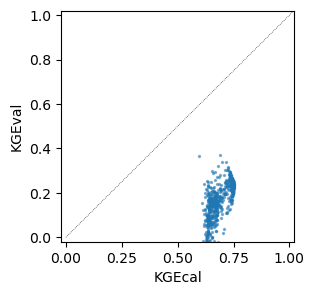

In [127]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(results.KGEcal, results.KGEval, s=2, alpha=.5)
ax.plot([0, 1.02], [0, 1.02], c='k', lw=.5, ls=':', zorder=0)
ax.set(xlim=(-.02, 1.02),
       xlabel='KGEcal',
       ylim=(-.02, 1.02),
       ylabel='KGEval');

**Parameters with the smallest likelihood in the calibration period**

iteration 748 got the highest performance:	KGE = 0.236
{'FFn': 0.38871026, 'FFf': 0.96762955, 'alpha': 0.1016056, 'QQn': 0.18224101, 'QQf': 0.9814218, 'k': 1.1421456}


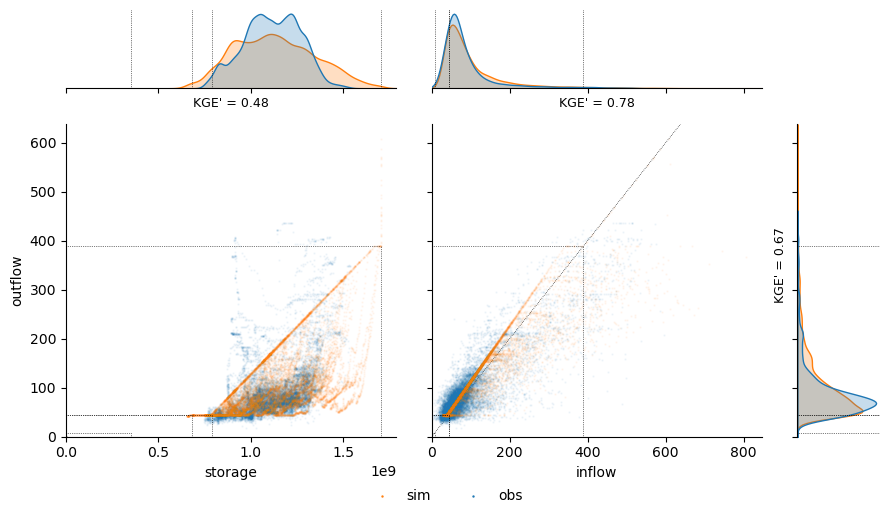

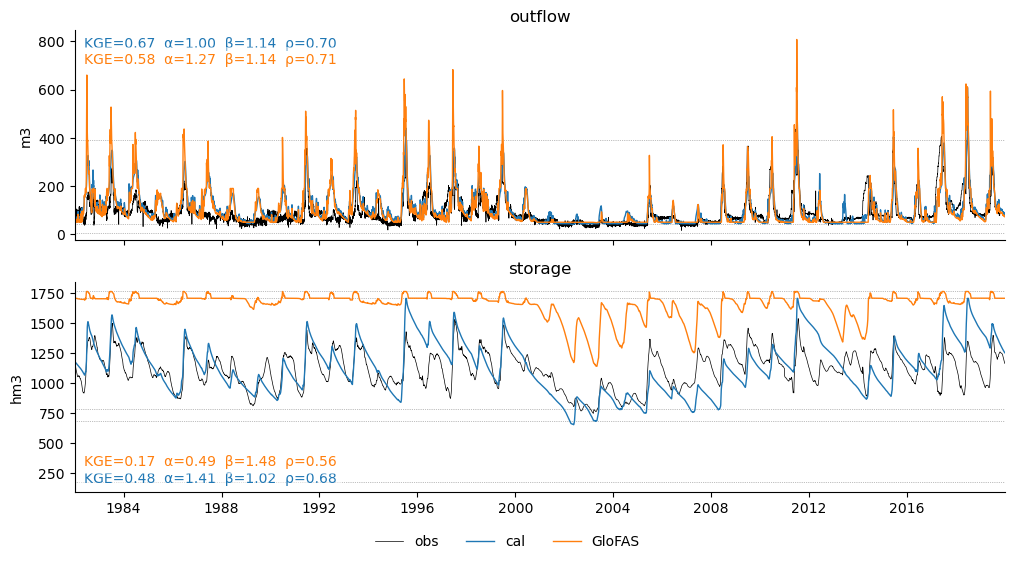

In [132]:
best_iter = results.like1.idxmin()
best_of = results.loc[best_iter, 'KGEval']
parnames = [col[3:] for col in cols if col.startswith('par')]
parvalues = {par: results.loc[best_iter, par] for par in parnames}
print(f'iteration {best_iter} got the highest performance:\tKGE = {best_of:.3f}')
#print('best parameters:\nalpha = {0:.3f}\nbeta  = {1:.3f}\nk = {2:.3f}'.format(alpha, beta, k))

print(parvalues)

# declare the reservoir
Vn, Vf = [parvalues[var] * Vtot for var in ['FFn', 'FFf']]
Vn_adj = Vn + parvalues['alpha'] * (Vf - Vn)
Qn, Qf = [obs.inflow.quantile(parvalues[var]) for var in ['QQn', 'QQf']]
k = parvalues['k']
res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qf)

# simulate calibration period and get performance
sim = res.simulate(sim_glofas.inflow, obs.storage[0], k=k)
res.scatter(sim, obs, norm=False)
res.lineplot({'cal': sim, 'GloFAS': sim_glofas}, obs)

**Parameters with the highest KGE in the validation period**

iteration 373 got the highest performance:	KGE = 0.369
{'FFn': 0.29205745, 'FFf': 0.86347216, 'alpha': 0.10144419, 'QQn': 0.30453447, 'QQf': 0.93911034, 'k': 1.2803514}


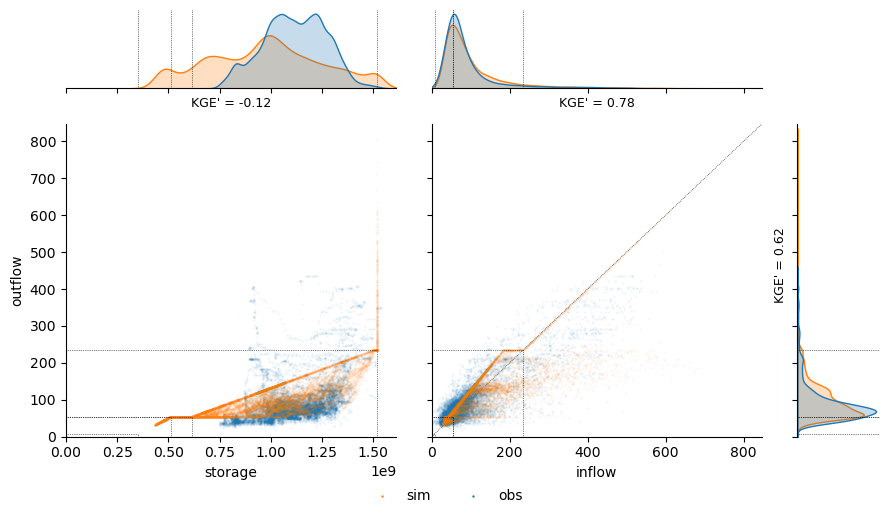

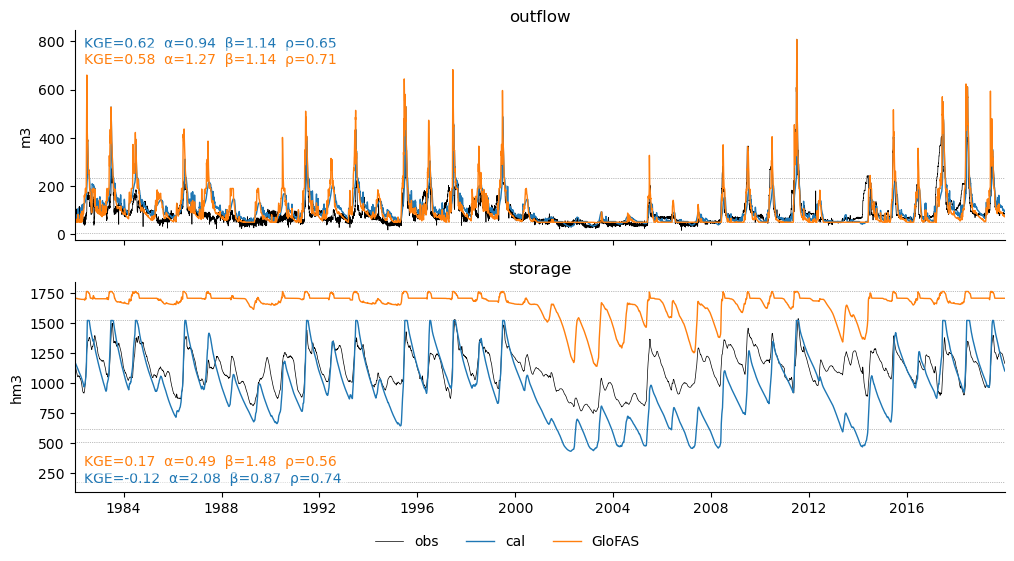

In [130]:
best_iter = results.like1.idxmin()
best_iter = results.KGEval.idxmax()
best_of = results.loc[best_iter, 'KGEval']
parnames = [col[3:] for col in cols if col.startswith('par')]
parvalues = {par: results.loc[best_iter, par] for par in parnames}
print(f'iteration {best_iter} got the highest performance:\tKGE = {best_of:.3f}')
#print('best parameters:\nalpha = {0:.3f}\nbeta  = {1:.3f}\nk = {2:.3f}'.format(alpha, beta, k))

print(parvalues)

# declare the reservoir
Vn, Vf = [parvalues[var] * Vtot for var in ['FFn', 'FFf']]
Vn_adj = Vn + parvalues['alpha'] * (Vf - Vn)
Qn, Qf = [obs.inflow.quantile(parvalues[var]) for var in ['QQn', 'QQf']]
k = parvalues['k']
res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qf)

# simulate calibration period and get performance
sim = res.simulate(glofas_ts[ResID].inflow, resops_ts[ResID].storage[0], k=k)
res.scatter(sim, obs, norm=False)
res.lineplot({'cal': sim, 'GloFAS': sim_glofas}, obs)

In [ ]:
plt.plot(simulation[best_iter])
plt.plot(y_train.outflow)

In [ ]:
import seaborn as sns

In [ ]:
parvalues

In [ ]:
sns.pairplot(results[results.KGE > 0.8], vars=parnames, hue='KGE', palette='coolwarm_r', plot_kws={'s': 10}, corner=True);

In [ ]:
fig, ax = plt.subplots(figsize=(4.5, 4))
sct = ax.scatter(results.alpha, results.beta, s=1, c=results.KGE, cmap='viridis')
ax.set(xlabel='alpha',
       xlim=(0, 1),
       ylabel='beta',
       ylim=(.25, 2));
cbar = plt.colorbar(sct, shrink=.666)
cbar.set_label('KGE (-)')

In [ ]:
fig, ax = plt.subplots(figsize=(4.5, 4))
sct = ax.scatter(results.alpha, results.beta, s=1, c=results.KGE, cmap='viridis')
ax.set(xlabel='alpha',
       xlim=(0, 1),
       ylabel='beta',
       ylim=(.25, 2));
cbar = plt.colorbar(sct, shrink=.666)
cbar.set_label('KGE (-)')

In [ ]:
# declare the reservoir with the effect of the parameters in 'x'
Vn_adj = Vn + alpha * (Vf - Vn)
#Qn = np.max(self.Qn * x[1], self.Qmin + .01)
Qn = Qn * beta
res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qnd)

sim = res.simulate(train.inflow, train.storage[0])

kge(train.outflow, sim.outflow)

In [ ]:
spotpy.parameter.Uniform()

In [ ]:
KGE(train.outflow, sim.outflow)

In [ ]:
plt.plot(train.outflow)
plt.plot(sim.outflow);

In [ ]:
pars = spotpy.analyser.get_best_paradmeterset(results)
pars

In [ ]:
# Plot the best model run
# Find the run_id with the minimal objective function value
bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)

bestindex, bestobjf

In [ ]:
# Select best model run
best_model_run = results[bestindex]

In [ ]:
best_model_run

In [ ]:
# Filter results for simulation results
fields = [word for word in best_model_run.dtype.names if word.startswith("sim")]
best_simulation = list(best_model_run[fields])

In [ ]:
fields

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(
    best_simulation,
    color="black",
    linestyle="solid",
    label="Best objf.=" + str(bestobjf),
)
ax.plot(setup.evaluation(), "r.", markersize=3, label="Observation data")
plt.xlabel("Number of Observation Points")
plt.ylabel("Discharge [l s-1]")
plt.legend(loc="upper right");
# fig.savefig("SCEUA_best_modelrun.png", dpi=150);